In [44]:
import numpy as np 
import pandas as pd 
import shutil
import random
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, WeightedRandomSampler,Subset,ConcatDataset,DataLoader
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2
from glob import glob
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import random_split
from torch.nn.functional import softmax
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from tqdm import tqdm
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score,f1_score
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

In [45]:
dataset_path = "/kaggle/input/gsoc-lens-finding"  
print("Dataset contents:", os.listdir(dataset_path))

Dataset contents: ['train_lenses', 'test_nonlenses', 'train_nonlenses', 'test_lenses']


In [47]:
source = "/kaggle/input/gsoc-lens-finding/train_lenses"
destination = "/kaggle/working/train_lenses"

shutil.copytree(source, destination)
print("Folder copied successfully!")

In [ ]:
source = "/kaggle/input/gsoc-lens-finding/train_lenses"
destination = "/kaggle/working/train_lenses1"

shutil.copytree(source, destination)
print("Folder copied successfully!")

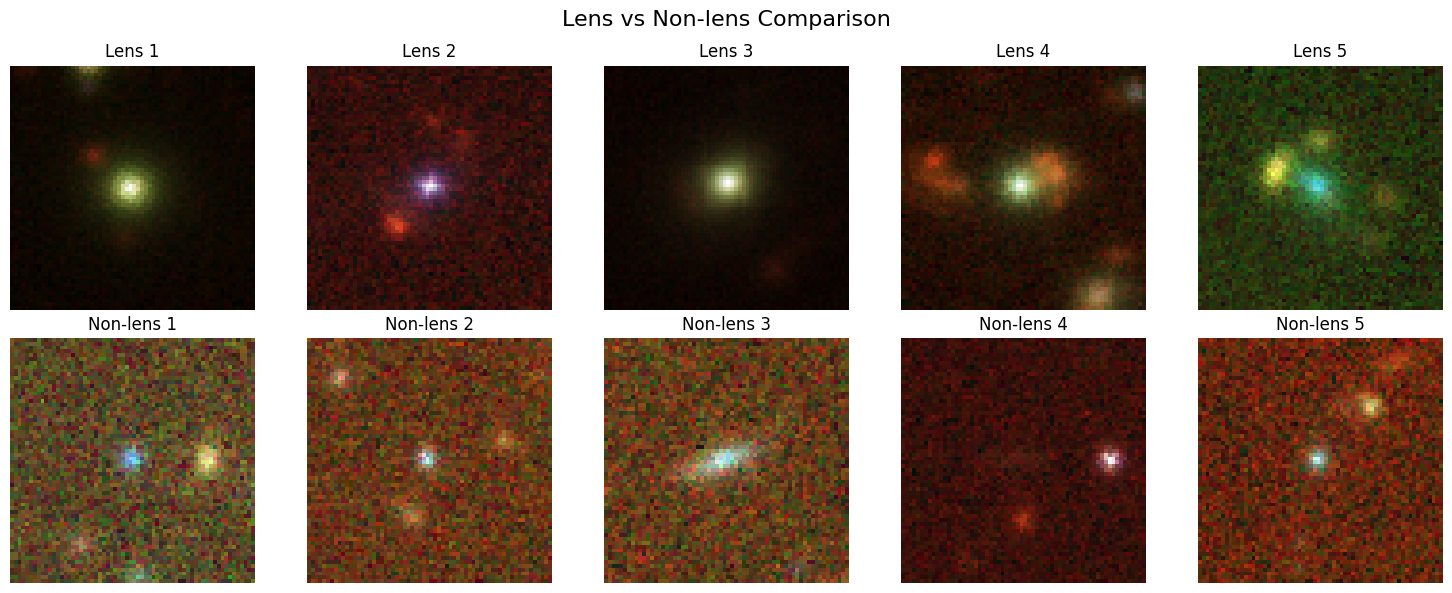

In [48]:
lens_dir = "/kaggle/input/gsoc-lens-finding/train_lenses"
nonlens_dir = "/kaggle/input/gsoc-lens-finding/train_nonlenses"
lens_files = [f for f in os.listdir(lens_dir) if f.endswith('.npy')]
nonlens_files = [f for f in os.listdir(nonlens_dir) if f.endswith('.npy')]
num_images = 5
lens_sample = random.sample(lens_files, min(num_images, len(lens_files)))
nonlens_sample = random.sample(nonlens_files, min(num_images, len(nonlens_files)))
fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
for i, filename in enumerate(lens_sample):
    img_path = os.path.join(lens_dir, filename)
    img = np.load(img_path).transpose(2,1,0)
    
    axes[0, i].imshow(img, cmap='viridis')
    axes[0, i].set_title(f"Lens {i+1}")
    axes[0, i].axis('off')

for i, filename in enumerate(nonlens_sample):
    img_path = os.path.join(nonlens_dir, filename)
    img = np.load(img_path).transpose(2,1,0)
    axes[1, i].imshow(img, cmap='viridis')
    axes[1, i].set_title(f"Non-lens {i+1}")
    axes[1, i].axis('off')

plt.suptitle("Lens vs Non-lens Comparison", fontsize=16)
plt.tight_layout()
plt.show()

In [49]:
basic_transforms = A.Compose([
    ToTensorV2(),
])

In [50]:
class LensDataset(Dataset):
    def __init__(self, directory, label, augment=False, target_size=(64, 64)):
        self.file_paths = glob(os.path.join(directory, "*.npy"))
        self.label = label
        self.augment = augment
        self.target_size = target_size
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        img = np.load(file_path)
        img = img.astype(np.float32)
        if self.augment:
            augmented = train_augmentations(image=img)
        else:
            augmented = basic_transforms(image=img)

        img_tensor = augmented["image"].permute(2, 0, 1).clone().detach()  # (C, H, W)

        return img_tensor, torch.tensor(self.label, dtype=torch.long)

# Training Model on Resnet18 with CrossentropyLoss

In [62]:
device="cpu"
if torch.cuda.is_available:
    device="cuda"

In [63]:
lenses_dataset0=LensDataset("/kaggle/input/gsoc-lens-finding/train_lenses",label=1)
non_lenses_dataset0=LensDataset("/kaggle/input/gsoc-lens-finding/train_nonlenses",label=0)
train_dataset0=ConcatDataset([lenses_dataset0,non_lenses_dataset0])
train_ratio = 0.9
train_size = int(train_ratio * len(train_dataset0))
val_size = len(train_dataset0) - train_size
train_subset0, val_subset0 = random_split(train_dataset0, [train_size, val_size])
test_lenses=LensDataset("/kaggle/input/gsoc-lens-finding/test_lenses",label=1)
test_nonlenses=LensDataset("/kaggle/input/gsoc-lens-finding/test_nonlenses",label=0)
test_dataset0=ConcatDataset([test_lenses,test_nonlenses])

In [64]:
train_loader0 = DataLoader(train_subset0, batch_size=64, shuffle=True)
val_loader0 = DataLoader(val_subset0, batch_size=64, shuffle=False)
test_loader0=DataLoader(test_dataset0,batch_size=64,shuffle=False)

In [65]:
def train(train_loader, test_loader, model, criterion, optimizer, epochs, scheduler):
    epoch_loss = 0
    for epoch in range(epochs):
        print("Epoch Number", epoch)
        model.train()
        
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            batch = x.shape[0]
            x = x.view(batch, 3, 64, 64)
            out = model(x)
            optimizer.zero_grad()
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss / len(train_loader):.4f}")
        print("Testing")
        pred_list, true_list, prob_list = [], [], []
        
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                batch = x.shape[0]
                x = x.view(batch, 3, 64, 64)
                
                out = model(x)
                prob = softmax(out, dim=1)[:, 1]
                threshold = 0.5
                pred = (prob >= threshold).long()
                
                pred_list.extend(pred.cpu().numpy().tolist())
                true_list.extend(y.cpu().numpy().tolist())
                prob_list.extend(prob.cpu().numpy().tolist())
                
        if len(set(true_list)) > 1:
            auc = roc_auc_score(true_list, prob_list)
            print("The ROC AUC score is:", auc)
        else:
            print("Skipping ROC AUC score calculation (only one class present)")
            
        f1 = f1_score(true_list, pred_list, average=None)
        f2 = f1_score(true_list, pred_list, average="macro")
        print("The F1 score is:", f1, " ", f2)
        
        plt.figure(figsize=(8, 3))
        
        plt.subplot(1, 2, 1)
        fpr, tpr, _ = roc_curve(true_list, prob_list)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Epoch {epoch+1}')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        cm = confusion_matrix(true_list, pred_list)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix - Epoch {epoch+1}")
        
        plt.tight_layout()
        plt.show()

In [80]:
def test_model(test_loader, model, threshold=0.5):
    model.eval()
    pred_list, true_list, prob_list = [], [], []
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            batch = x.shape[0]
            x = x.view(batch, 3, 64, 64)
            
            out = model(x)
            prob = softmax(out, dim=1)[:, 1]
            pred = (prob >= threshold).long()
            
            pred_list.extend(pred.cpu().numpy().tolist())
            true_list.extend(y.cpu().numpy().tolist())
            prob_list.extend(prob.cpu().numpy().tolist())
    
    if len(set(true_list)) > 1:
        auc = roc_auc_score(true_list, prob_list)
        print("The ROC AUC score is:", auc)
    else:
        print("Skipping ROC AUC score calculation (only one class present)")
        auc = None

    f1 = f1_score(true_list, pred_list, average=None)
    f2 = f1_score(true_list, pred_list, average="macro")
    print("The F1 score is:", f1, " ", f2)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    if auc is not None:
        fpr, tpr, _ = roc_curve(true_list, prob_list)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()

    plt.subplot(1, 2, 2)
    cm = confusion_matrix(true_list, pred_list)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    return true_list, prob_list, auc

In [67]:
model=timm.create_model("resnet18",pretrained=True,num_classes=2)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion=nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

In [68]:
device

'cuda'

In [69]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

Epoch Number 0


100%|██████████| 428/428 [00:35<00:00, 12.00it/s]


Epoch 1/10 - Loss: 0.1298
Testing
The ROC AUC score is: 0.9571380742950191
The F1 score is: [0.97752222 0.62390671]   0.8007144609766841


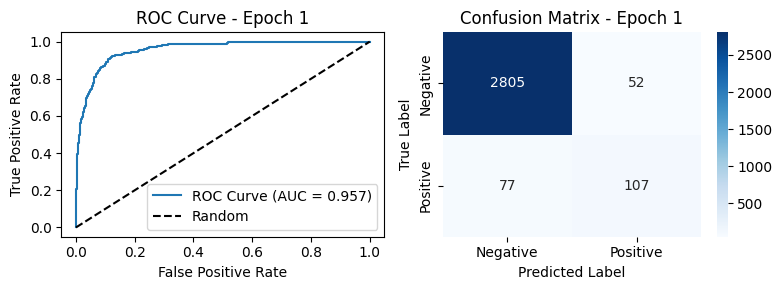

Epoch Number 1


100%|██████████| 428/428 [00:36<00:00, 11.81it/s]


Epoch 2/10 - Loss: 0.2312
Testing
The ROC AUC score is: 0.9669366620504939
The F1 score is: [0.9757384  0.64974619]   0.8127422947589369


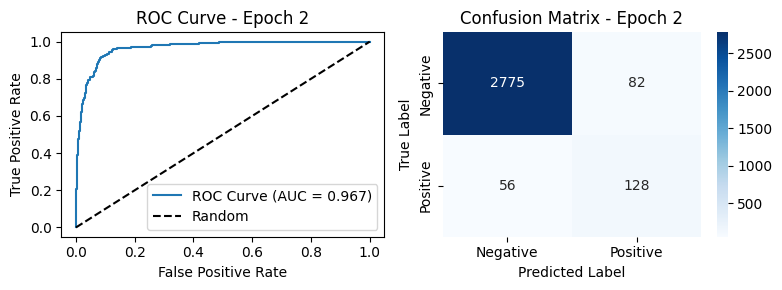

Epoch Number 2


100%|██████████| 428/428 [00:37<00:00, 11.44it/s]


Epoch 3/10 - Loss: 0.3083
Testing
The ROC AUC score is: 0.9703398213388931
The F1 score is: [0.9741867 0.657277 ]   0.8157318498449442


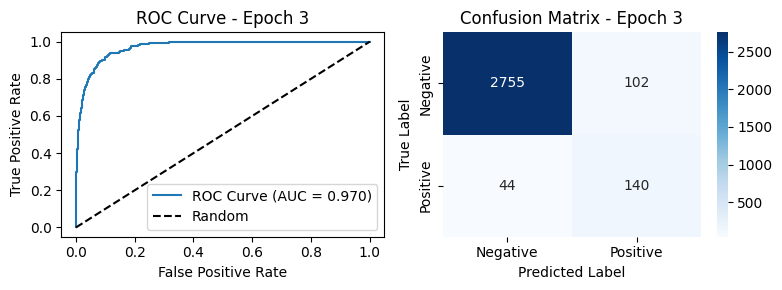

Epoch Number 3


100%|██████████| 428/428 [00:35<00:00, 11.93it/s]


Epoch 4/10 - Loss: 0.3935
Testing
The ROC AUC score is: 0.9740777799759552
The F1 score is: [0.98265094 0.68553459]   0.8340927640221893


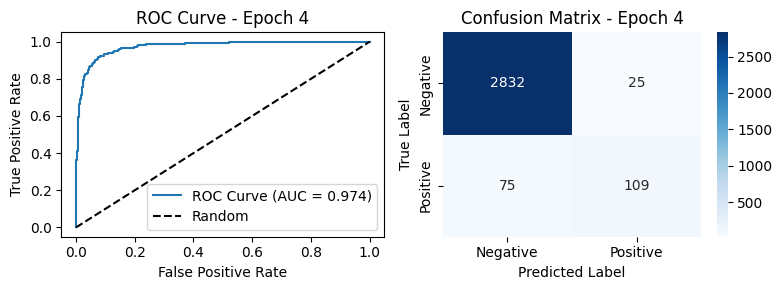

Epoch Number 4


100%|██████████| 428/428 [00:36<00:00, 11.67it/s]


Epoch 5/10 - Loss: 0.4520
Testing
The ROC AUC score is: 0.9787364368218411
The F1 score is: [0.98394976 0.73714286]   0.860546306450005


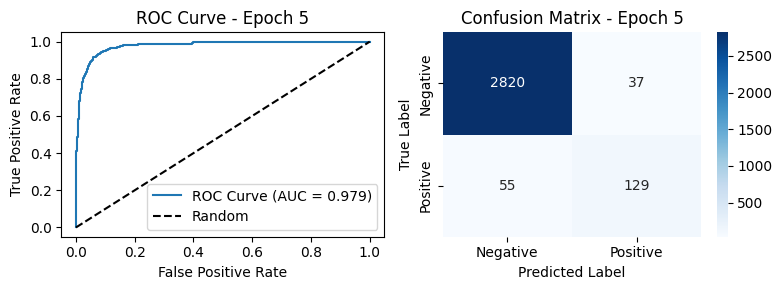

Epoch Number 5


100%|██████████| 428/428 [00:36<00:00, 11.82it/s]


Epoch 6/10 - Loss: 0.4868
Testing
The ROC AUC score is: 0.9654034332151389
The F1 score is: [0.98266297 0.68152866]   0.8320958152601217


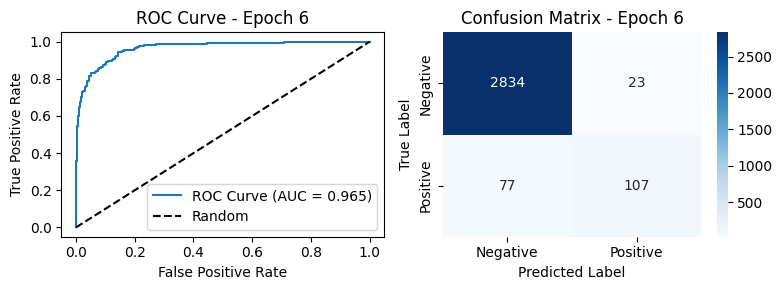

Epoch Number 6


100%|██████████| 428/428 [00:37<00:00, 11.56it/s]


Epoch 7/10 - Loss: 0.5561
Testing
The ROC AUC score is: 0.9639443928718175
The F1 score is: [0.97904036 0.60841424]   0.7937272998900697


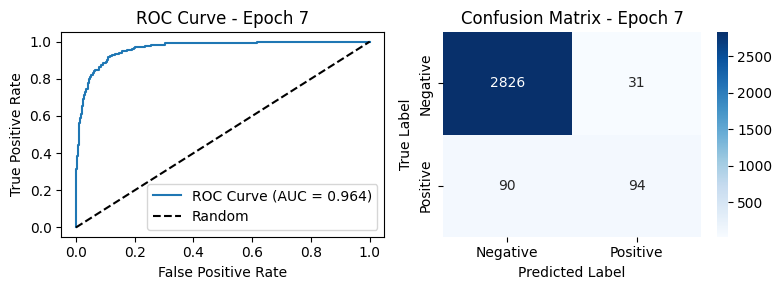

Epoch Number 7


100%|██████████| 428/428 [00:36<00:00, 11.64it/s]


Epoch 8/10 - Loss: 0.6106
Testing
The ROC AUC score is: 0.9756471519228136
The F1 score is: [0.984465   0.74787535]   0.8661701783629533


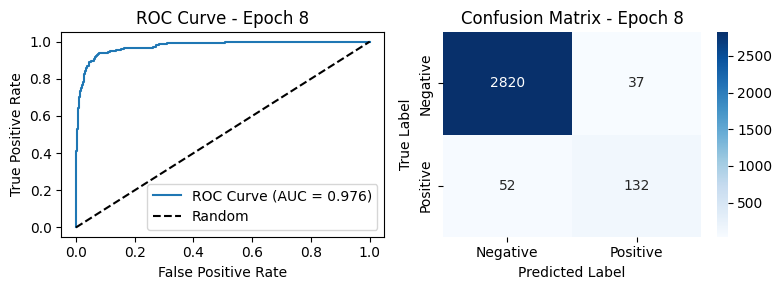

Epoch Number 8


100%|██████████| 428/428 [00:37<00:00, 11.49it/s]


Epoch 9/10 - Loss: 0.6482
Testing
The ROC AUC score is: 0.9728355983016542
The F1 score is: [0.98604813 0.77011494]   0.8780815382333249


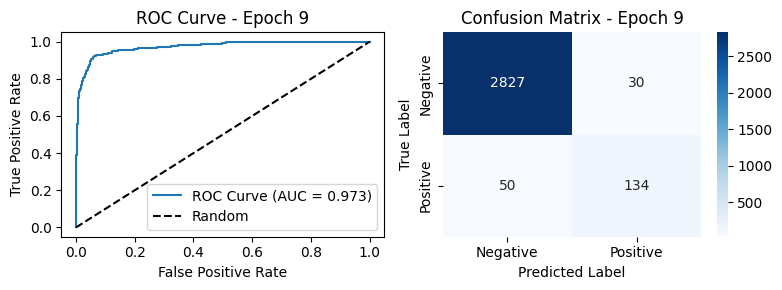

Epoch Number 9


100%|██████████| 428/428 [00:36<00:00, 11.66it/s]


Epoch 10/10 - Loss: 0.6709
Testing
The ROC AUC score is: 0.9756300315015751
The F1 score is: [0.9851632 0.7592068]   0.872185001807315


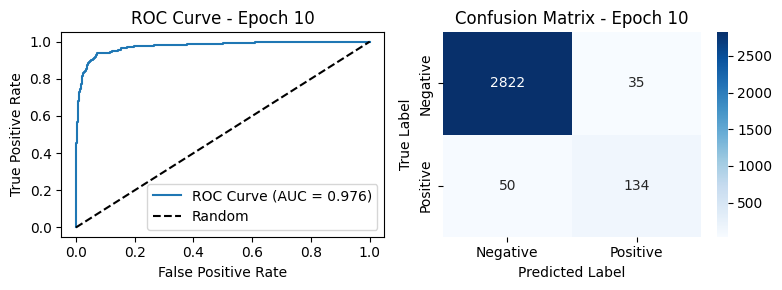

In [70]:
train(train_loader0,val_loader0,model,criterion,optimizer,10,scheduler)

The ROC AUC score is: 0.9597791089232879
The F1 score is: [0.9928013  0.48618785]   0.739494572857058


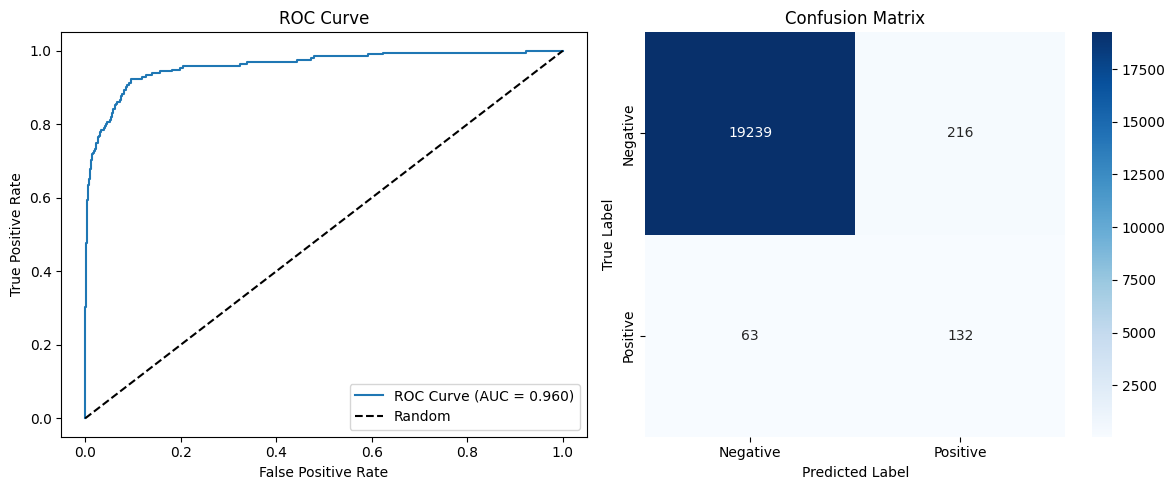

In [71]:
t1,p1,roc1=test_model(test_loader0,model)
torch.save(model.state_dict(),"resnet18.pth")

# Now trying CrossEntropyLoss with class weights as parameters

In [72]:
model1=timm.create_model("resnet18",pretrained=True,num_classes=2)
model1.to(device)
optimizer1 = optim.AdamW(model1.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler1 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)
num_lensed=1730
num_nonlensed=28675
total=num_lensed+num_nonlensed
weight_lensed=total/(2*num_lensed)
weight_nonlensed=total/(2*num_nonlensed)
class_weights=torch.tensor([weight_nonlensed, weight_lensed], dtype=torch.float32)
criterion1=nn.CrossEntropyLoss(weight=class_weights).to(device)

Epoch Number 0


100%|██████████| 428/428 [00:37<00:00, 11.35it/s]


Epoch 1/10 - Loss: 0.3178
Testing
The ROC AUC score is: 0.9466451583448738
The F1 score is: [0.91553544 0.42416452]   0.6698499846844017


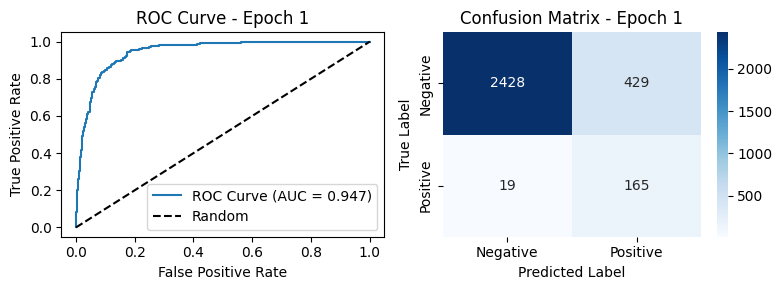

Epoch Number 1


100%|██████████| 428/428 [00:37<00:00, 11.50it/s]


Epoch 2/10 - Loss: 0.5618
Testing
The ROC AUC score is: 0.9643533807125139
The F1 score is: [0.94117647 0.51593323]   0.7285548513790949


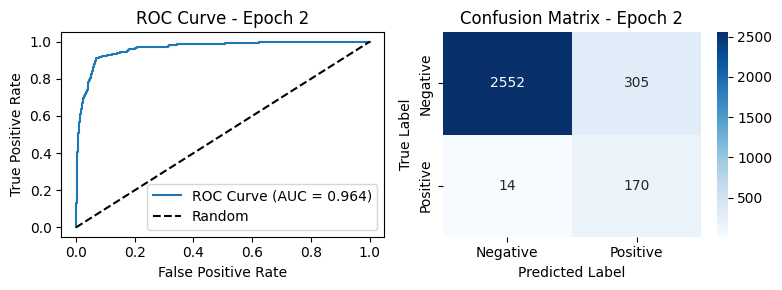

Epoch Number 2


100%|██████████| 428/428 [00:36<00:00, 11.81it/s]


Epoch 3/10 - Loss: 0.7875
Testing
The ROC AUC score is: 0.972742387119356
The F1 score is: [0.95520757 0.58305085]   0.7691292110558345


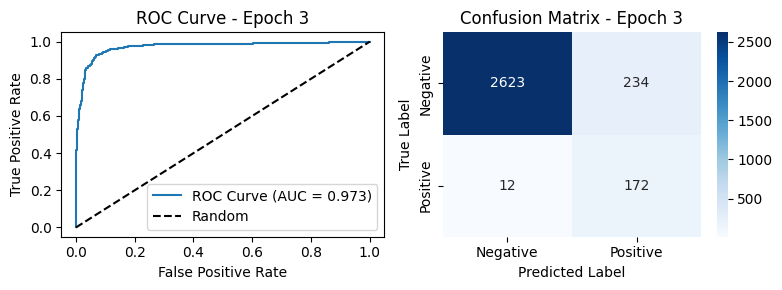

Epoch Number 3


100%|██████████| 428/428 [00:36<00:00, 11.58it/s]


Epoch 4/10 - Loss: 0.9907
Testing
The ROC AUC score is: 0.9678916011017942
The F1 score is: [0.92905153 0.47658402]   0.702817776515923


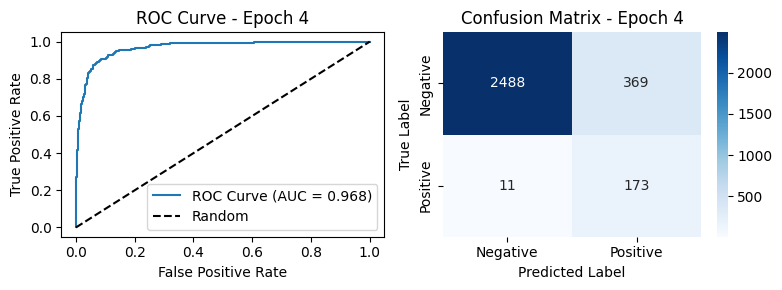

Epoch Number 4


100%|██████████| 428/428 [00:36<00:00, 11.69it/s]


Epoch 5/10 - Loss: 1.1580
Testing
The ROC AUC score is: 0.9776102935581562
The F1 score is: [0.95116151 0.56585366]   0.7585075865391908


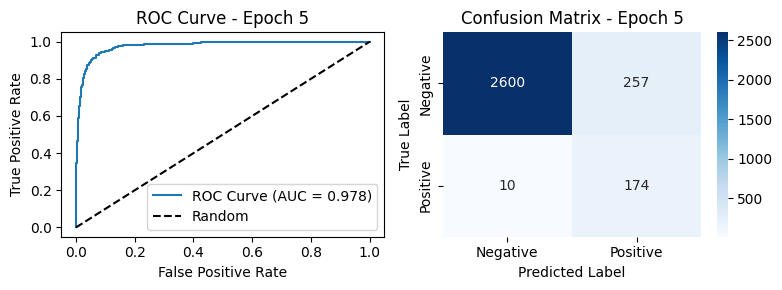

Epoch Number 5


100%|██████████| 428/428 [00:35<00:00, 12.03it/s]


Epoch 6/10 - Loss: 1.3177
Testing
The ROC AUC score is: 0.975690904110423
The F1 score is: [0.9488355  0.55643879]   0.7526371475627687


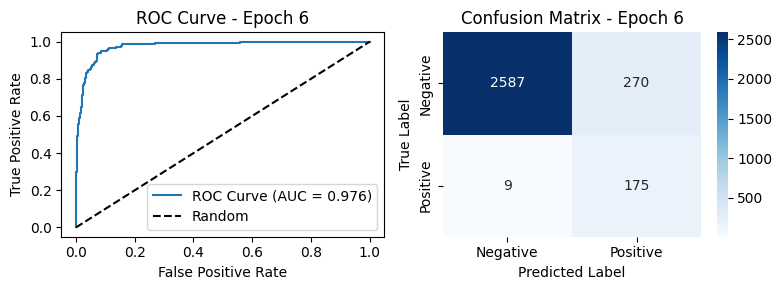

Epoch Number 6


100%|██████████| 428/428 [00:36<00:00, 11.62it/s]


Epoch 7/10 - Loss: 1.4611
Testing
The ROC AUC score is: 0.97860137572096
The F1 score is: [0.96146191 0.61621622]   0.7888390652277029


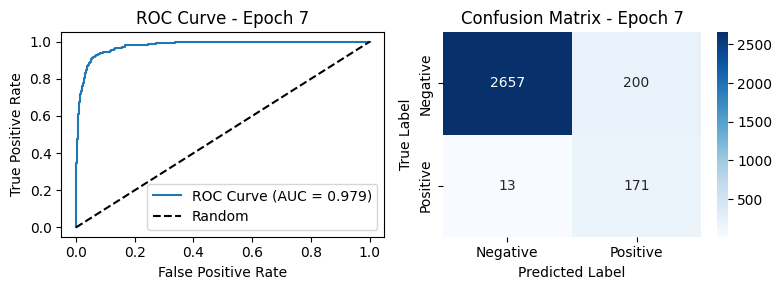

Epoch Number 7


100%|██████████| 428/428 [00:37<00:00, 11.32it/s]


Epoch 8/10 - Loss: 1.5900
Testing
The ROC AUC score is: 0.9733777449742054
The F1 score is: [0.96732496 0.64453125]   0.8059281025583482


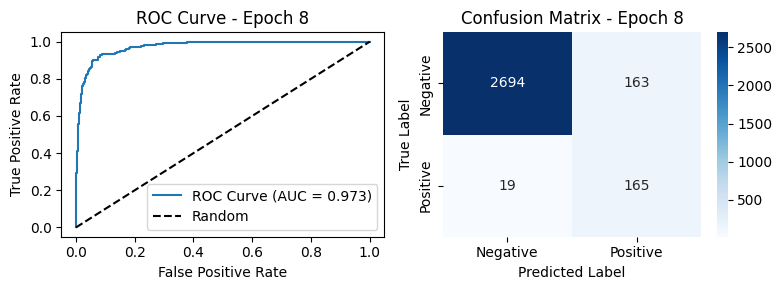

Epoch Number 8


100%|██████████| 428/428 [00:35<00:00, 11.98it/s]


Epoch 9/10 - Loss: 1.7079
Testing
The ROC AUC score is: 0.9644256669355207
The F1 score is: [0.94396473 0.52269171]   0.7333282155627951


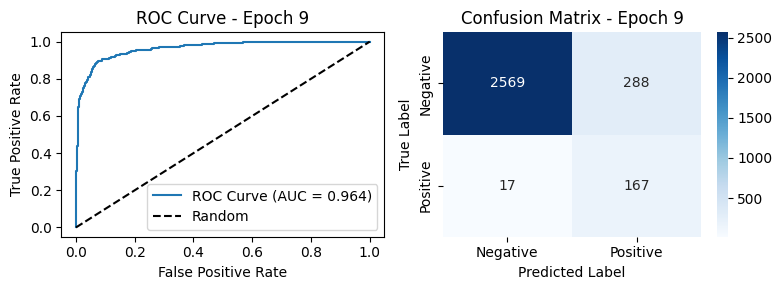

Epoch Number 9


100%|██████████| 428/428 [00:36<00:00, 11.67it/s]


Epoch 10/10 - Loss: 1.8206
Testing
The ROC AUC score is: 0.9780573267793825
The F1 score is: [0.97289586 0.67932489]   0.8261103787837747


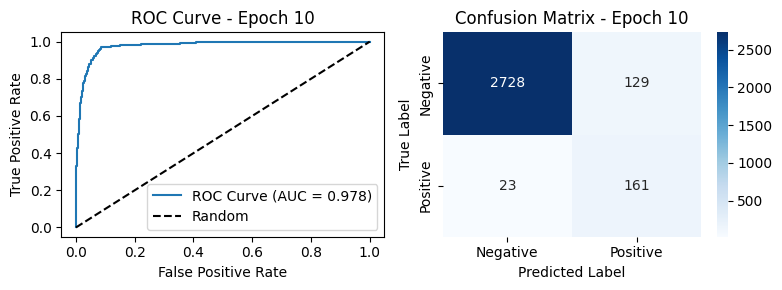

In [73]:
train(train_loader0,val_loader0,model1,criterion1,optimizer1,10,scheduler1)

The ROC AUC score is: 0.9692937679984711
The F1 score is: [0.97692974 0.26688907]   0.6219094068027216


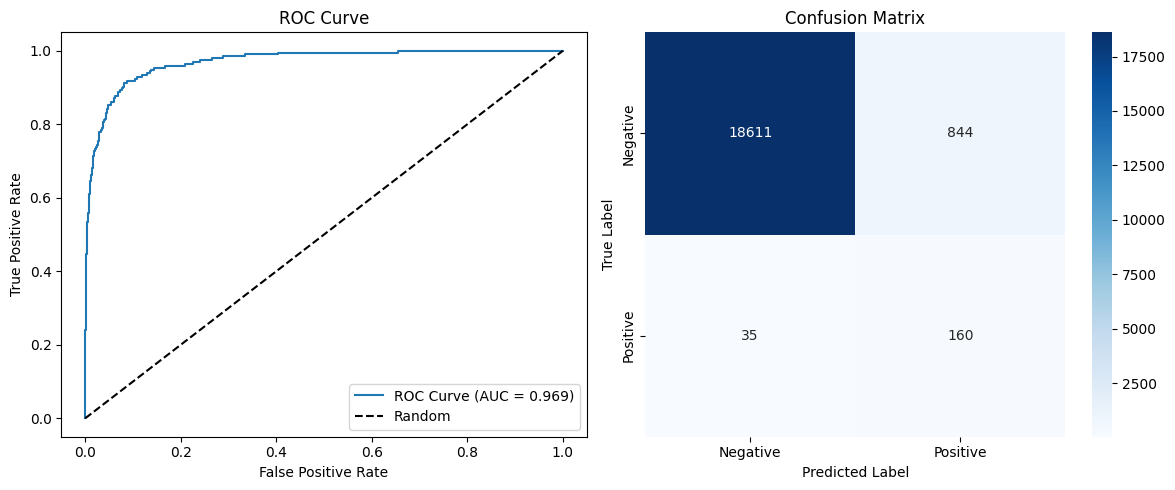

In [74]:
t2,p2,roc2=test_model(test_loader0,model1)
torch.save(model1.state_dict(),"resnet18weighted.pth")

# Trying Focal loss instead of CrossEntropyLoss

In [75]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1) 
        targets_one_hot = F.one_hot(targets, num_classes=logits.shape[1]).float()

        pt = (probs * targets_one_hot).sum(dim=1)  
        focal_weight = (1 - pt) ** self.gamma  

        loss = -self.alpha * focal_weight * torch.log(pt + 1e-8) 
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [76]:
model2=timm.create_model("resnet18",pretrained=True,num_classes=2).to(device)
criterion2=FocalLoss()
optimizer2 = optim.AdamW(model2.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler2 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer2, T_0=5, T_mult=2, eta_min=1e-6)

Epoch Number 0


100%|██████████| 428/428 [00:35<00:00, 11.94it/s]


Epoch 1/10 - Loss: 0.0092
Testing
The ROC AUC score is: 0.9540830302384684
The F1 score is: [0.97356905 0.59078591]   0.782177480448006


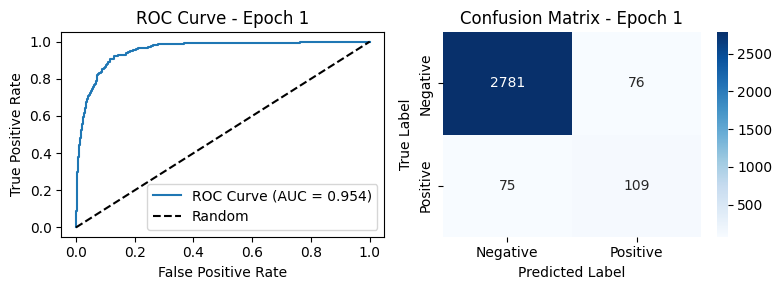

Epoch Number 1


100%|██████████| 428/428 [00:36<00:00, 11.68it/s]


Epoch 2/10 - Loss: 0.0163
Testing
The ROC AUC score is: 0.9606002039232396
The F1 score is: [0.97665505 0.60818713]   0.7924210933838661


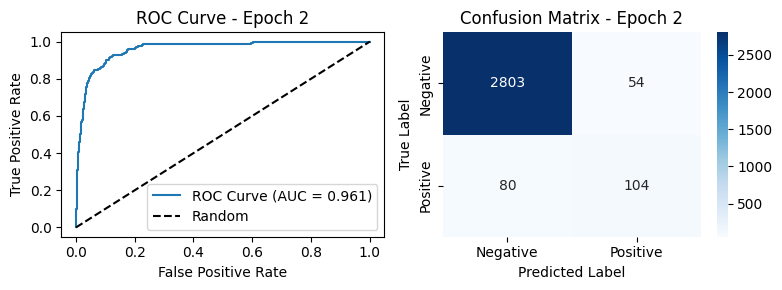

Epoch Number 2


100%|██████████| 428/428 [00:38<00:00, 11.02it/s]


Epoch 3/10 - Loss: 0.0218
Testing
The ROC AUC score is: 0.9677394195796747
The F1 score is: [0.97653907 0.6779661 ]   0.8272525869208393


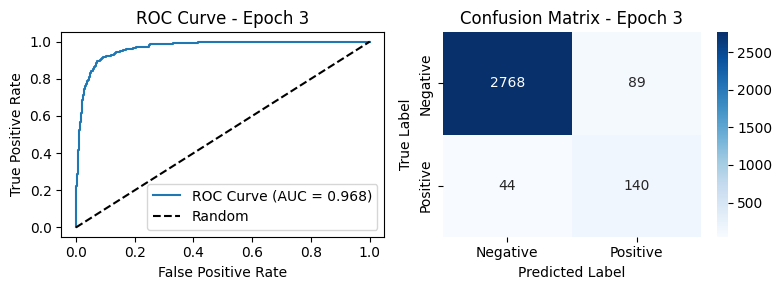

Epoch Number 3


100%|██████████| 428/428 [00:37<00:00, 11.32it/s]


Epoch 4/10 - Loss: 0.0279
Testing
The ROC AUC score is: 0.9704596642875623
The F1 score is: [0.98077922 0.63843648]   0.8096078514319557


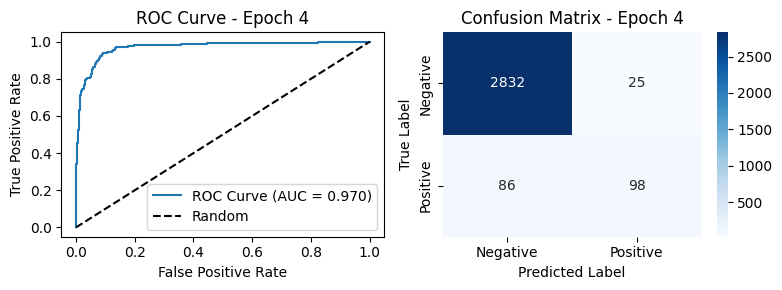

Epoch Number 4


100%|██████████| 428/428 [00:37<00:00, 11.42it/s]


Epoch 5/10 - Loss: 0.0321
Testing
The ROC AUC score is: 0.9746180243794799
The F1 score is: [0.98374978 0.74094708]   0.8623484283959997


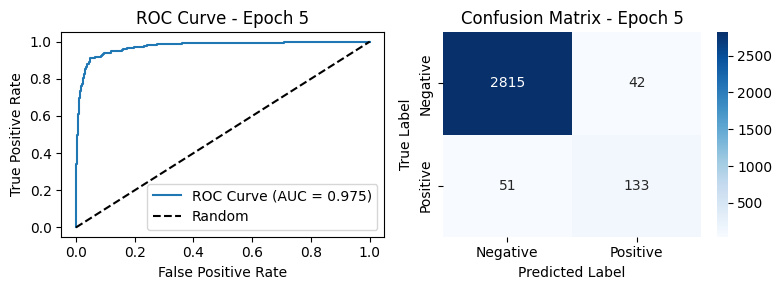

Epoch Number 5


100%|██████████| 428/428 [00:38<00:00, 11.24it/s]


Epoch 6/10 - Loss: 0.0346
Testing
The ROC AUC score is: 0.9632234329107761
The F1 score is: [0.98151667 0.63481229]   0.808164478117555


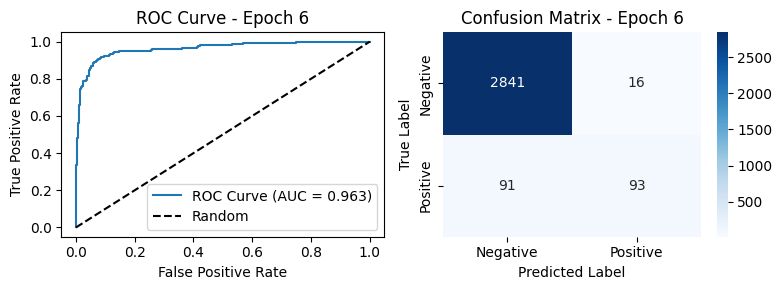

Epoch Number 6


100%|██████████| 428/428 [00:38<00:00, 11.13it/s]


Epoch 7/10 - Loss: 0.0396
Testing
The ROC AUC score is: 0.8804937529485171
The F1 score is: [0.94721724 0.42578125]   0.6864992425942549


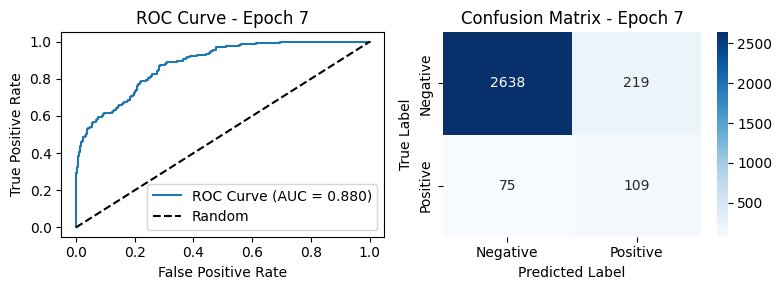

Epoch Number 7


100%|██████████| 428/428 [00:36<00:00, 11.75it/s]


Epoch 8/10 - Loss: 0.0438
Testing
The ROC AUC score is: 0.9776616548218714
The F1 score is: [0.98289703 0.72159091]   0.8522439711248612


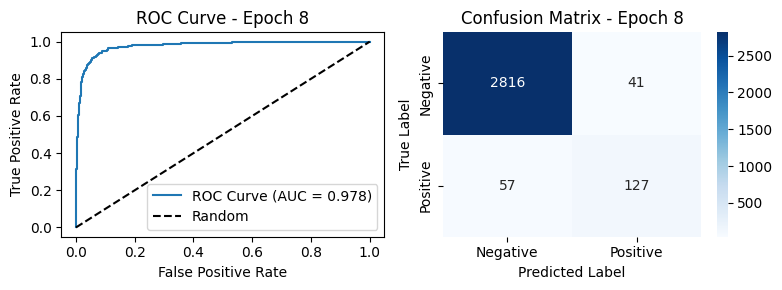

Epoch Number 8


100%|██████████| 428/428 [00:37<00:00, 11.46it/s]


Epoch 9/10 - Loss: 0.0467
Testing
The ROC AUC score is: 0.9806101718129385
The F1 score is: [0.98394614 0.67820069]   0.8310734169684567


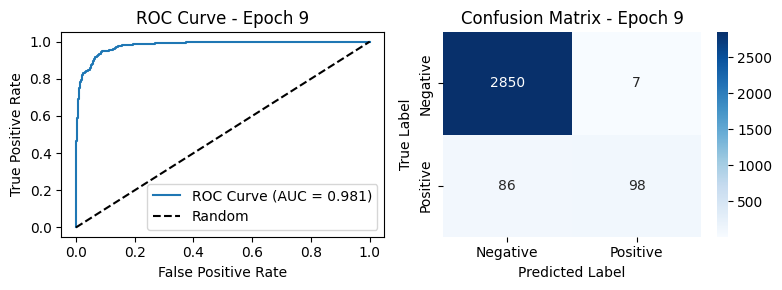

Epoch Number 9


100%|██████████| 428/428 [00:36<00:00, 11.64it/s]


Epoch 10/10 - Loss: 0.0486
Testing
The ROC AUC score is: 0.9783654943616746
The F1 score is: [0.98439667 0.7133758 ]   0.8488862337341097


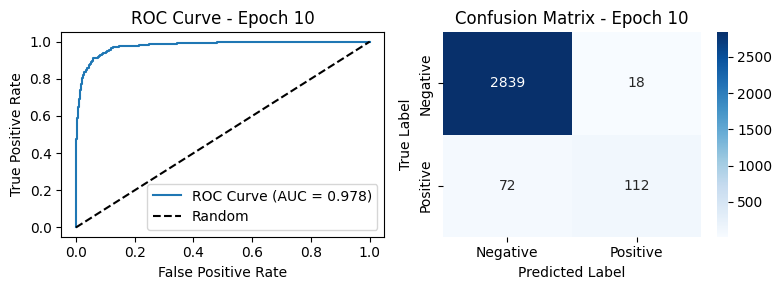

In [77]:
train(train_loader0,val_loader0,model2,criterion2,optimizer2,10,scheduler2)

The ROC AUC score is: 0.9629675319112481
The F1 score is: [0.99495885 0.53333333]   0.7641460905349795


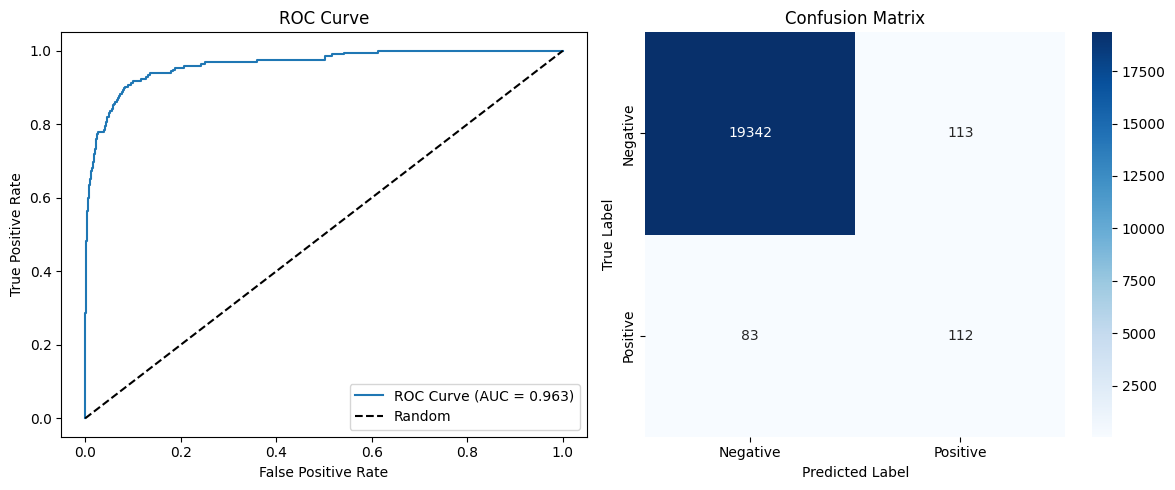

In [78]:
t3,p3,roc3=test_model(test_loader0,model2)
torch.save(model2.state_dict(),"focalloss.pth")

# Adding data using SMOTE

In [24]:
batch_size=64
features = []
labels = []
for img, label in train_dataset0:
    features.append(img.numpy().flatten())
    labels.append(label)

features = np.array(features)
labels = np.array(labels)
unique_classes, class_counts = np.unique(labels, return_counts=True)
minority_class = unique_classes[np.argmin(class_counts)]

minority_class_count = np.sum(labels == minority_class)

desired_minority_size = minority_class_count + 5000
sampling_strategy = {minority_class: desired_minority_size}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, labels)

X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)
balanced_dataset = torch.utils.data.TensorDataset(X_resampled, y_resampled)
train_size = int(0.9 * len(balanced_dataset))
val_size = len(balanced_dataset) - train_size
train_dataset1, val_dataset1 = random_split(balanced_dataset, [train_size, val_size])
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader1 = DataLoader(val_dataset1, batch_size=batch_size, shuffle=False, num_workers=4)

In [25]:
model3=timm.create_model("resnet18",pretrained=True,num_classes=2)
model3.to(device)
optimizer3 = optim.AdamW(model3.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler3 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer3, T_0=5, T_mult=2, eta_min=1e-6)
criterion3=nn.CrossEntropyLoss(weight=class_weights).to(device)

Epoch Number 0


100%|██████████| 498/498 [00:13<00:00, 36.78it/s]

Epoch 1/10 - Loss: 0.1787
Testing


The ROC AUC score is: 0.9803115155757787
The F1 score is: [0.92540662 0.76976342]   0.8475850170504985


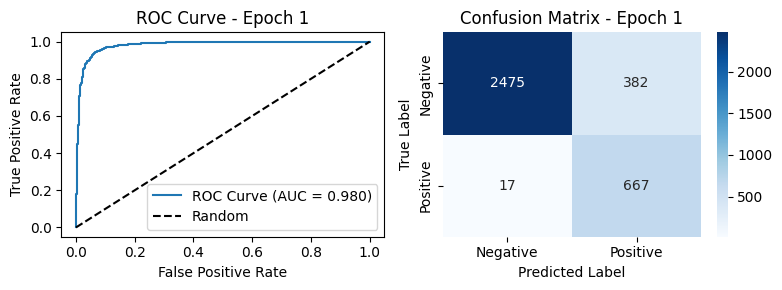

Epoch Number 1


100%|██████████| 498/498 [00:13<00:00, 37.01it/s]

Epoch 2/10 - Loss: 0.2993
Testing


The ROC AUC score is: 0.9878123292129519
The F1 score is: [0.94537429 0.81945289]   0.8824135874143897


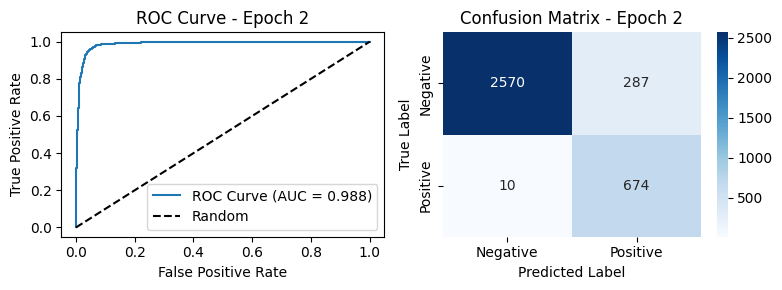

Epoch Number 2


100%|██████████| 498/498 [00:13<00:00, 36.66it/s]

Epoch 3/10 - Loss: 0.3922
Testing


The ROC AUC score is: 0.9724279342622102
The F1 score is: [0.77322463 0.56340355]   0.6683140910794405


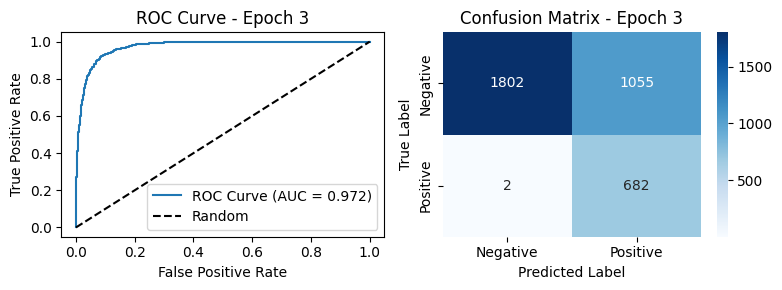

Epoch Number 3


100%|██████████| 498/498 [00:13<00:00, 36.60it/s]

Epoch 4/10 - Loss: 0.4806
Testing


The ROC AUC score is: 0.9912106716446933
The F1 score is: [0.96253394 0.86705202]   0.9147929798864856


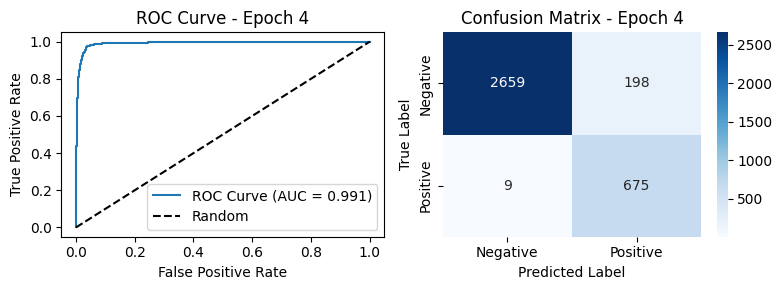

Epoch Number 4


100%|██████████| 498/498 [00:13<00:00, 36.99it/s]

Epoch 5/10 - Loss: 0.5269
Testing


The ROC AUC score is: 0.9938153340415559
The F1 score is: [0.98150782 0.92866941]   0.9550886168819892


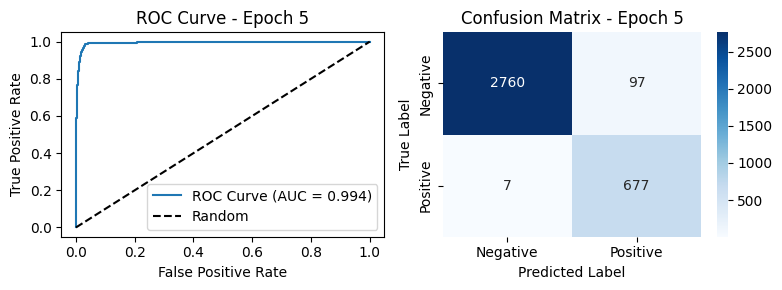

Epoch Number 5


100%|██████████| 498/498 [00:13<00:00, 36.76it/s]

Epoch 6/10 - Loss: 0.6146
Testing


The ROC AUC score is: 0.9855443795581592
The F1 score is: [0.96333573 0.86561265]   0.9144741889561068


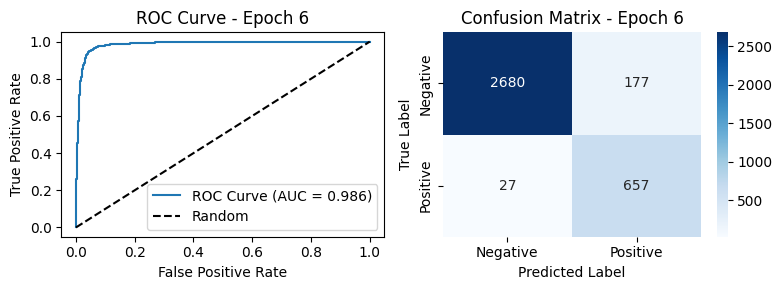

Epoch Number 6


100%|██████████| 498/498 [00:13<00:00, 36.92it/s]

Epoch 7/10 - Loss: 0.6843
Testing


The ROC AUC score is: 0.9923466933580598
The F1 score is: [0.96566679 0.87726098]   0.9214638845231125


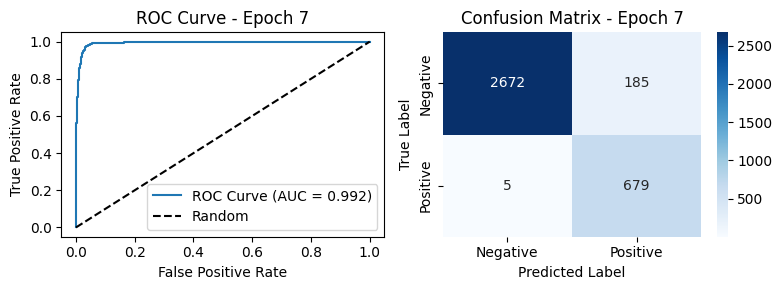

Epoch Number 7


100%|██████████| 498/498 [00:13<00:00, 36.24it/s]

Epoch 8/10 - Loss: 0.7338
Testing


The ROC AUC score is: 0.9943209148761533
The F1 score is: [0.98063599 0.92498279]   0.9528093932010968


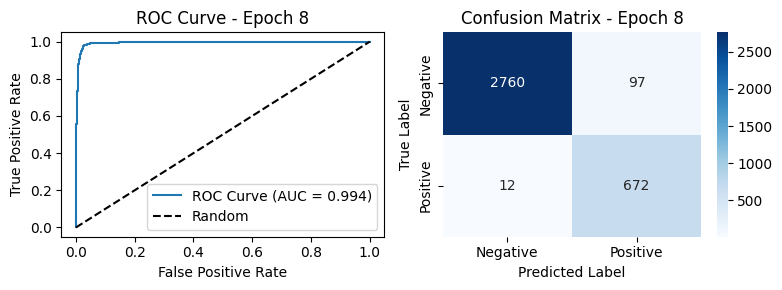

Epoch Number 8


100%|██████████| 498/498 [00:13<00:00, 36.62it/s]

Epoch 9/10 - Loss: 0.7618
Testing


The ROC AUC score is: 0.9957905790026343
The F1 score is: [0.98458267 0.93954135]   0.9620620084758191


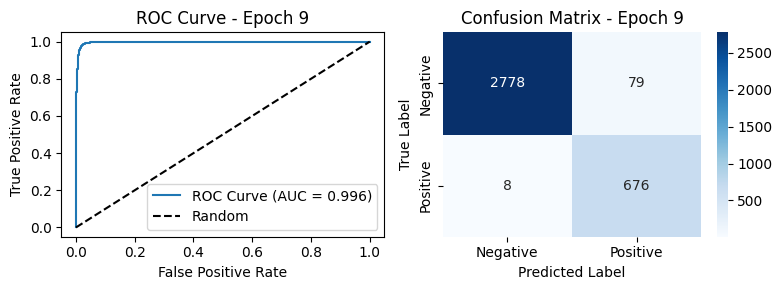

Epoch Number 9


100%|██████████| 498/498 [00:13<00:00, 36.59it/s]

Epoch 10/10 - Loss: 0.7772
Testing


The ROC AUC score is: 0.9958187236847222
The F1 score is: [0.98584572 0.94405594]   0.9649508311928694


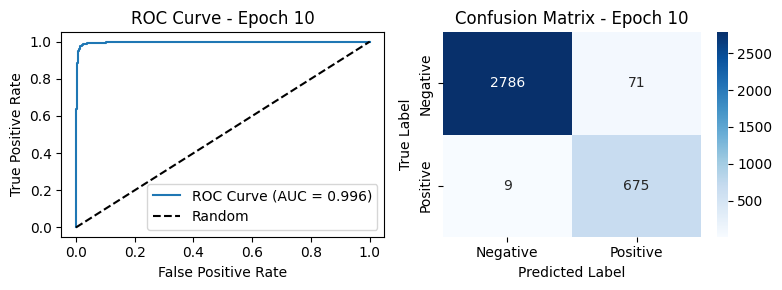

In [26]:
train(train_loader1,val_loader1,model3,criterion3,optimizer3,10,scheduler3)

The ROC AUC score is: 0.9664341774904613
The F1 score is: [0.9847684  0.34490482]   0.6648366084115114


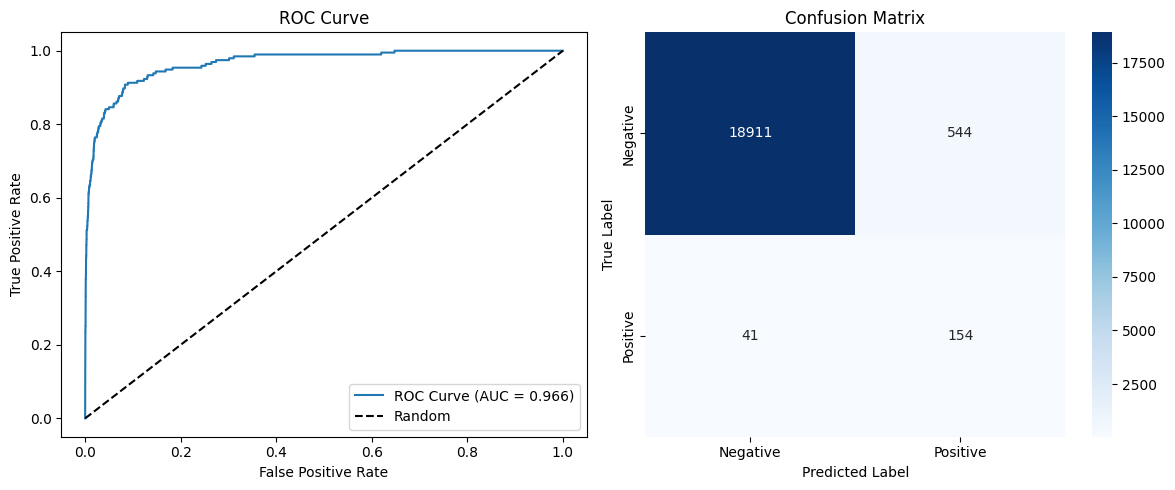

In [27]:
t4,p4,roc4=test_model(test_loader0,model3)
torch.save(model3.state_dict(),"Smotedata.pth")

# Adding augmentations

In [28]:
train_augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),  
    A.VerticalFlip(p=0.5),  
    A.Rotate(limit=180, p=0.7),  
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  
    A.RandomGamma(gamma_limit=(90, 110), p=0.5),  
    A.Blur(blur_limit=(3, 7), p=0.2),  
    ToTensorV2()
])
viz_augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),  
    A.VerticalFlip(p=0.5),  
    A.Rotate(limit=180, p=0.7),  
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  
    A.RandomGamma(gamma_limit=(90, 110), p=0.5),  
    A.Blur(blur_limit=(3, 7), p=0.2),  
])
basic_transforms = A.Compose([
    ToTensorV2(),
])

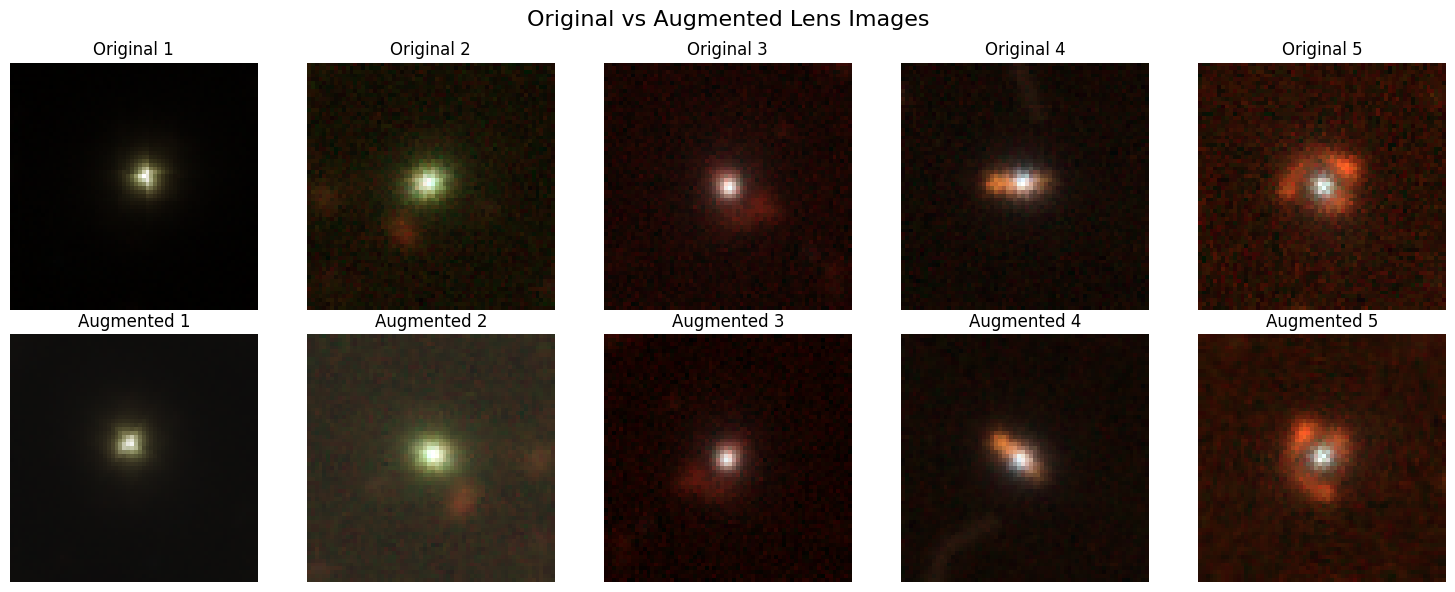

In [29]:
lens_dir = "/kaggle/working/train_lenses"
lens_files = [f for f in os.listdir(lens_dir) if f.endswith('.npy')]
num_samples = 5
lens_sample = random.sample(lens_files, min(num_samples, len(lens_files)))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, filename in enumerate(lens_sample):
    img_path = os.path.join(lens_dir, filename)
    img = np.load(img_path).transpose(2,1,0)
    if img.dtype != np.float32:
        img = img.astype(np.float32)
    axes[0, i].imshow(img, cmap='viridis')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')
    
    aug_img = viz_augmentations(image=img)['image']
    
    axes[1, i].imshow(aug_img, cmap='viridis')
    axes[1, i].set_title(f"Augmented {i+1}")
    axes[1, i].axis('off')

plt.suptitle("Original vs Augmented Lens Images", fontsize=16)
plt.tight_layout()
plt.show()

In [30]:
train_aug_lenses=LensDataset("/kaggle/working/train_lenses",label=1,augment=True)
train_dataset2=ConcatDataset([train_aug_lenses,train_dataset0])
train_size = int(0.9 * len(train_dataset2))
val_size = len(train_dataset2) - train_size
train_dataset22, val_dataset2 = random_split(train_dataset2, [train_size, val_size])
train_loader2 = DataLoader(train_dataset22, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size, shuffle=False, num_workers=4)

In [31]:
model4=timm.create_model("resnet18",pretrained=True,num_classes=2)
model4.to(device)
optimizer4 = optim.AdamW(model4.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler4 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer4, T_0=5, T_mult=2, eta_min=1e-6)
criterion4=nn.CrossEntropyLoss(weight=class_weights).to(device)

Epoch Number 0


100%|██████████| 452/452 [00:13<00:00, 33.60it/s]

Epoch 1/10 - Loss: 0.2536
Testing


The ROC AUC score is: 0.9768902001987326
The F1 score is: [0.88609553 0.53142403]   0.708759779118199


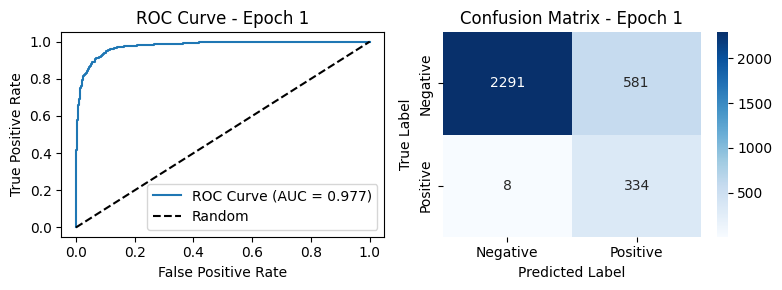

Epoch Number 1


100%|██████████| 452/452 [00:13<00:00, 34.05it/s]


Epoch 2/10 - Loss: 0.4439
Testing
The ROC AUC score is: 0.9818585169981593
The F1 score is: [0.91912179 0.6078253 ]   0.7634735410874384


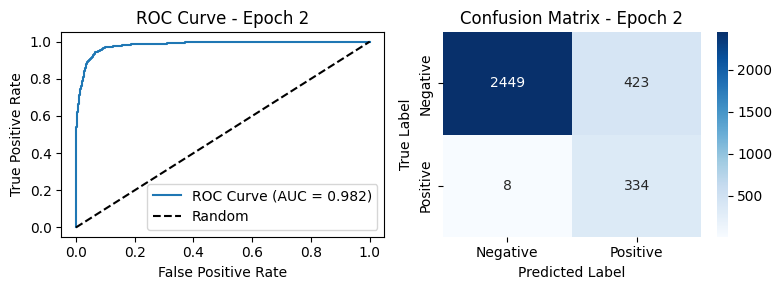

Epoch Number 2


100%|██████████| 452/452 [00:13<00:00, 33.44it/s]

Epoch 3/10 - Loss: 0.5949
Testing


The ROC AUC score is: 0.968303564156445
The F1 score is: [0.94418096 0.67653277]   0.8103568627057764


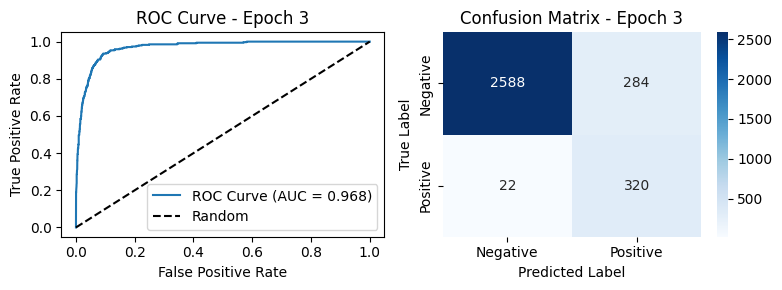

Epoch Number 3


100%|██████████| 452/452 [00:13<00:00, 34.13it/s]

Epoch 4/10 - Loss: 0.7532
Testing


The ROC AUC score is: 0.9815815944224536
The F1 score is: [0.94227598 0.67559217]   0.8089340744141964


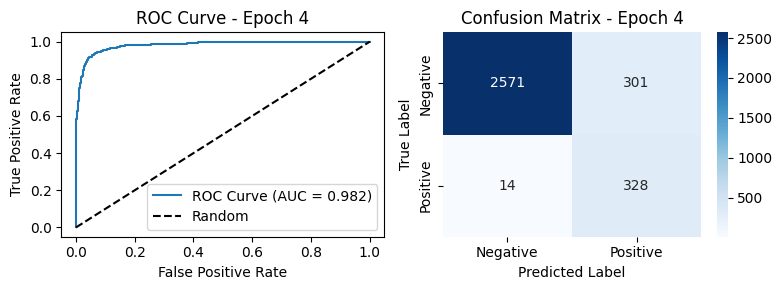

Epoch Number 4


100%|██████████| 452/452 [00:13<00:00, 33.66it/s]

Epoch 5/10 - Loss: 0.8605
Testing


The ROC AUC score is: 0.9892549968235352
The F1 score is: [0.95727734 0.73893805]   0.8481076941808232


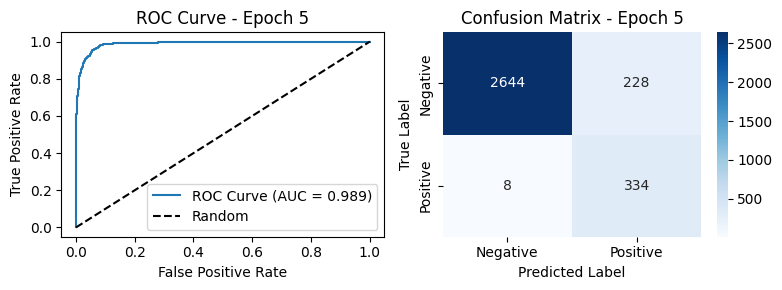

Epoch Number 5


100%|██████████| 452/452 [00:13<00:00, 32.39it/s]

Epoch 6/10 - Loss: 0.9626
Testing


The ROC AUC score is: 0.9799231132613334
The F1 score is: [0.93483478 0.65084075]   0.7928377655645752


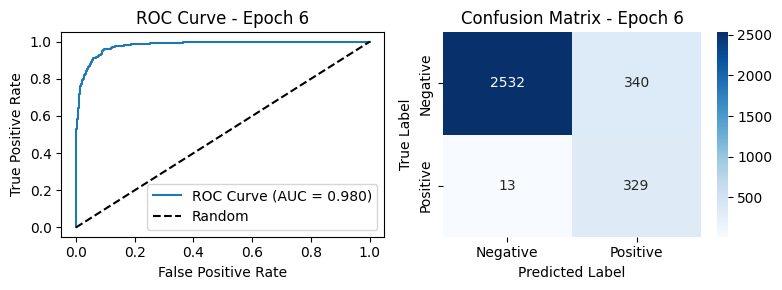

Epoch Number 6


100%|██████████| 452/452 [00:13<00:00, 33.45it/s]

Epoch 7/10 - Loss: 1.1030
Testing


The ROC AUC score is: 0.9858514961963869
The F1 score is: [0.9600432  0.74541284]   0.852728020290487


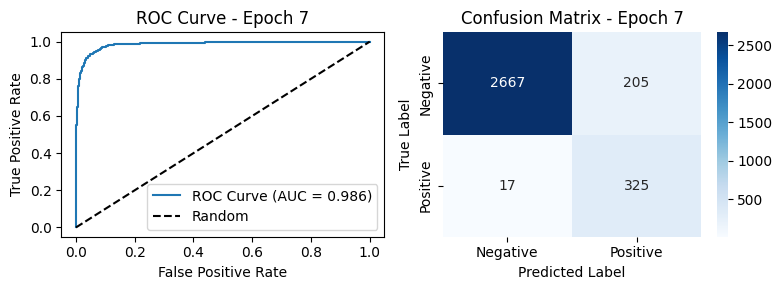

Epoch Number 7


100%|██████████| 452/452 [00:13<00:00, 33.99it/s]

Epoch 8/10 - Loss: 1.2061
Testing


The ROC AUC score is: 0.9885026226196876
The F1 score is: [0.96056186 0.74971429]   0.8551380720845875


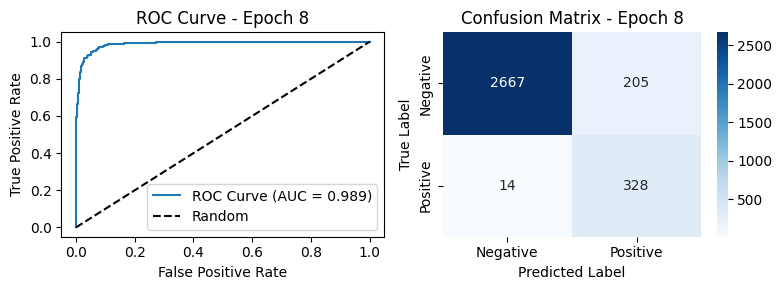

Epoch Number 8


100%|██████████| 452/452 [00:13<00:00, 33.45it/s]

Epoch 9/10 - Loss: 1.2905
Testing


The ROC AUC score is: 0.9886207219534443
The F1 score is: [0.97899382 0.8440367 ]   0.9115152594799873


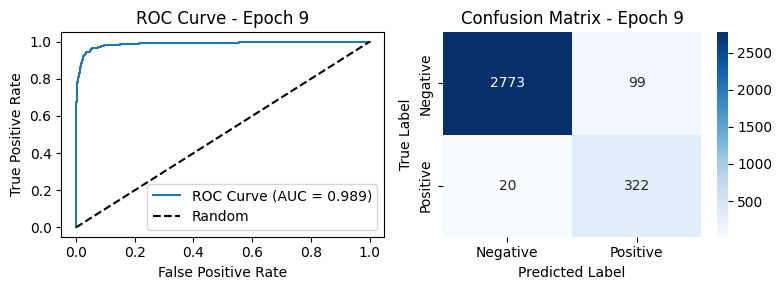

Epoch Number 9


100%|██████████| 452/452 [00:13<00:00, 34.05it/s]

Epoch 10/10 - Loss: 1.3473
Testing


The ROC AUC score is: 0.9904726416784766
The F1 score is: [0.97531522 0.82559598]   0.9004556021325754


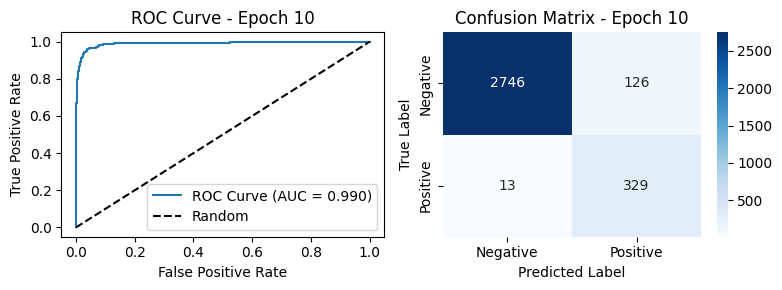

In [32]:
train(train_loader2,val_loader2,model4,criterion4,optimizer4,10,scheduler4)

The ROC AUC score is: 0.9672485485901061
The F1 score is: [0.97525833 0.25730071]   0.6162795193166173


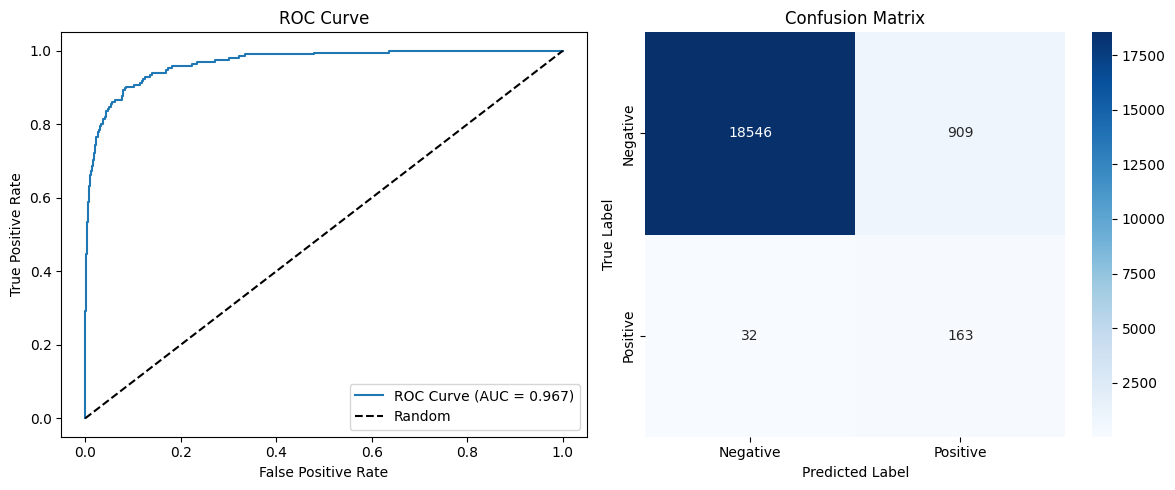

In [33]:
t5,p5,roc5=test_model(test_loader0,model4)
torch.save(model4.state_dict(),"AugmentedData.pth")

# Using resnet34 instead of resnet18

In [34]:
model5=timm.create_model("resnet34",pretrained=True,num_classes=2)
model5.to(device)
optimizer5 = optim.AdamW(model5.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler5 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer5, T_0=5, T_mult=2, eta_min=1e-6)
criterion5=nn.CrossEntropyLoss(weight=class_weights).to(device)

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch Number 0


100%|██████████| 452/452 [00:19<00:00, 23.33it/s]

Epoch 1/10 - Loss: 0.2566
Testing


The ROC AUC score is: 0.972499144797928
The F1 score is: [0.91084246 0.58377425]   0.7473083568033827


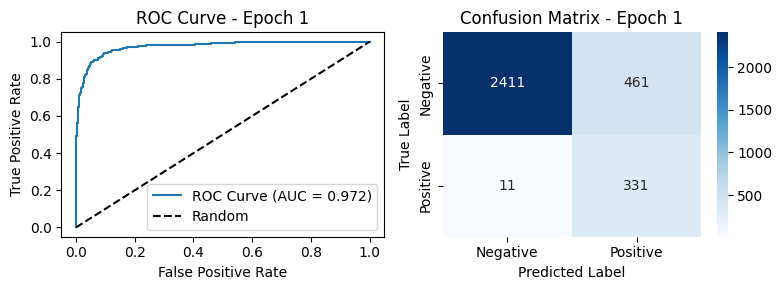

Epoch Number 1


100%|██████████| 452/452 [00:19<00:00, 23.50it/s]

Epoch 2/10 - Loss: 0.4318
Testing


The ROC AUC score is: 0.9806164377983027
The F1 score is: [0.91094725 0.58647937]   0.7487133084369617


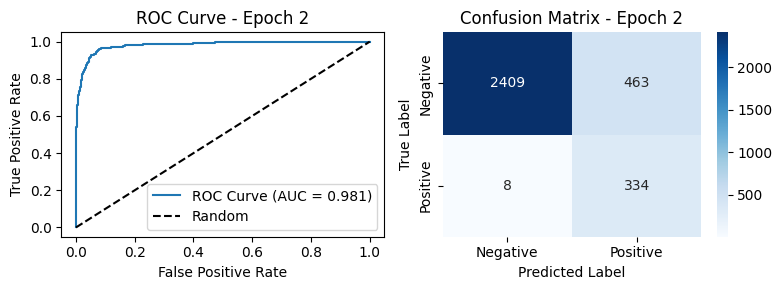

Epoch Number 2


100%|██████████| 452/452 [00:19<00:00, 23.63it/s]

Epoch 3/10 - Loss: 0.5850
Testing


The ROC AUC score is: 0.9870650686605092
The F1 score is: [0.93733874 0.66067864]   0.7990086910587229


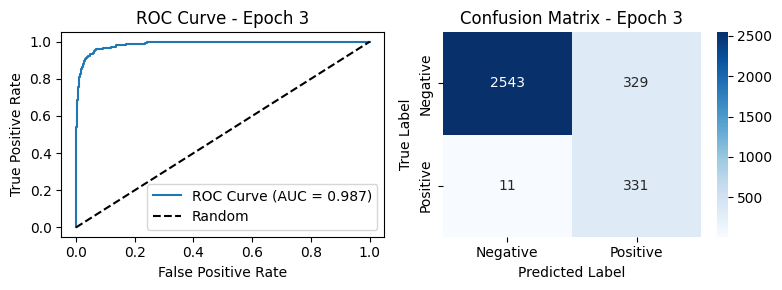

Epoch Number 3


100%|██████████| 452/452 [00:19<00:00, 23.48it/s]

Epoch 4/10 - Loss: 0.7230
Testing


The ROC AUC score is: 0.9873949323168646
The F1 score is: [0.94428152 0.6872428 ]   0.8157621616402978


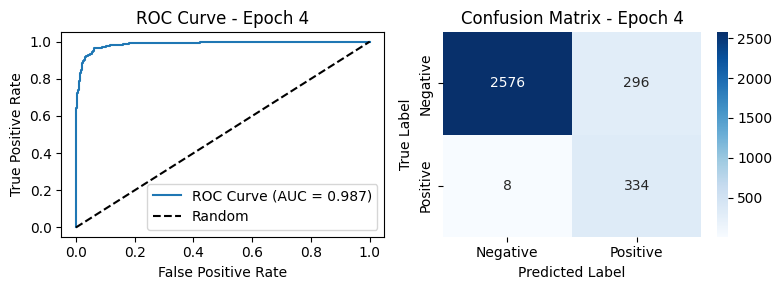

Epoch Number 4


100%|██████████| 452/452 [00:19<00:00, 23.54it/s]

Epoch 5/10 - Loss: 0.8456
Testing


The ROC AUC score is: 0.9786484549349231
The F1 score is: [0.86959937 0.50299401]   0.6862966917696423


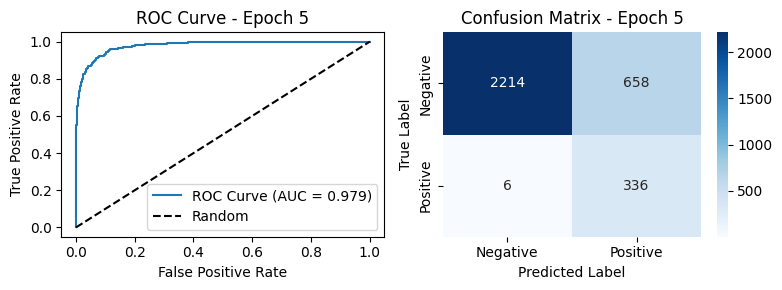

Epoch Number 5


100%|██████████| 452/452 [00:19<00:00, 23.58it/s]

Epoch 6/10 - Loss: 0.9577
Testing


The ROC AUC score is: 0.9892061281337047
The F1 score is: [0.97923266 0.84182306]   0.9105278604275011


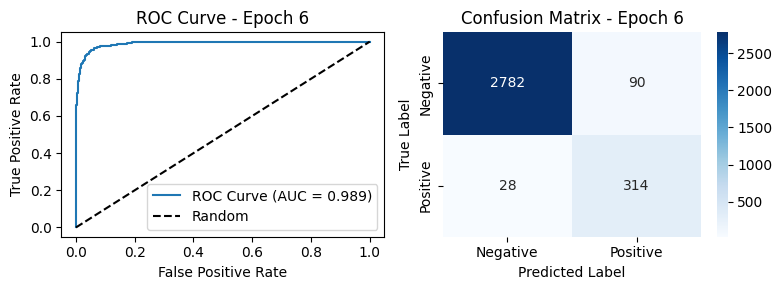

Epoch Number 6


100%|██████████| 452/452 [00:19<00:00, 23.35it/s]

Epoch 7/10 - Loss: 1.0611
Testing


The ROC AUC score is: 0.9859431249898188
The F1 score is: [0.9570242  0.73258427]   0.8448042330618688


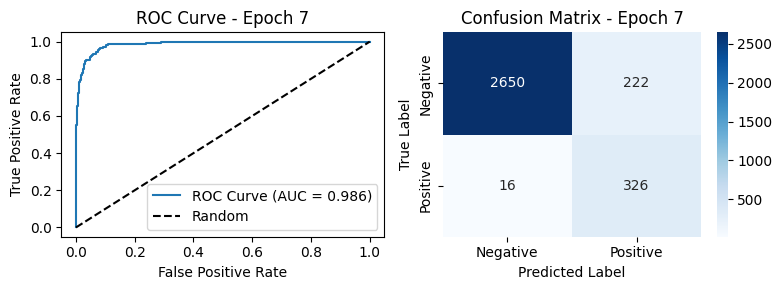

Epoch Number 7


100%|██████████| 452/452 [00:19<00:00, 23.46it/s]

Epoch 8/10 - Loss: 1.1592
Testing


The ROC AUC score is: 0.9888711739888254
The F1 score is: [0.9661351 0.7768595]   0.8714973026842845


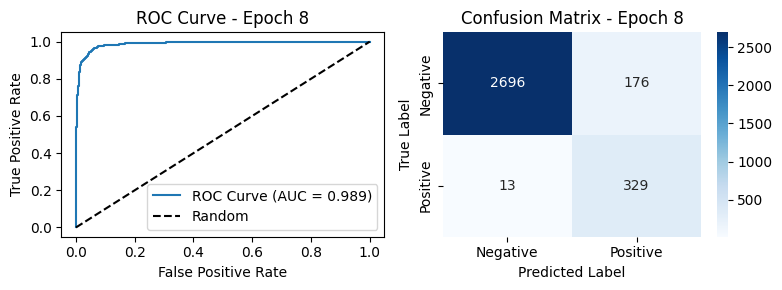

Epoch Number 8


100%|██████████| 452/452 [00:19<00:00, 23.48it/s]

Epoch 9/10 - Loss: 1.2511
Testing


The ROC AUC score is: 0.9905225284660117
The F1 score is: [0.97437722 0.82178218]   0.8980797012085551


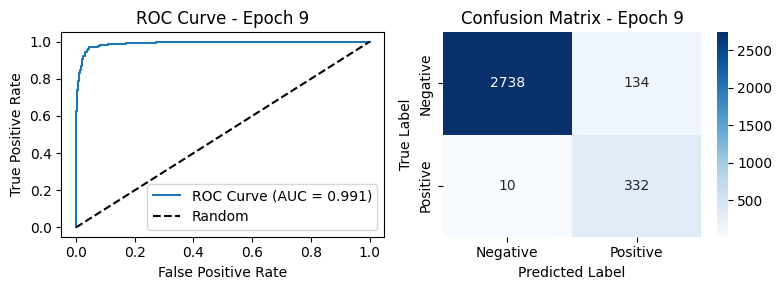

Epoch Number 9


100%|██████████| 452/452 [00:19<00:00, 23.43it/s]

Epoch 10/10 - Loss: 1.3357
Testing


The ROC AUC score is: 0.9882664239521738
The F1 score is: [0.94740687 0.69747899]   0.822442928961212


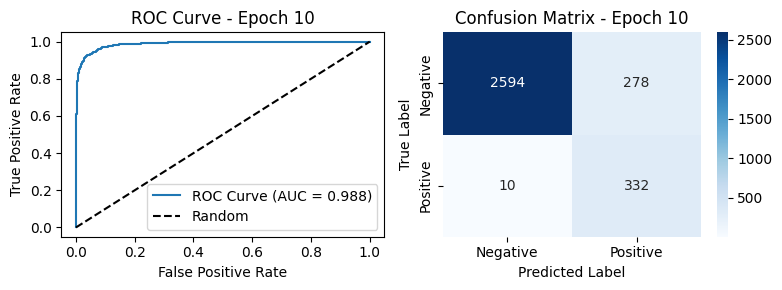

In [35]:
train(train_loader2,val_loader2,model5,criterion5,optimizer5,10,scheduler4)

The ROC AUC score is: 0.961083367929937
The F1 score is: [0.94639476 0.14789338]   0.5471440715399415


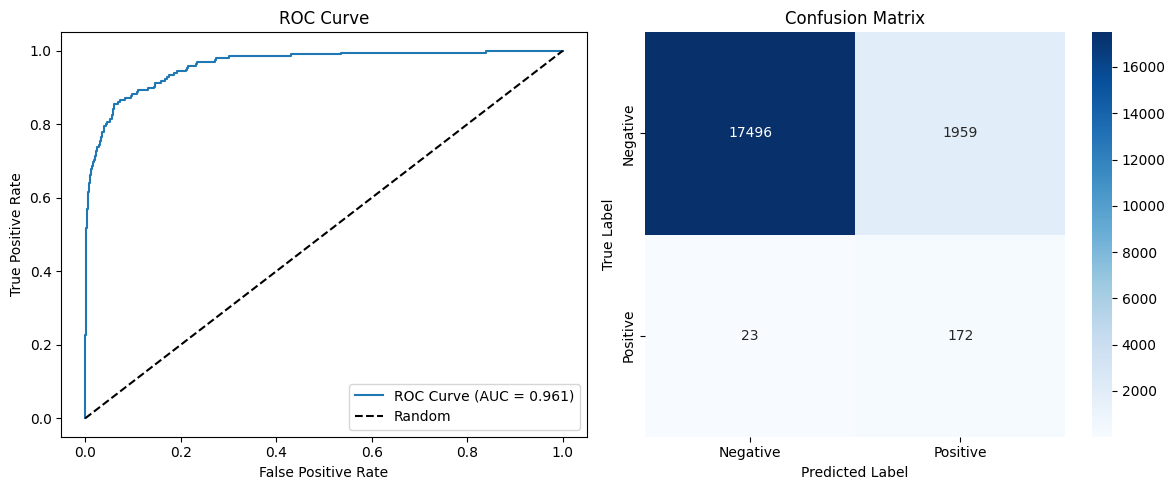

In [36]:
t6,p6,roc6=test_model(test_loader0,model5)
torch.save(model5.state_dict(),"resnet34.pth")

# Using Complement CrossEntropy Loss

In [37]:
class CCE(nn.Module):
    def __init__(self, device, balancing_factor=1.0):
        super(CCE, self).__init__()
        self.nll_loss = nn.NLLLoss()
        self.device = device 
        self.balancing_factor = balancing_factor

    def forward(self, yHat, y):
        batch_size = y.shape[0]
        num_classes = yHat.shape[1]
        cross_entropy = self.nll_loss(F.log_softmax(yHat, dim=1), y)
        yHat = F.softmax(yHat, dim=1)
        Yg = yHat.gather(dim=1, index=y.view(-1, 1))
        Px = yHat / (1 - Yg + 1e-8)  
        Px_log = torch.log(Px + 1e-8) 
        y_zerohot = torch.ones(batch_size, num_classes, device=self.device)
        y_zerohot.scatter_(1, y.view(batch_size, 1), 0)
        output = Px * Px_log * y_zerohot
        complement_entropy = torch.sum(output) / (batch_size * num_classes)

        return cross_entropy - self.balancing_factor * complement_entropy

In [38]:
model6=timm.create_model("resnet18",pretrained=True,num_classes=2)
model6.to(device)
optimizer6 = optim.AdamW(model6.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler6 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer6, T_0=5, T_mult=2, eta_min=1e-6)
criterion6=CCE("cuda")

Epoch Number 0


100%|██████████| 452/452 [00:13<00:00, 33.02it/s]

Epoch 1/10 - Loss: 0.1566
Testing


The ROC AUC score is: 0.9775692713678347
The F1 score is: [0.9760749  0.79090909]   0.8834919934434498


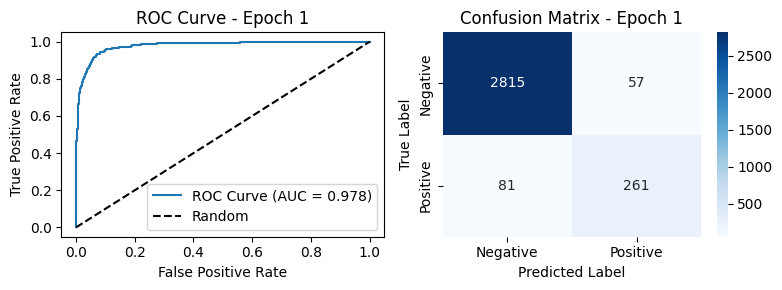

Epoch Number 1


100%|██████████| 452/452 [00:13<00:00, 33.13it/s]

Epoch 2/10 - Loss: 0.3339
Testing


The ROC AUC score is: 0.9270868966753002
The F1 score is: [0.95344309 0.66238768]   0.8079153818902138


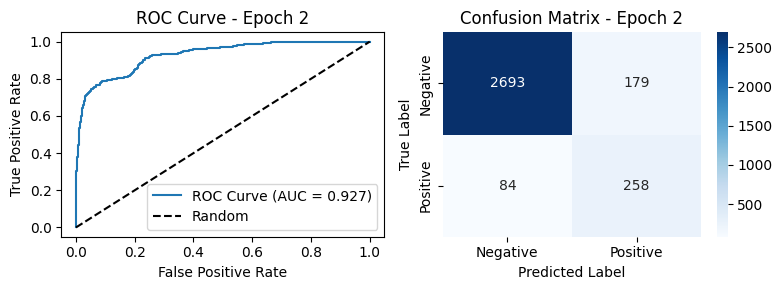

Epoch Number 2


100%|██████████| 452/452 [00:13<00:00, 32.94it/s]

Epoch 3/10 - Loss: 0.9544
Testing


The ROC AUC score is: 0.8235107266774178
The F1 score is: [0.94371297 0.02840909]   0.48606102998384104


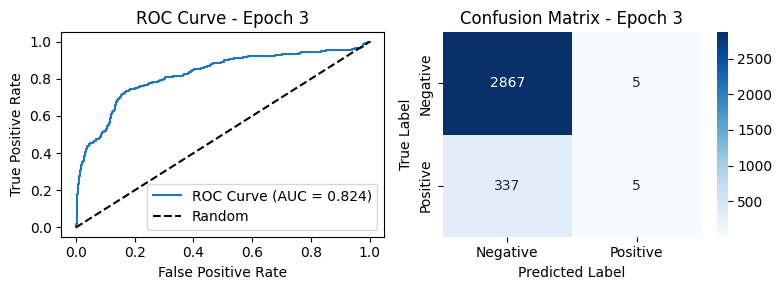

Epoch Number 3


100%|██████████| 452/452 [00:13<00:00, 33.00it/s]

Epoch 4/10 - Loss: 1.1680
Testing


The ROC AUC score is: 0.9496285979572888
The F1 score is: [0.96504689 0.63587922]   0.8004630533965074


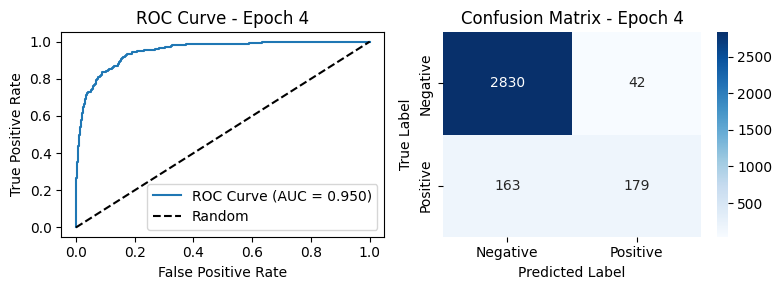

Epoch Number 4


100%|██████████| 452/452 [00:13<00:00, 32.91it/s]

Epoch 5/10 - Loss: 1.3488
Testing


The ROC AUC score is: 0.9545134307449218
The F1 score is: [0.96623822 0.66779089]   0.8170145557063195


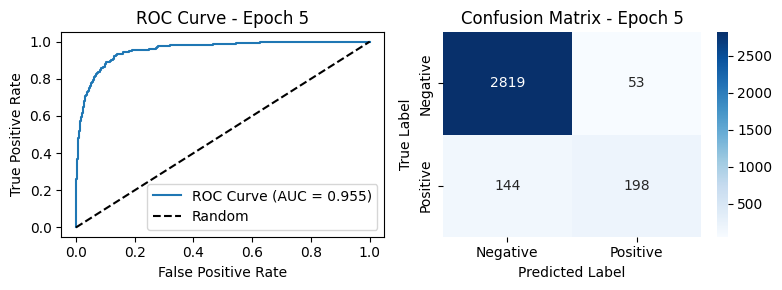

Epoch Number 5


100%|██████████| 452/452 [00:13<00:00, 33.28it/s]

Epoch 6/10 - Loss: 1.5214
Testing


The ROC AUC score is: 0.955538655133656
The F1 score is: [0.96569293 0.62592593]   0.7958094303542673


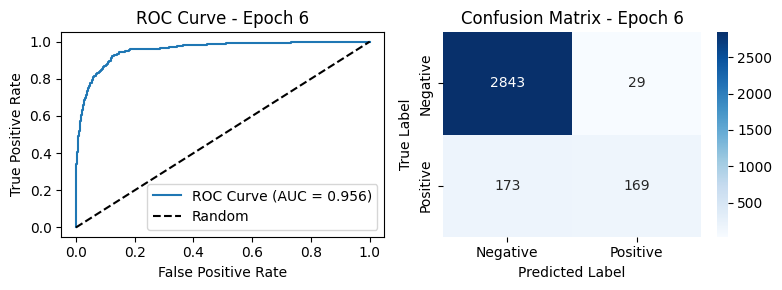

Epoch Number 6


100%|██████████| 452/452 [00:13<00:00, 32.80it/s]

Epoch 7/10 - Loss: 1.6857
Testing


The ROC AUC score is: 0.9679899900633663
The F1 score is: [0.96834136 0.7012987 ]   0.8348200319982839


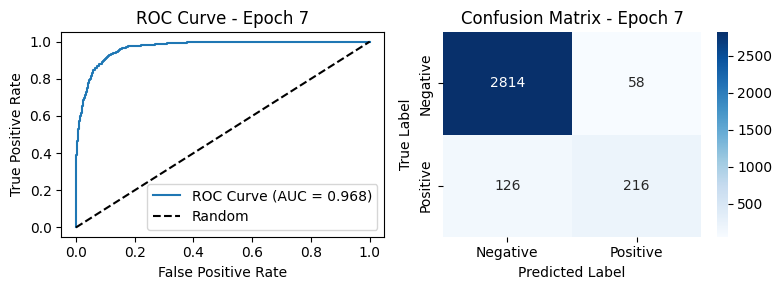

Epoch Number 7


100%|██████████| 452/452 [00:13<00:00, 33.05it/s]

Epoch 8/10 - Loss: 2.0816
Testing


The ROC AUC score is: 0.8503330197592402
The F1 score is: [0.95351569 0.40938166]   0.6814486768325563


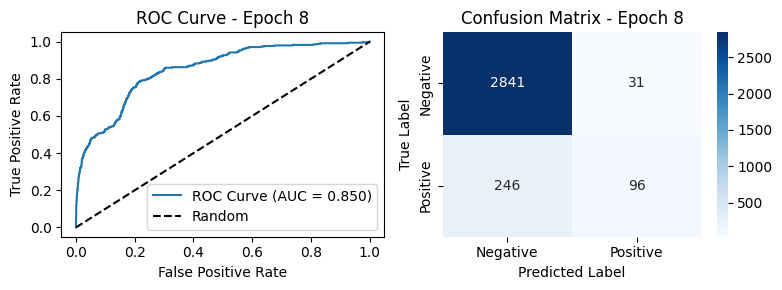

Epoch Number 8


100%|██████████| 452/452 [00:13<00:00, 32.91it/s]

Epoch 9/10 - Loss: 2.3745
Testing


The ROC AUC score is: 0.8992780669175259
The F1 score is: [0.95640373 0.51782364]   0.7371136858755551


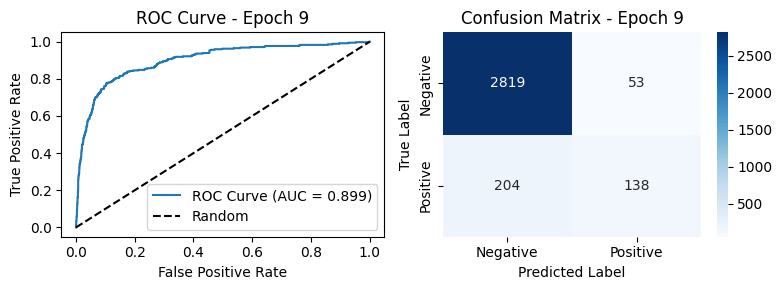

Epoch Number 9


100%|██████████| 452/452 [00:13<00:00, 33.08it/s]


Epoch 10/10 - Loss: 2.5933
Testing
The ROC AUC score is: 0.9224677873886201
The F1 score is: [0.95867486 0.57692308]   0.7677989701555274


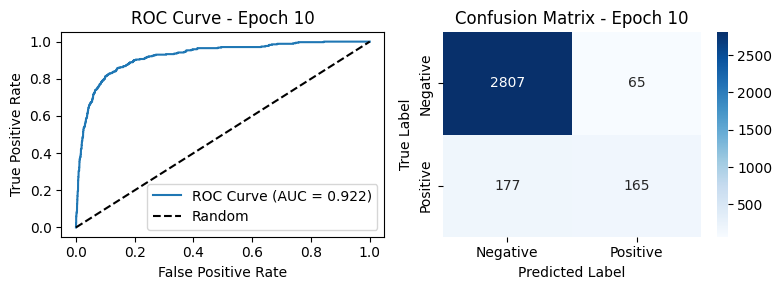

In [39]:
train(train_loader2,val_loader2,model6,criterion6,optimizer6,10,scheduler6)

The ROC AUC score is: 0.8646337043407205
The F1 score is: [0.98467602 0.19372442]   0.5892002192743296


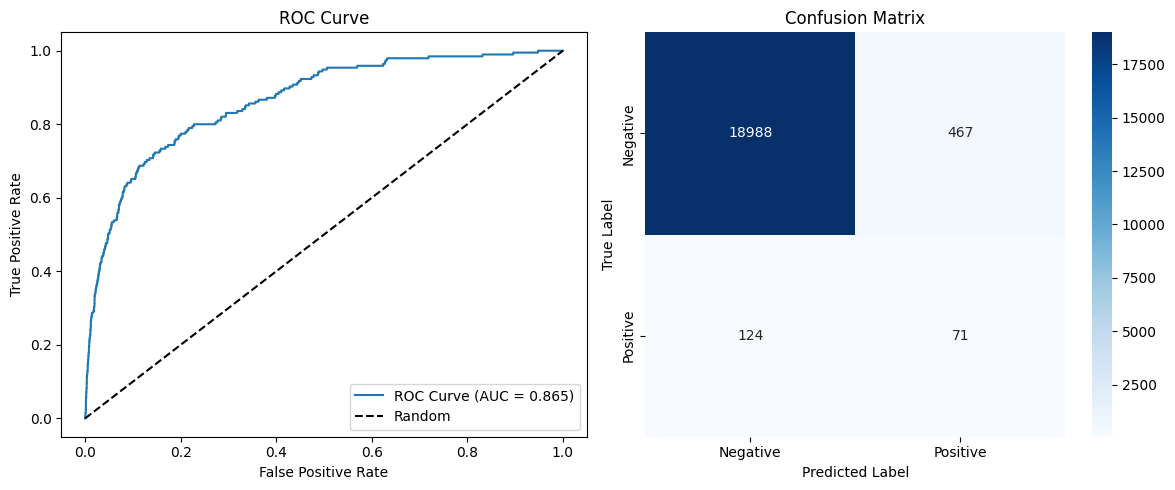

In [40]:
t7,p7,roc7=test_model(test_loader0,model6)
torch.save(model6.state_dict(),"resnet18_CCEloss.pth")

# Using Stratified Kfolds splits + augmentations and taking their ensemble

In [52]:
def validate_model(val_loader, model, criterion):
    model.eval()  
    val_loss = 0
    pred_list = []
    true_list = []
    prob_list = []

    with torch.no_grad():
        for x, y in tqdm(val_loader):
            x, y = x.to(device), y.to(device)
            batch = x.shape[0]
            x = x.view(batch, 3, 64, 64)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
            probs = torch.softmax(out, dim=1)[:, 1] 
            preds = (probs >= 0.5).long()  
            pred_list.extend(preds.cpu().numpy())
            true_list.extend(y.cpu().numpy())
            prob_list.extend(probs.cpu().numpy())
    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss, np.array(pred_list), np.array(true_list), np.array(prob_list)

In [57]:
def get_labels(dataset):
    labels = []
    for _, label in dataset:
        labels.append(label)
    return labels
def train_kfold(dataset, model_name, epochs, k, batch_size):
    all_targets = get_labels(dataset)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    ensemble_models = {}
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(range(len(all_targets)), all_targets)):
        print(f"\n===== Fold {fold+1}/{k} =====")
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = timm.create_model(model_name, pretrained=True, num_classes=2).to(device)
        
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        num_lensed=3460
        num_nonlensed=28675
        total=num_lensed+num_nonlensed
        weight_lensed=total/(2*num_lensed)
        weight_nonlensed=total/(2*num_nonlensed)
        class_weights=torch.tensor([weight_nonlensed, weight_lensed], dtype=torch.float32)
        criterion=nn.CrossEntropyLoss(weight=class_weights).to(device)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

        best_model_path = f'best_model_fold_{fold+1}.pth'
        best_loss = float('inf')

        for epoch in range(epochs):
            model.train()
            epoch_loss = 0

            for x, y in tqdm(train_loader):
                x, y = x.to(device), y.to(device)
                batch = x.shape[0]
                x = x.view(batch, 3, 64, 64)
                
                out = model(x)
                optimizer.zero_grad()
                out = out.to(device)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                scheduler.step()
                epoch_loss += loss.item()
            
            avg_loss = epoch_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
            val_loss, pred_list, true_list, prob_list = validate_model(val_loader, model, criterion)
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            fpr, tpr, _ = roc_curve(true_list, prob_list)
            roc_auc = roc_auc_score(true_list, prob_list)
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - Fold {fold+1}, Epoch {epoch+1}')
            plt.legend()
            plt.subplot(1, 2, 2)
            cm = confusion_matrix(true_list, (np.array(prob_list) >= 0.5).astype(int))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                        xticklabels=["Negative", "Positive"], 
                        yticklabels=["Negative", "Positive"])
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title(f'Confusion Matrix - Fold {fold+1}, Epoch {epoch+1}')
            plt.tight_layout()
            plt.show()
            
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({
                    'fold': fold + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'best_loss': best_loss
                }, best_model_path)
                print(f"Best model for fold {fold+1} saved with loss: {best_loss:.4f}")
        ensemble_models[fold+1] = best_model_path
        
        _, pred_list, true_list, prob_list = validate_model(val_loader, model, criterion)
        
        fold_results.append({
            'predictions': pred_list,
            'true_labels': true_list,
            'probabilities': prob_list,
            'model_path': best_model_path
        })
    def ensemble_predict(test_loader):
        test_labels = []
        for _, labels in test_loader:
            test_labels.extend(labels.numpy())
        test_labels = np.array(test_labels)
    
        ensemble_preds = []
        all_test_preds = []
        
        for fold, model_path in ensemble_models.items():
            model = timm.create_model(model_name, pretrained=True, num_classes=2).to(device)
            checkpoint = torch.load(model_path, weights_only=True)
            model.load_state_dict(checkpoint)
            model.eval()
            fold_preds = []
            fold_probs = []
            with torch.no_grad():
                for x, _ in test_loader:
                    x = x.to(device)
                    batch = x.shape[0]
                    x = x.view(batch, 3, 64, 64)
                    
                    out = model(x)
                    prob = torch.softmax(out, dim=1)[:, 1]
                    fold_preds.extend((prob >= 0.5).cpu().numpy().astype(int))
                    fold_probs.extend(prob.cpu().numpy())
            
            ensemble_preds.append(fold_probs)
            all_test_preds.append(fold_preds)
        ensemble_probs = np.mean(ensemble_preds, axis=0)
        ensemble_preds = (ensemble_probs >= 0.5).astype(int)
        plt.figure(figsize=(15, 5 * len(ensemble_models)))
        
        for fold, (fold_preds, fold_probs) in enumerate(zip(all_test_preds, ensemble_preds), 1):
            plt.subplot(len(ensemble_models), 2, 2*fold-1)
            fpr, tpr, _ = roc_curve(test_labels, fold_probs)
            roc_auc = roc_auc_score(test_labels, fold_probs)
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - Fold {fold}')
            plt.legend()
            plt.subplot(len(ensemble_models), 2, 2*fold)
            cm = confusion_matrix(test_labels, fold_preds)
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                        xticklabels=["Negative", "Positive"], 
                        yticklabels=["Negative", "Positive"])
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title(f'Confusion Matrix - Fold {fold}')
        
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(8, 3))
        
        plt.subplot(1, 2, 1)
        fpr, tpr, _ = roc_curve(test_labels, ensemble_probs)
        roc_auc = roc_auc_score(test_labels, ensemble_probs)
        plt.plot(fpr, tpr, label=f'Ensemble ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Ensemble ROC Curve')
        plt.legend()
    
        plt.subplot(1, 2, 2)
        cm = confusion_matrix(test_labels, ensemble_preds)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=["Negative", "Positive"], 
                    yticklabels=["Negative", "Positive"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Ensemble Confusion Matrix")
        plt.tight_layout()
        plt.show()
        
        metrics = {
            'f1_score': f1_score(test_labels, ensemble_preds, average='macro'),
            'precision': precision_score(test_labels, ensemble_preds, average='macro'),
            'recall': recall_score(test_labels, ensemble_preds, average='macro'),
            'roc_auc': roc_auc
        }
        
        print("\n===== Ensemble Test Performance =====")
        for metric, value in metrics.items():
            print(f"Ensemble {metric.replace('_', ' ').title()}: {value:.4f}")
        
        return ensemble_probs, ensemble_preds, metrics

    all_preds = np.concatenate([fold['predictions'] for fold in fold_results])
    all_true = np.concatenate([fold['true_labels'] for fold in fold_results])
    all_probs = np.concatenate([fold['probabilities'] for fold in fold_results])

    f1 = f1_score(all_true, (all_preds >= 0.5).astype(int), average='macro')
    roc_auc = roc_auc_score(all_true, all_probs)
    
    print("\n===== Final Model Performance =====")
    print(f"Ensemble F1 Score: {f1:.4f}")
    print(f"Ensemble ROC AUC Score: {roc_auc:.4f}")

    fpr, tpr, _ = roc_curve(all_true, all_probs)
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Final ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    cm = confusion_matrix(all_true, (all_probs >= 0.5).astype(int))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Negative", "Positive"], 
                yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Final Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return ensemble_predict, ensemble_models


===== Fold 1/5 =====


100%|██████████| 402/402 [00:34<00:00, 11.54it/s]


Epoch 1/10 - Loss: 0.2756


100%|██████████| 101/101 [00:06<00:00, 15.32it/s]


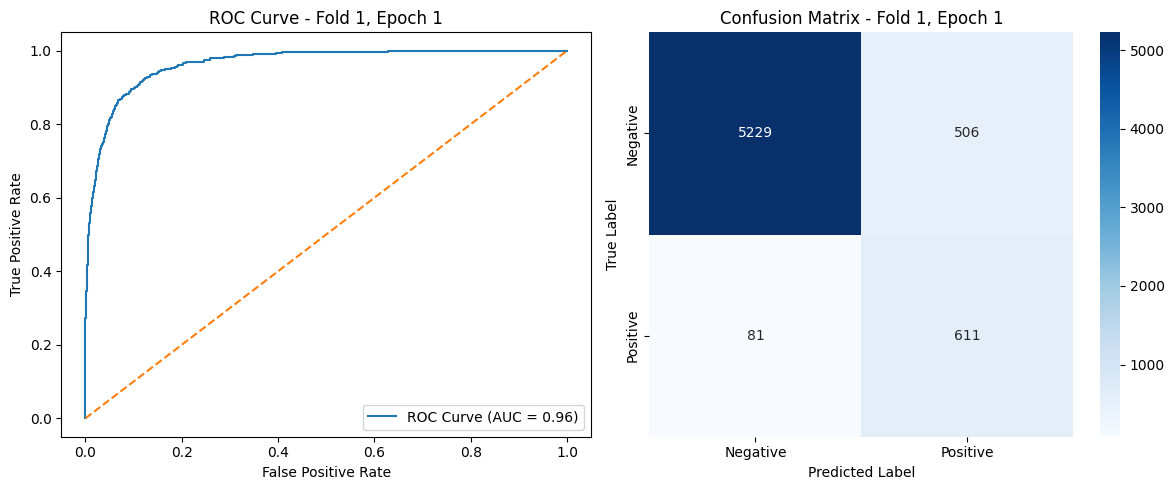

Best model for fold 1 saved with loss: 0.2554


100%|██████████| 402/402 [00:36<00:00, 11.00it/s]


Epoch 2/10 - Loss: 0.2108


100%|██████████| 101/101 [00:07<00:00, 14.33it/s]


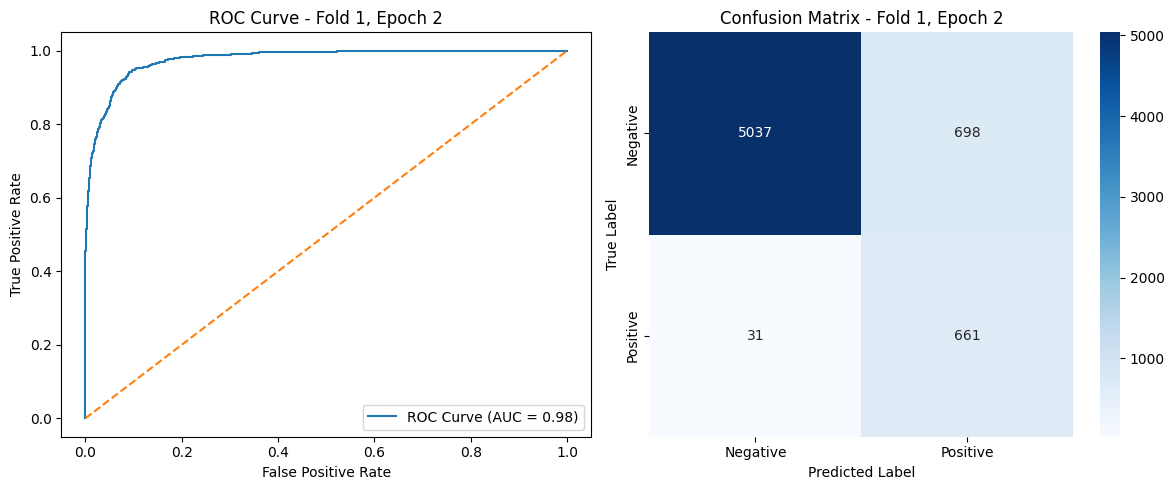

100%|██████████| 402/402 [00:36<00:00, 11.02it/s]


Epoch 3/10 - Loss: 0.1677


100%|██████████| 101/101 [00:07<00:00, 13.36it/s]


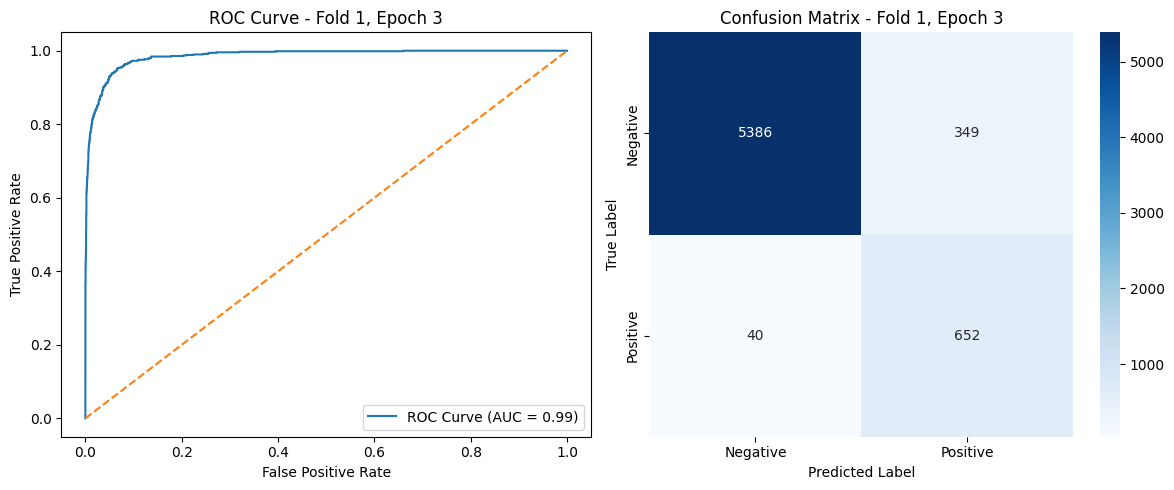

Best model for fold 1 saved with loss: 0.1449


100%|██████████| 402/402 [00:35<00:00, 11.41it/s]


Epoch 4/10 - Loss: 0.1741


100%|██████████| 101/101 [00:06<00:00, 14.45it/s]


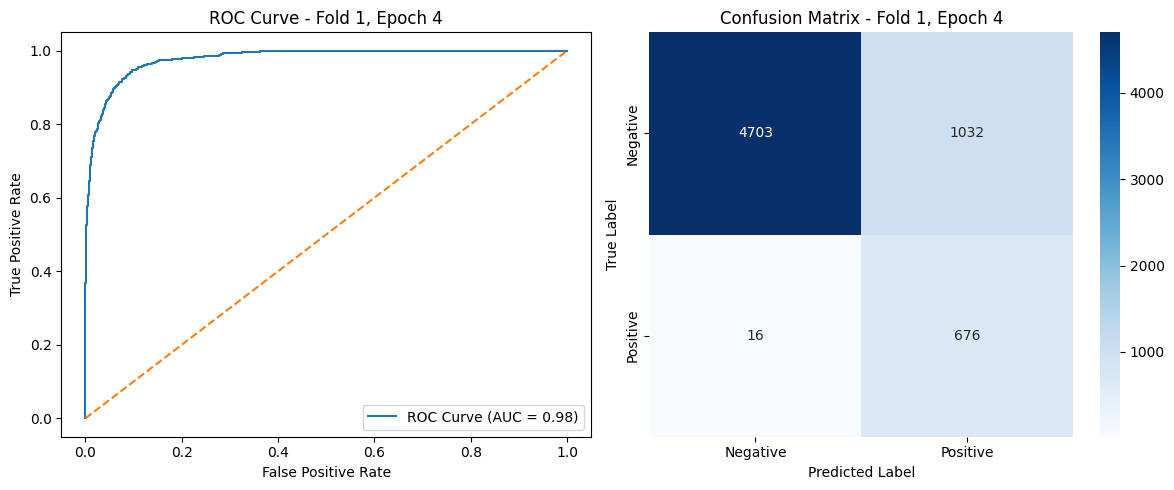

100%|██████████| 402/402 [00:35<00:00, 11.20it/s]


Epoch 5/10 - Loss: 0.1432


100%|██████████| 101/101 [00:06<00:00, 14.82it/s]


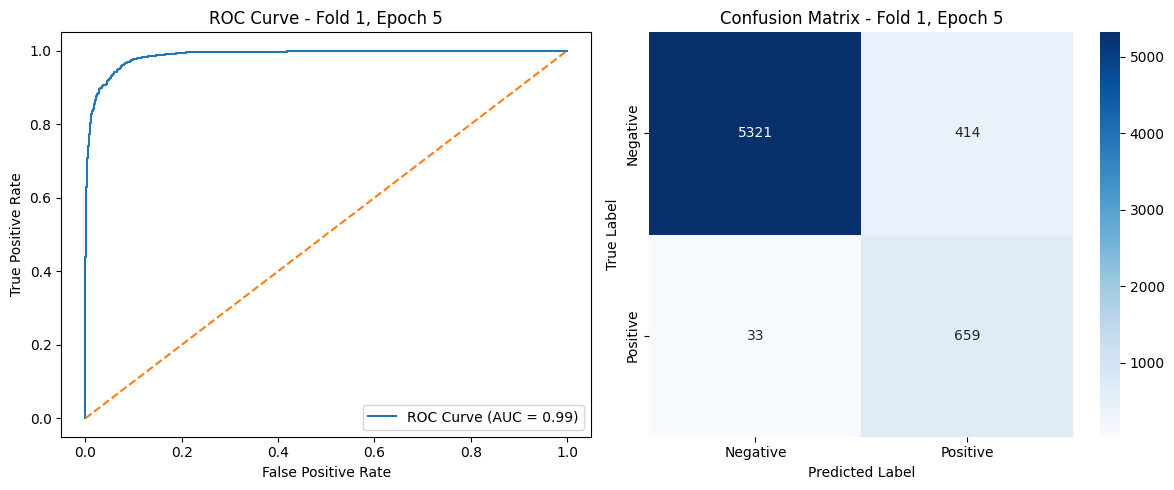

100%|██████████| 402/402 [00:37<00:00, 10.75it/s]


Epoch 6/10 - Loss: 0.0988


100%|██████████| 101/101 [00:06<00:00, 14.64it/s]


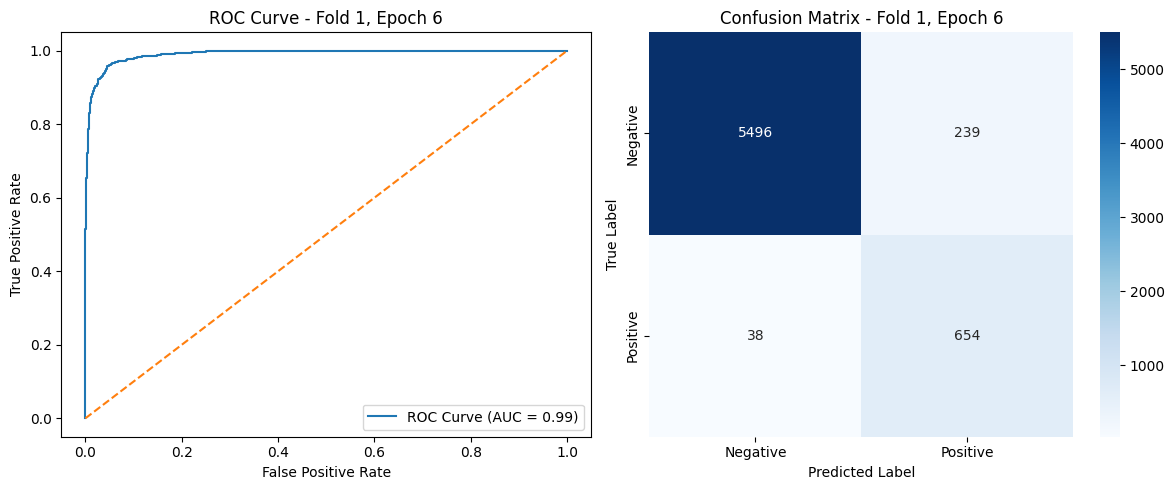

Best model for fold 1 saved with loss: 0.1109


100%|██████████| 402/402 [00:34<00:00, 11.58it/s]


Epoch 7/10 - Loss: 0.1269


100%|██████████| 101/101 [00:07<00:00, 14.34it/s]


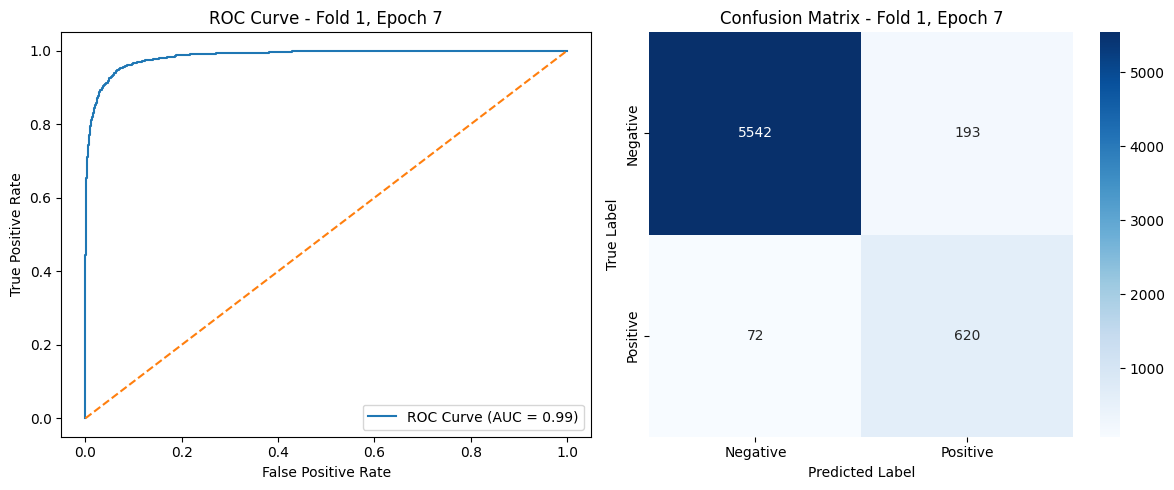

100%|██████████| 402/402 [00:35<00:00, 11.42it/s]


Epoch 8/10 - Loss: 0.1365


100%|██████████| 101/101 [00:06<00:00, 15.11it/s]


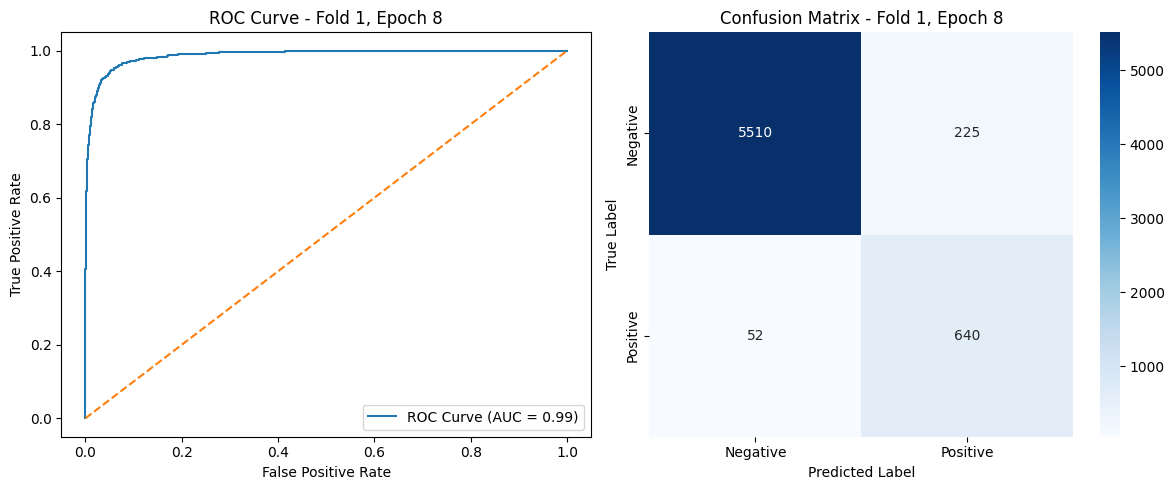

100%|██████████| 402/402 [00:35<00:00, 11.24it/s]


Epoch 9/10 - Loss: 0.1089


100%|██████████| 101/101 [00:06<00:00, 14.86it/s]


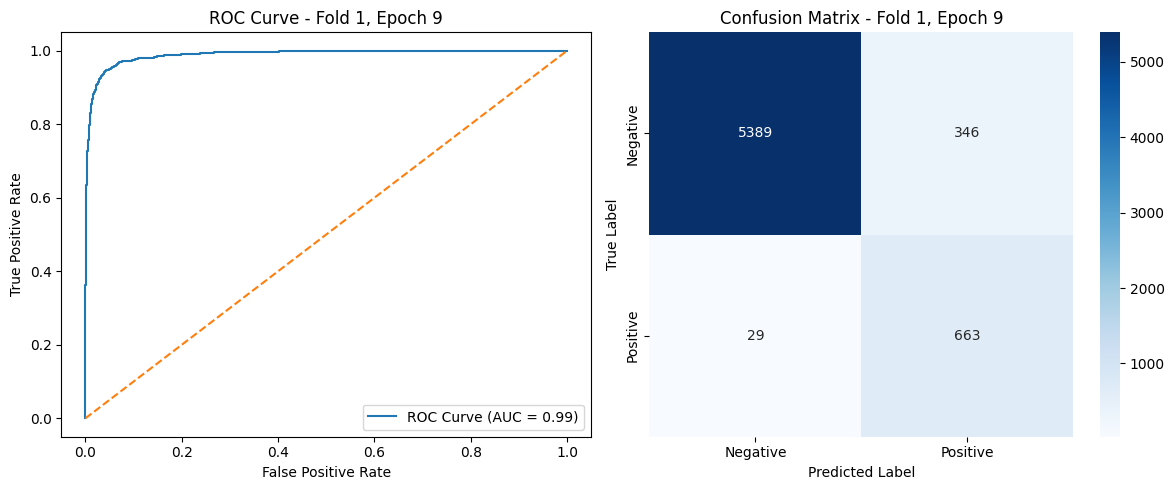

100%|██████████| 402/402 [00:34<00:00, 11.71it/s]


Epoch 10/10 - Loss: 0.0900


100%|██████████| 101/101 [00:07<00:00, 14.10it/s]


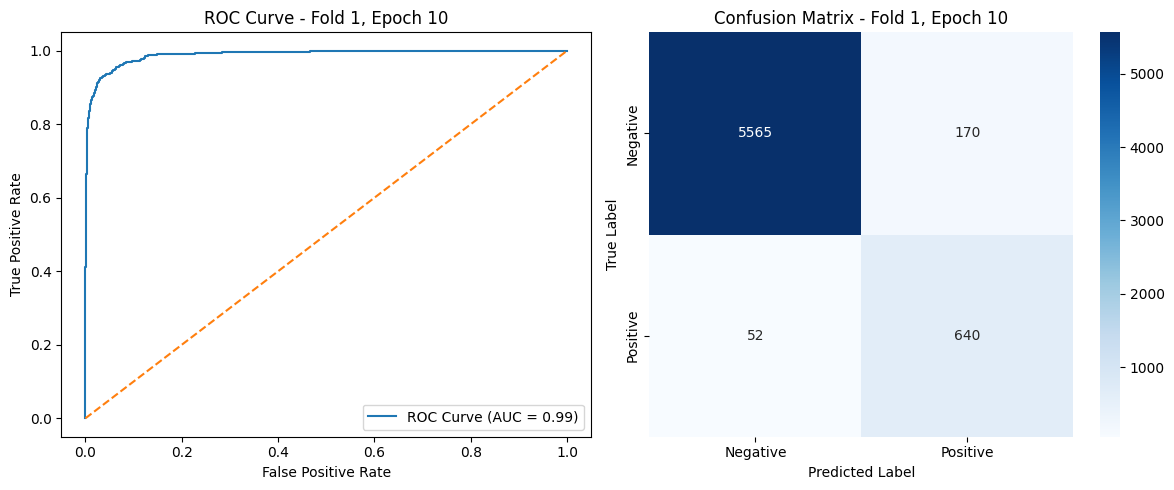

Best model for fold 1 saved with loss: 0.0879


100%|██████████| 101/101 [00:06<00:00, 15.07it/s]



===== Fold 2/5 =====


100%|██████████| 402/402 [00:34<00:00, 11.80it/s]


Epoch 1/10 - Loss: 0.2692


100%|██████████| 101/101 [00:06<00:00, 14.71it/s]


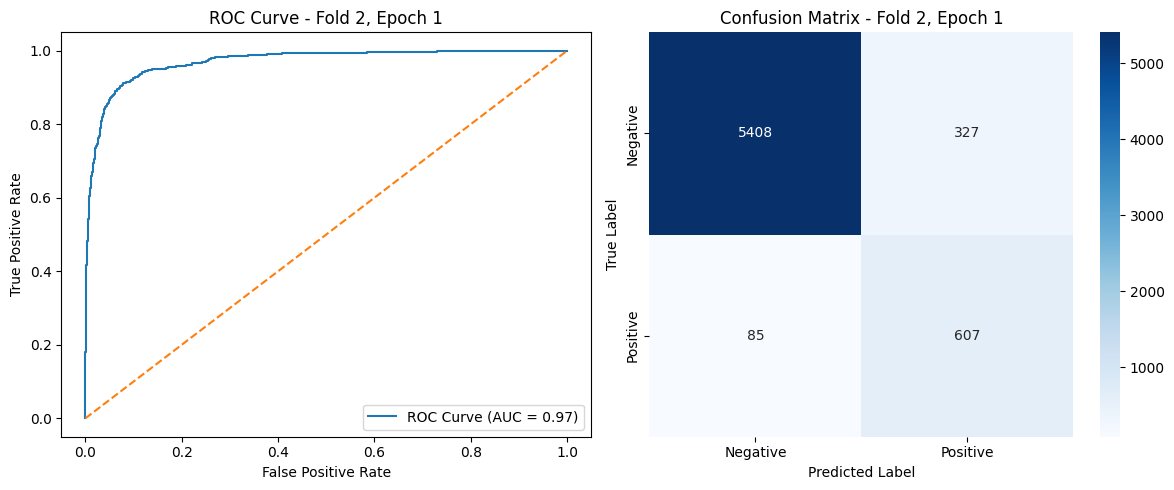

Best model for fold 2 saved with loss: 0.1844


100%|██████████| 402/402 [00:34<00:00, 11.52it/s]


Epoch 2/10 - Loss: 0.1966


100%|██████████| 101/101 [00:07<00:00, 14.25it/s]


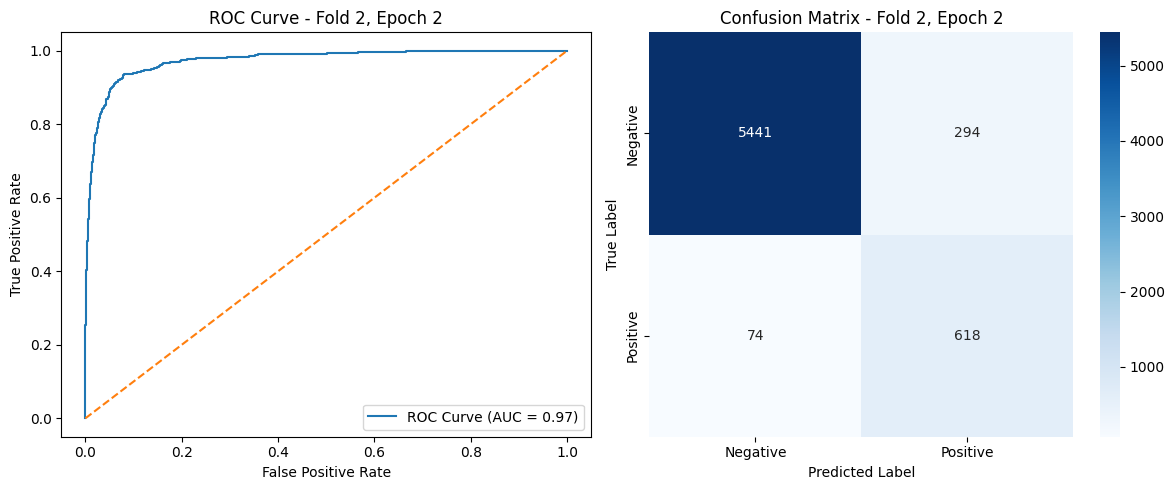

Best model for fold 2 saved with loss: 0.1806


100%|██████████| 402/402 [00:37<00:00, 10.74it/s]


Epoch 3/10 - Loss: 0.1517


100%|██████████| 101/101 [00:06<00:00, 15.18it/s]


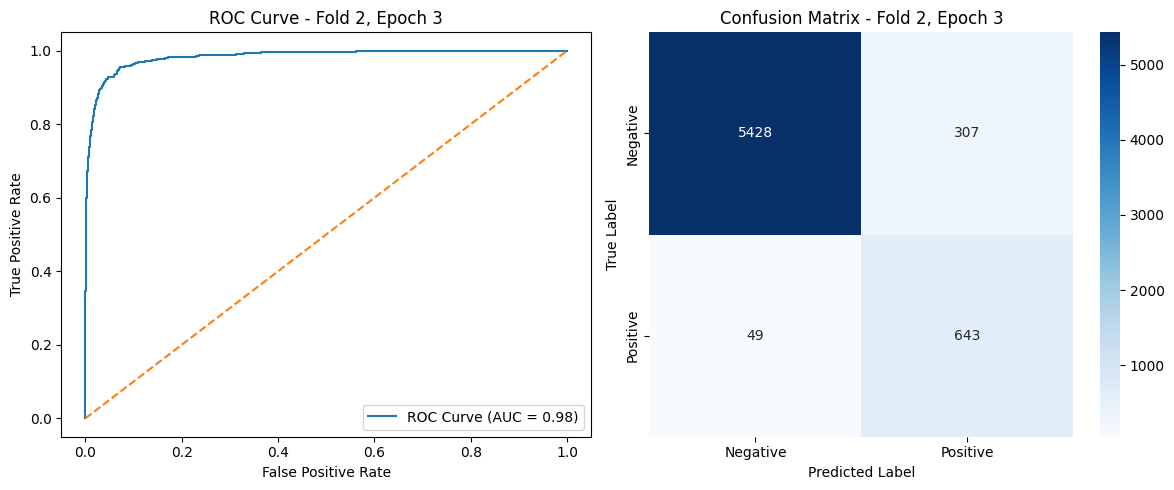

Best model for fold 2 saved with loss: 0.1310


100%|██████████| 402/402 [00:34<00:00, 11.73it/s]


Epoch 4/10 - Loss: 0.1519


100%|██████████| 101/101 [00:07<00:00, 14.27it/s]


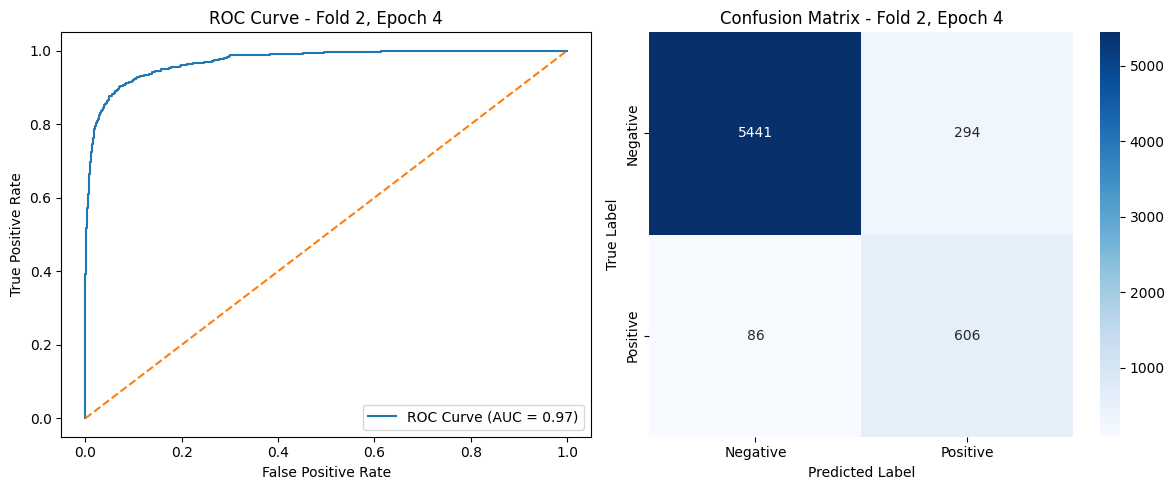

100%|██████████| 402/402 [00:35<00:00, 11.48it/s]


Epoch 5/10 - Loss: 0.1323


100%|██████████| 101/101 [00:06<00:00, 15.02it/s]


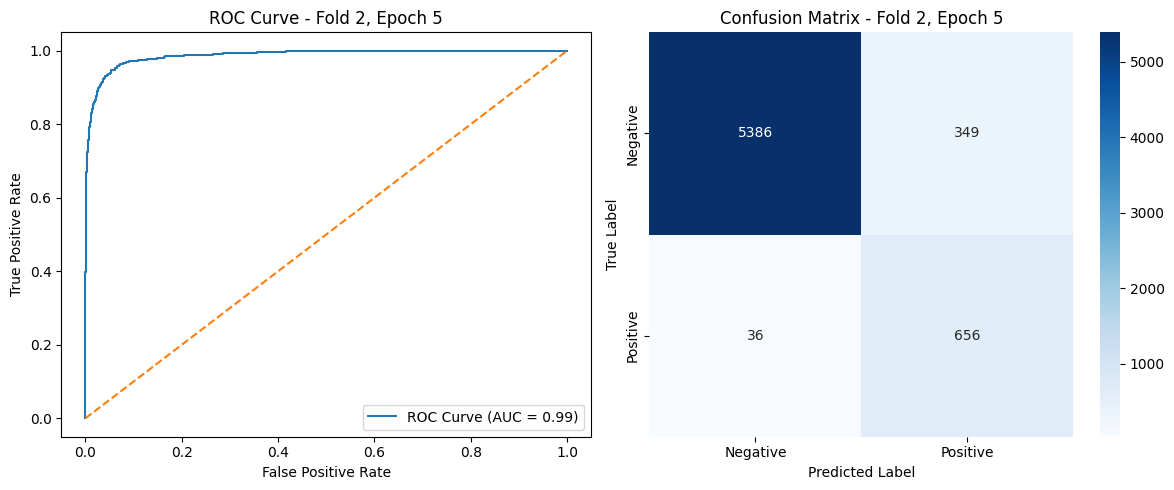

100%|██████████| 402/402 [00:36<00:00, 11.11it/s]


Epoch 6/10 - Loss: 0.0852


100%|██████████| 101/101 [00:07<00:00, 14.08it/s]


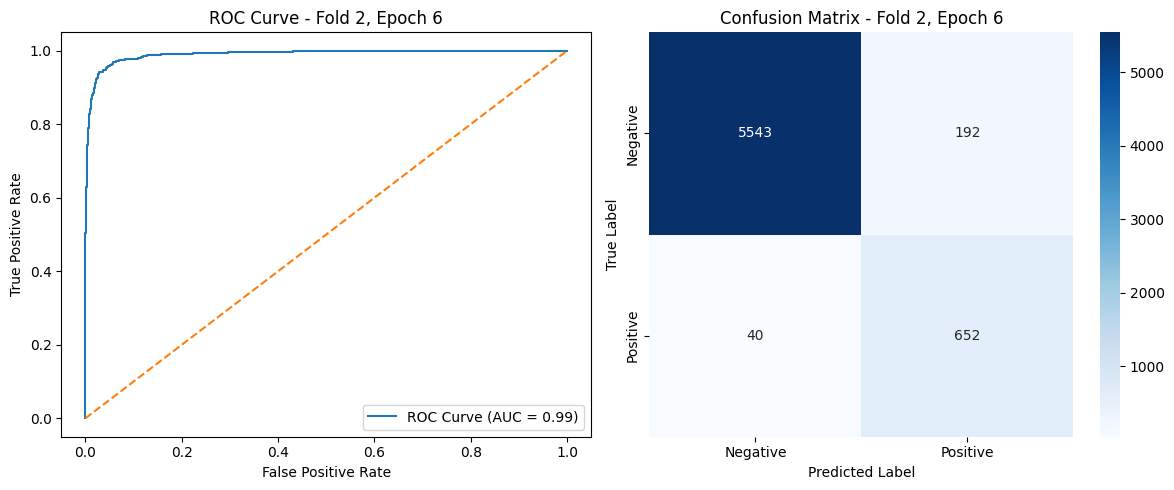

Best model for fold 2 saved with loss: 0.0991


100%|██████████| 402/402 [00:35<00:00, 11.25it/s]


Epoch 7/10 - Loss: 0.1134


100%|██████████| 101/101 [00:06<00:00, 14.77it/s]


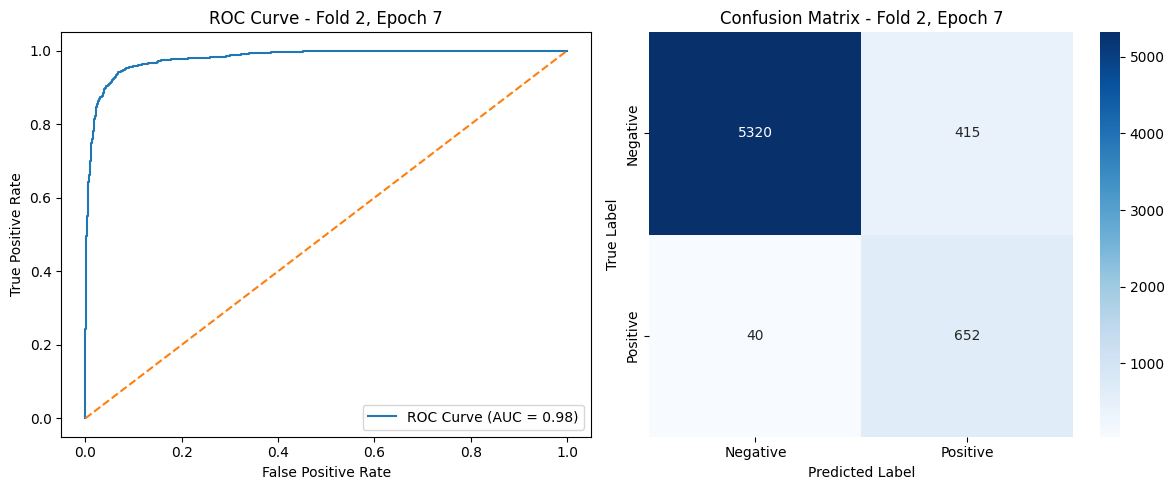

100%|██████████| 402/402 [00:34<00:00, 11.67it/s]


Epoch 8/10 - Loss: 0.1367


100%|██████████| 101/101 [00:07<00:00, 14.27it/s]


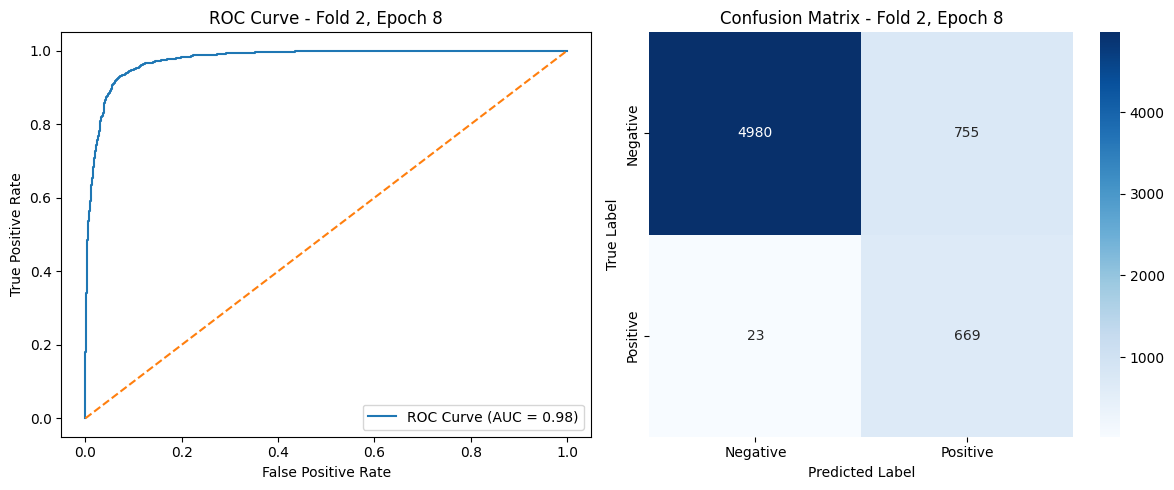

100%|██████████| 402/402 [00:34<00:00, 11.51it/s]


Epoch 9/10 - Loss: 0.1112


100%|██████████| 101/101 [00:06<00:00, 15.24it/s]


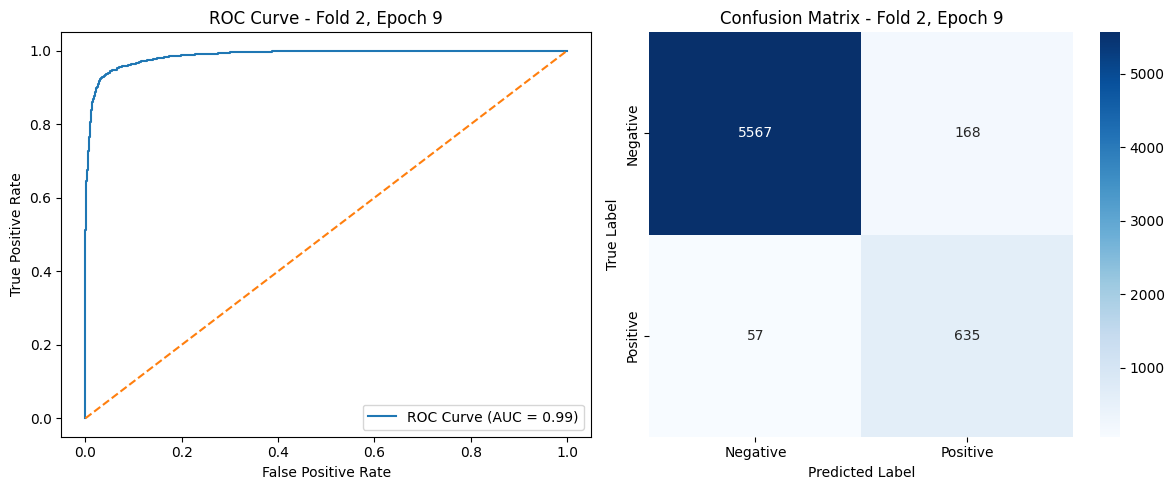

100%|██████████| 402/402 [00:35<00:00, 11.24it/s]


Epoch 10/10 - Loss: 0.0832


100%|██████████| 101/101 [00:06<00:00, 15.27it/s]


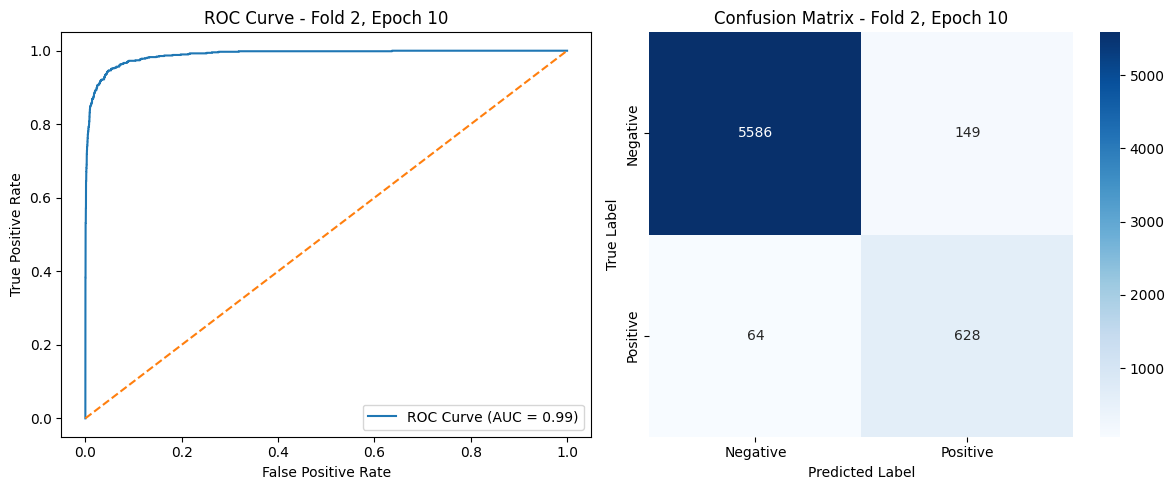

Best model for fold 2 saved with loss: 0.0913


100%|██████████| 101/101 [00:06<00:00, 14.88it/s]



===== Fold 3/5 =====


100%|██████████| 402/402 [00:35<00:00, 11.29it/s]


Epoch 1/10 - Loss: 0.2690


100%|██████████| 101/101 [00:06<00:00, 14.86it/s]


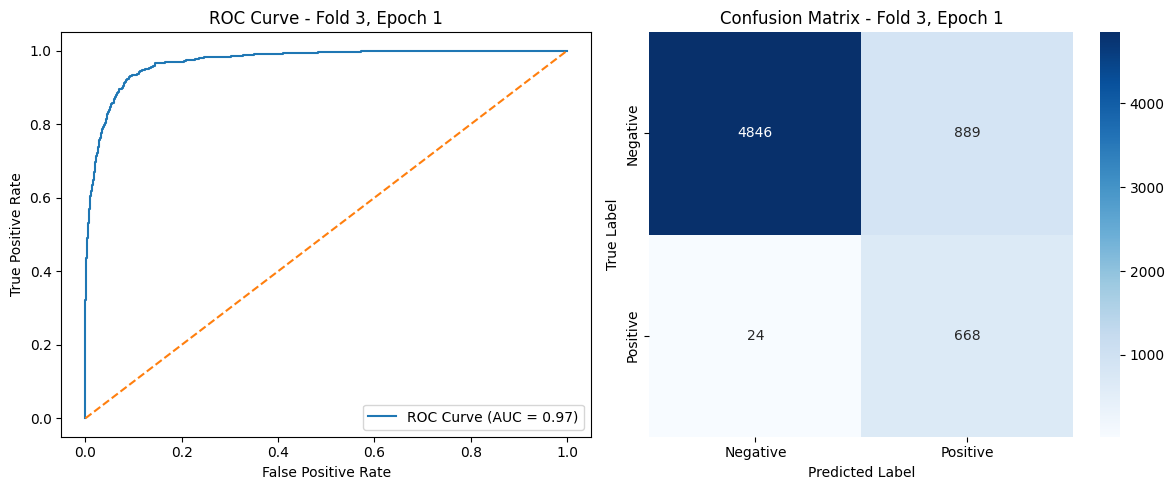

Best model for fold 3 saved with loss: 0.2989


100%|██████████| 402/402 [00:36<00:00, 10.99it/s]


Epoch 2/10 - Loss: 0.2008


100%|██████████| 101/101 [00:07<00:00, 13.79it/s]


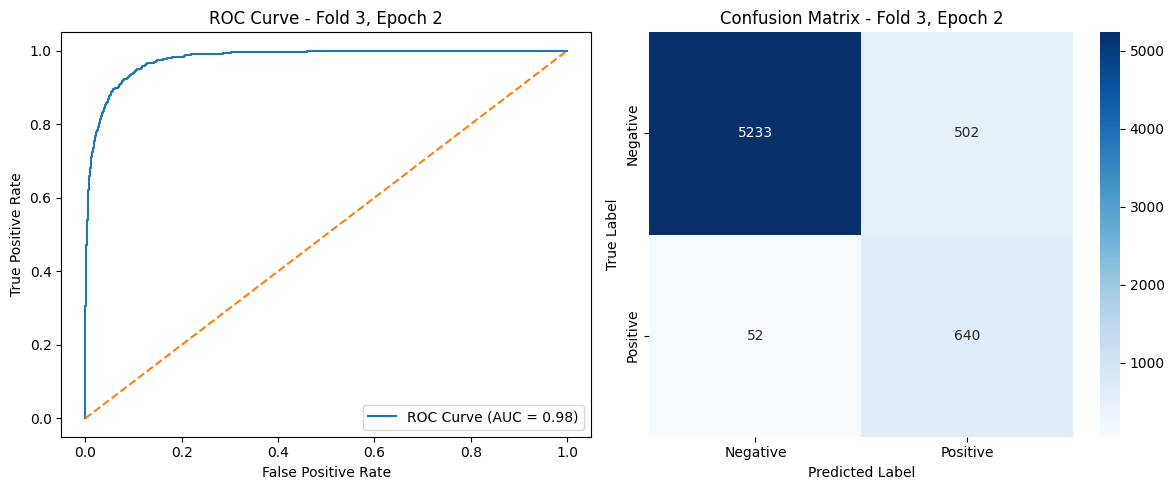

Best model for fold 3 saved with loss: 0.2005


100%|██████████| 402/402 [00:37<00:00, 10.83it/s]


Epoch 3/10 - Loss: 0.1582


100%|██████████| 101/101 [00:07<00:00, 14.33it/s]


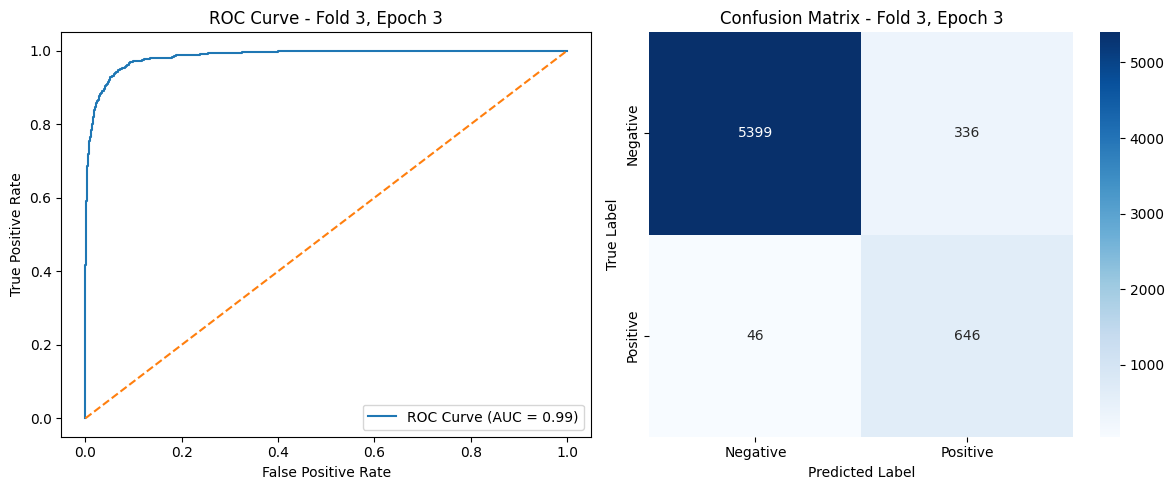

Best model for fold 3 saved with loss: 0.1355


100%|██████████| 402/402 [00:35<00:00, 11.24it/s]


Epoch 4/10 - Loss: 0.1612


100%|██████████| 101/101 [00:06<00:00, 15.06it/s]


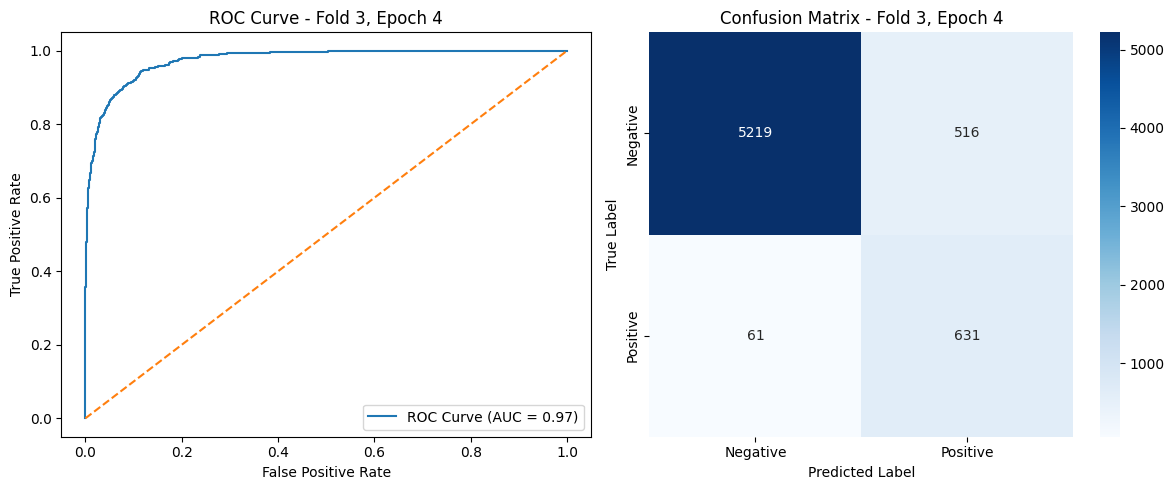

100%|██████████| 402/402 [00:34<00:00, 11.71it/s]


Epoch 5/10 - Loss: 0.1352


100%|██████████| 101/101 [00:06<00:00, 14.79it/s]


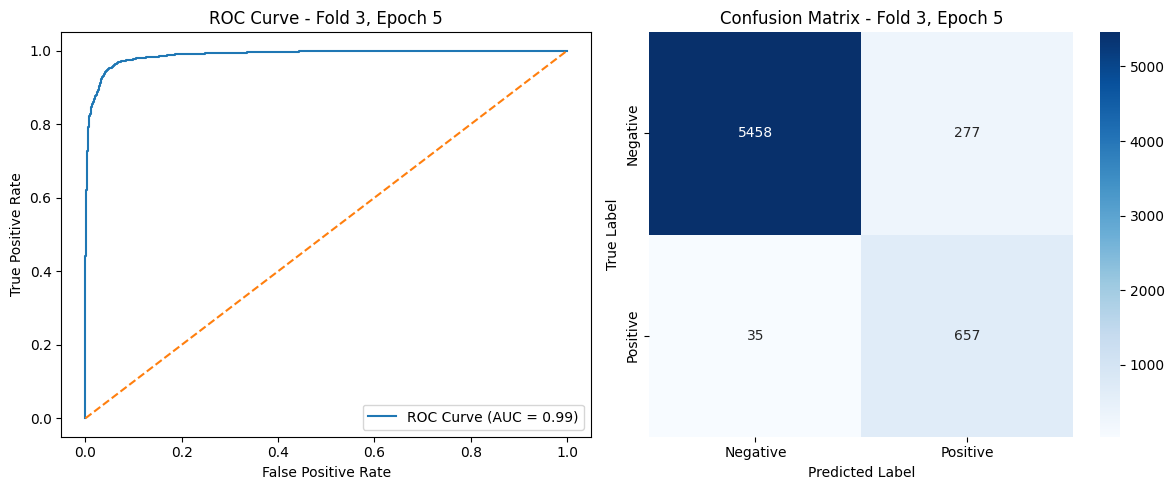

Best model for fold 3 saved with loss: 0.1197


100%|██████████| 402/402 [00:34<00:00, 11.64it/s]


Epoch 6/10 - Loss: 0.0817


100%|██████████| 101/101 [00:07<00:00, 14.24it/s]


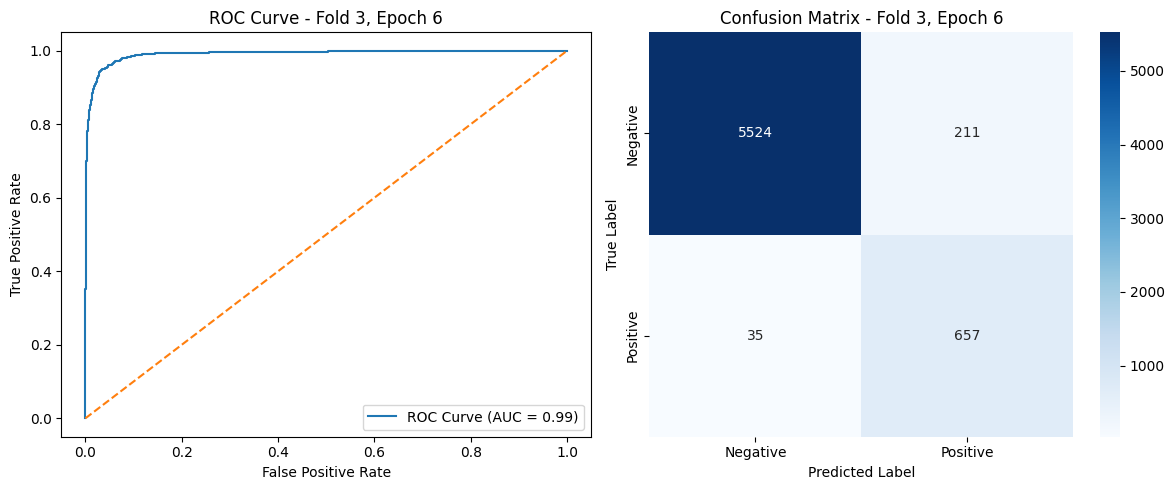

Best model for fold 3 saved with loss: 0.0988


100%|██████████| 402/402 [00:35<00:00, 11.37it/s]


Epoch 7/10 - Loss: 0.1058


100%|██████████| 101/101 [00:07<00:00, 14.25it/s]


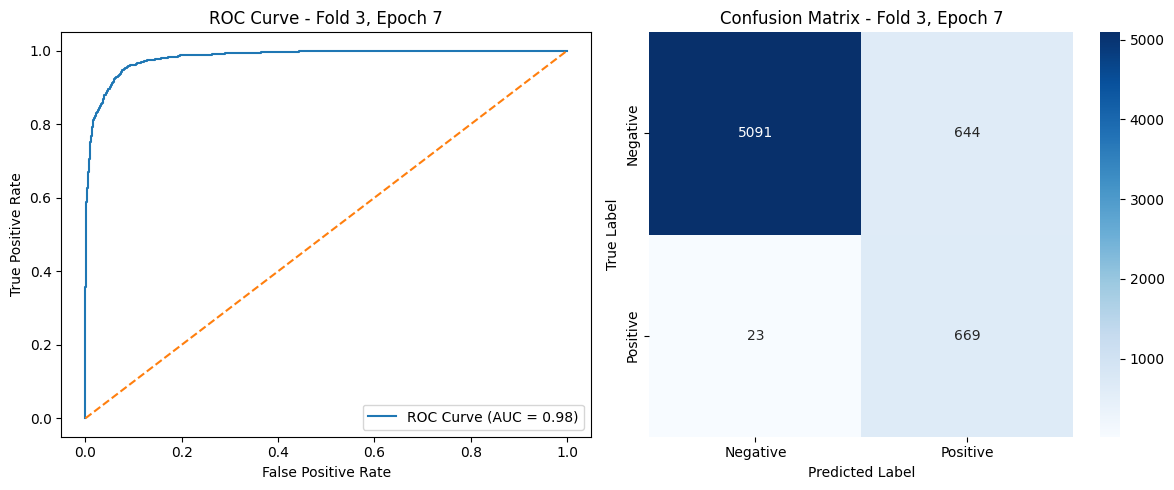

100%|██████████| 402/402 [00:35<00:00, 11.41it/s]


Epoch 8/10 - Loss: 0.1272


100%|██████████| 101/101 [00:06<00:00, 14.88it/s]


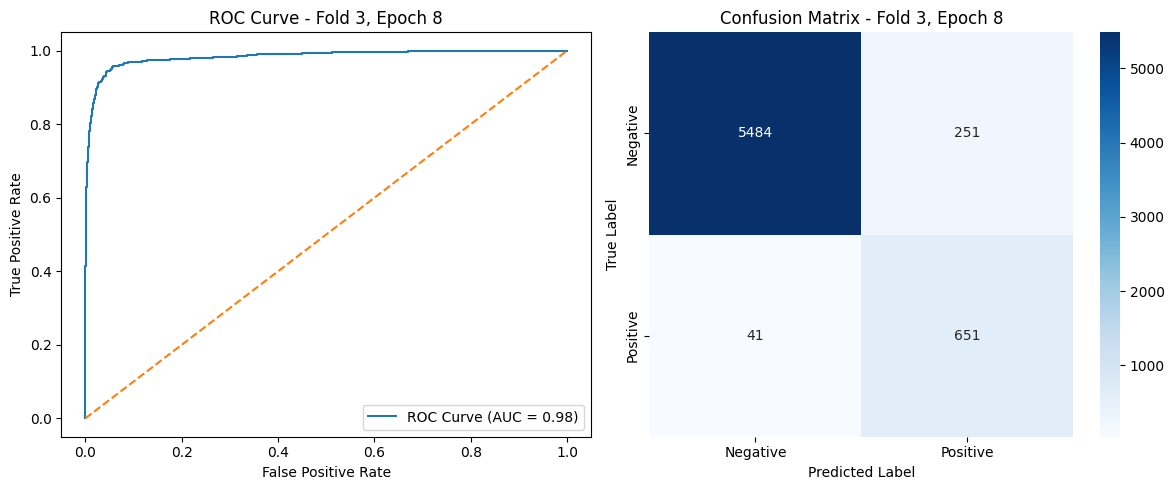

100%|██████████| 402/402 [00:34<00:00, 11.75it/s]


Epoch 9/10 - Loss: 0.1014


100%|██████████| 101/101 [00:06<00:00, 14.51it/s]


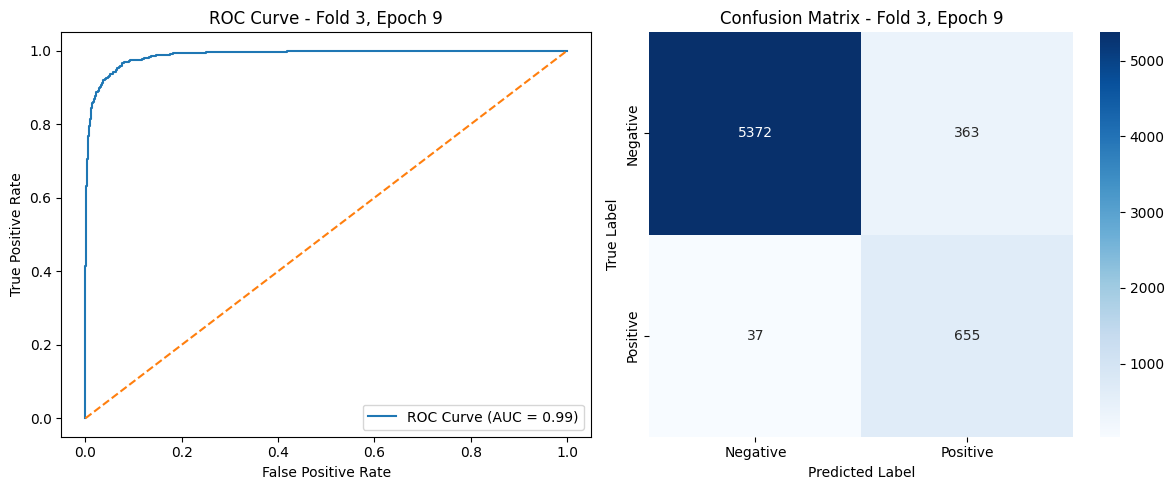

100%|██████████| 402/402 [00:34<00:00, 11.50it/s]


Epoch 10/10 - Loss: 0.0708


100%|██████████| 101/101 [00:06<00:00, 15.22it/s]


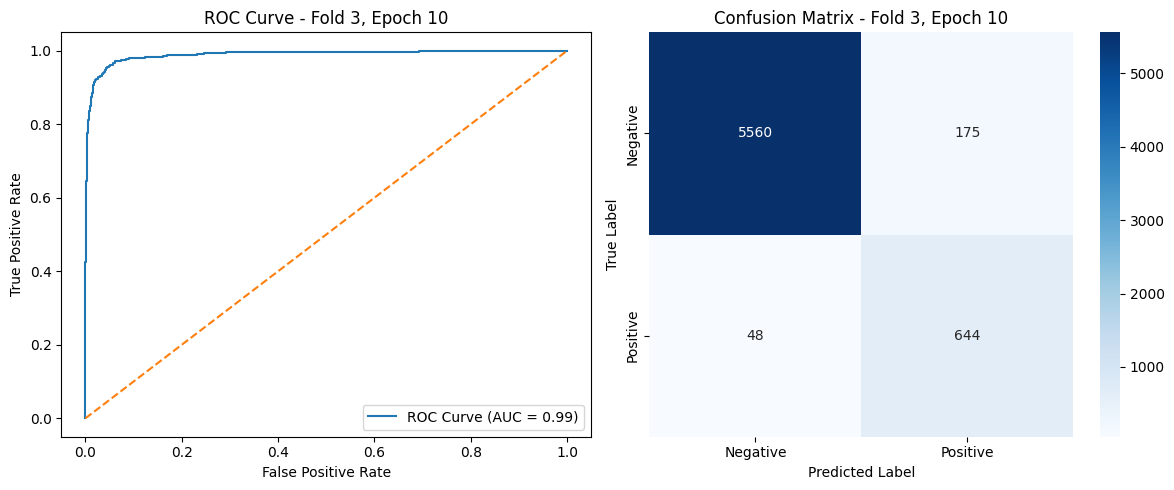

Best model for fold 3 saved with loss: 0.0970


100%|██████████| 101/101 [00:06<00:00, 15.18it/s]



===== Fold 4/5 =====


100%|██████████| 402/402 [00:35<00:00, 11.35it/s]


Epoch 1/10 - Loss: 0.2655


100%|██████████| 101/101 [00:06<00:00, 15.18it/s]


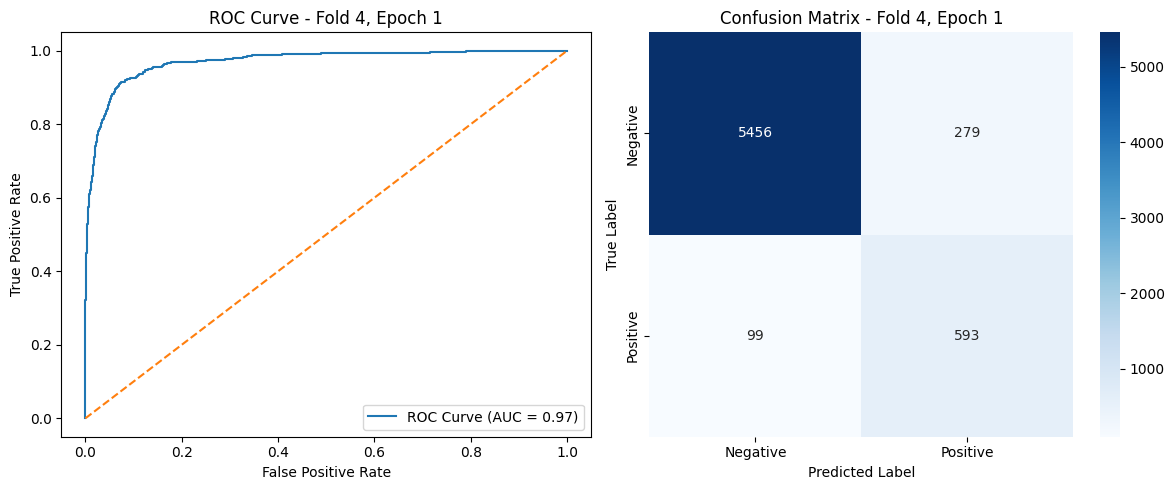

Best model for fold 4 saved with loss: 0.1565


100%|██████████| 402/402 [00:34<00:00, 11.81it/s]


Epoch 2/10 - Loss: 0.2041


100%|██████████| 101/101 [00:07<00:00, 13.87it/s]


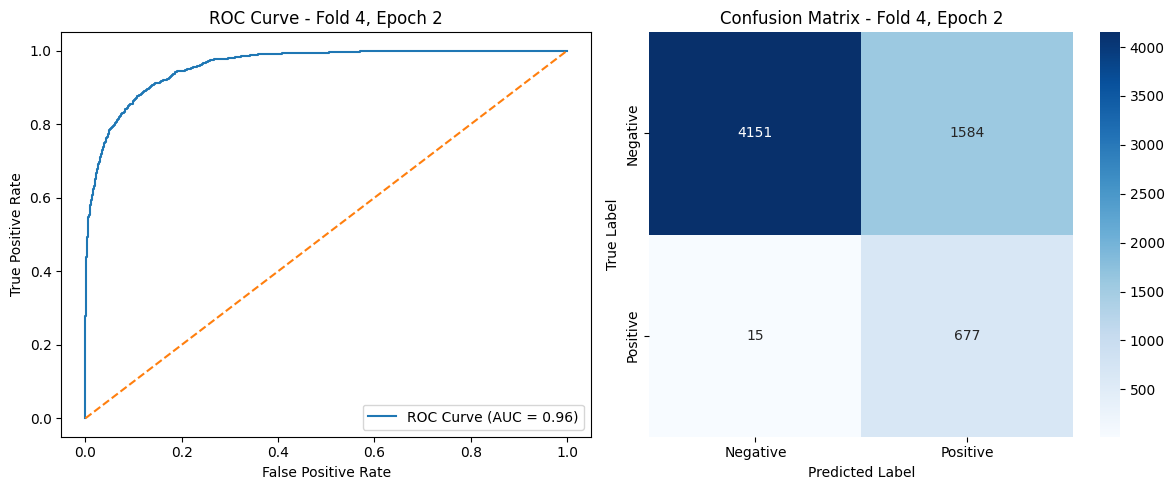

100%|██████████| 402/402 [00:33<00:00, 11.94it/s]


Epoch 3/10 - Loss: 0.1712


100%|██████████| 101/101 [00:06<00:00, 15.18it/s]


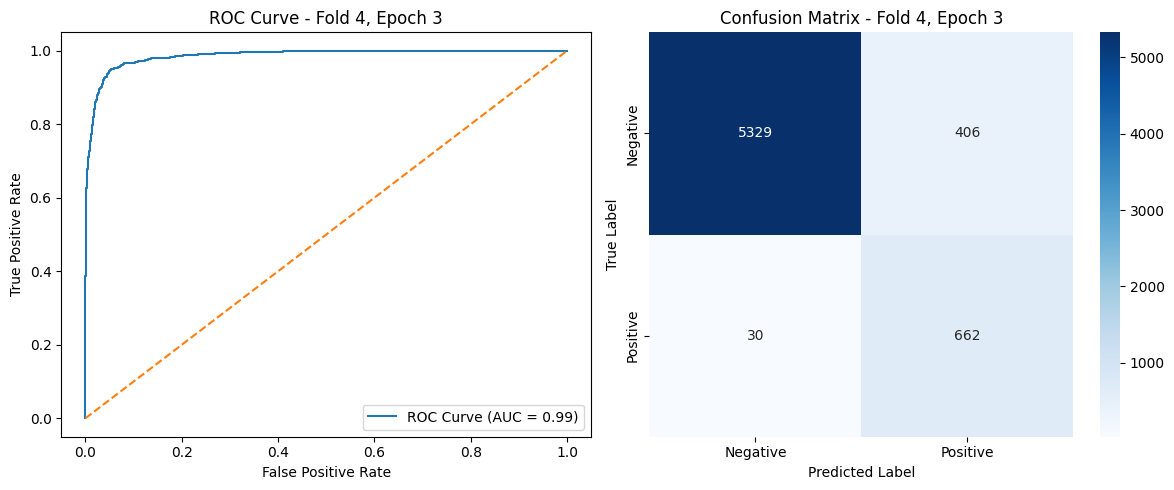

100%|██████████| 402/402 [00:35<00:00, 11.40it/s]


Epoch 4/10 - Loss: 0.1736


100%|██████████| 101/101 [00:06<00:00, 15.28it/s]


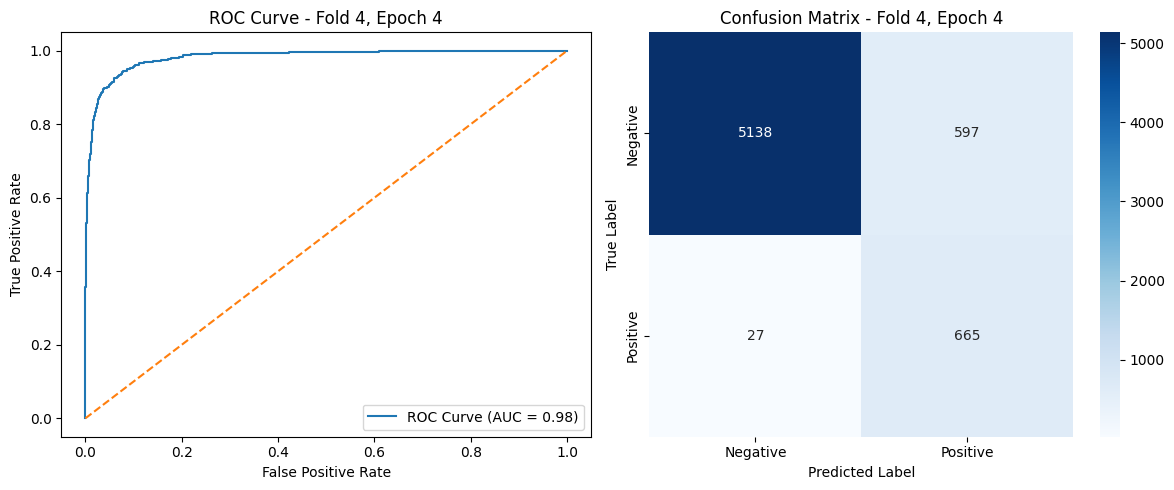

100%|██████████| 402/402 [00:34<00:00, 11.61it/s]


Epoch 5/10 - Loss: 0.1436


100%|██████████| 101/101 [00:06<00:00, 14.95it/s]


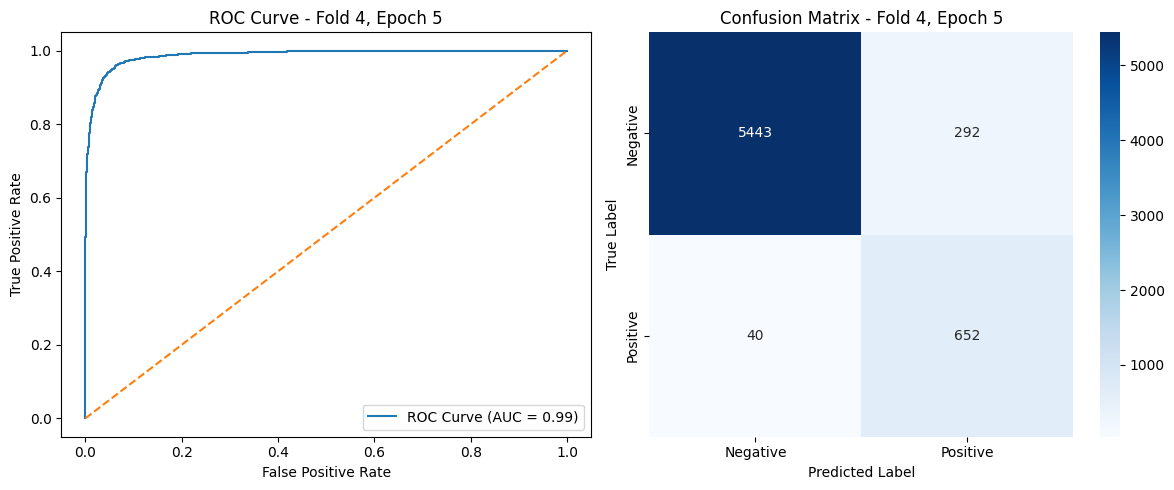

Best model for fold 4 saved with loss: 0.1290


100%|██████████| 402/402 [00:33<00:00, 11.83it/s]


Epoch 6/10 - Loss: 0.0897


100%|██████████| 101/101 [00:06<00:00, 14.88it/s]


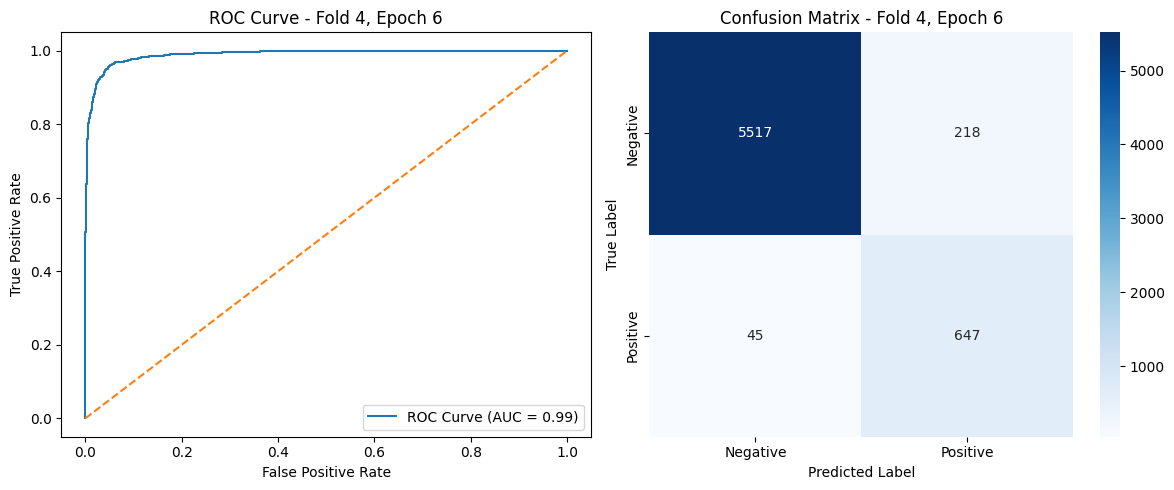

Best model for fold 4 saved with loss: 0.1054


100%|██████████| 402/402 [00:34<00:00, 11.79it/s]


Epoch 7/10 - Loss: 0.1179


100%|██████████| 101/101 [00:06<00:00, 14.99it/s]


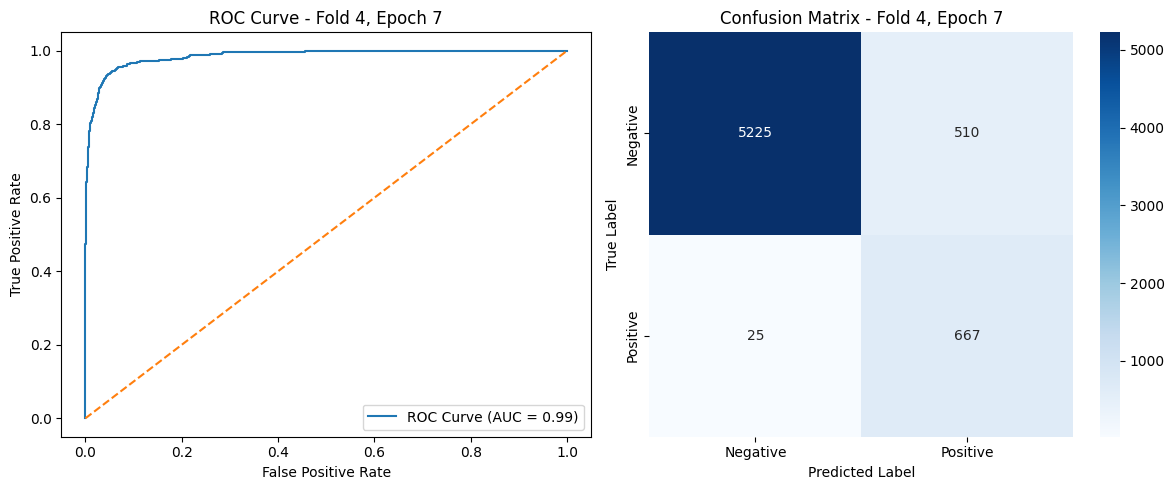

100%|██████████| 402/402 [00:35<00:00, 11.43it/s]


Epoch 8/10 - Loss: 0.1288


100%|██████████| 101/101 [00:06<00:00, 15.27it/s]


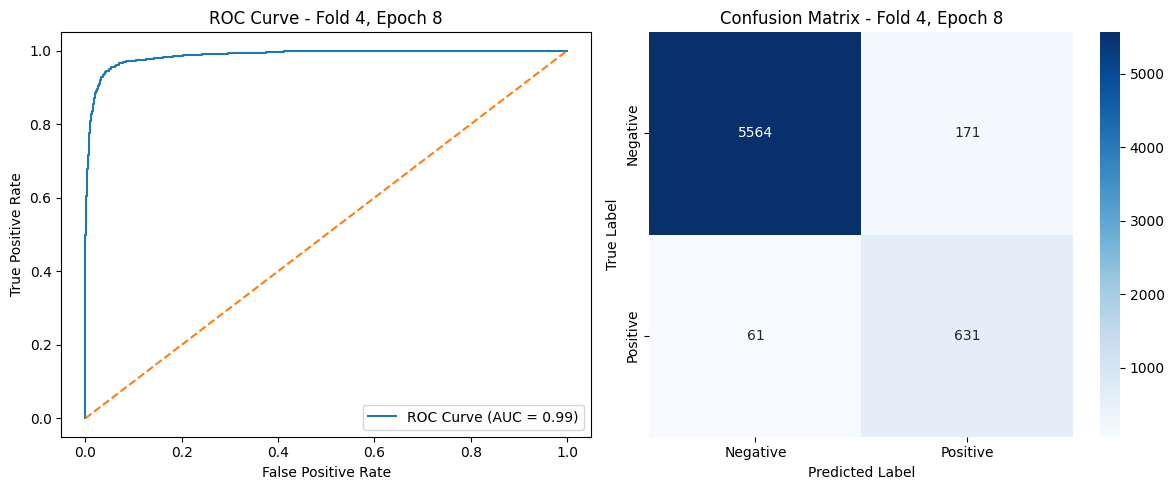

Best model for fold 4 saved with loss: 0.0948


100%|██████████| 402/402 [00:34<00:00, 11.65it/s]


Epoch 9/10 - Loss: 0.1070


100%|██████████| 101/101 [00:07<00:00, 14.13it/s]


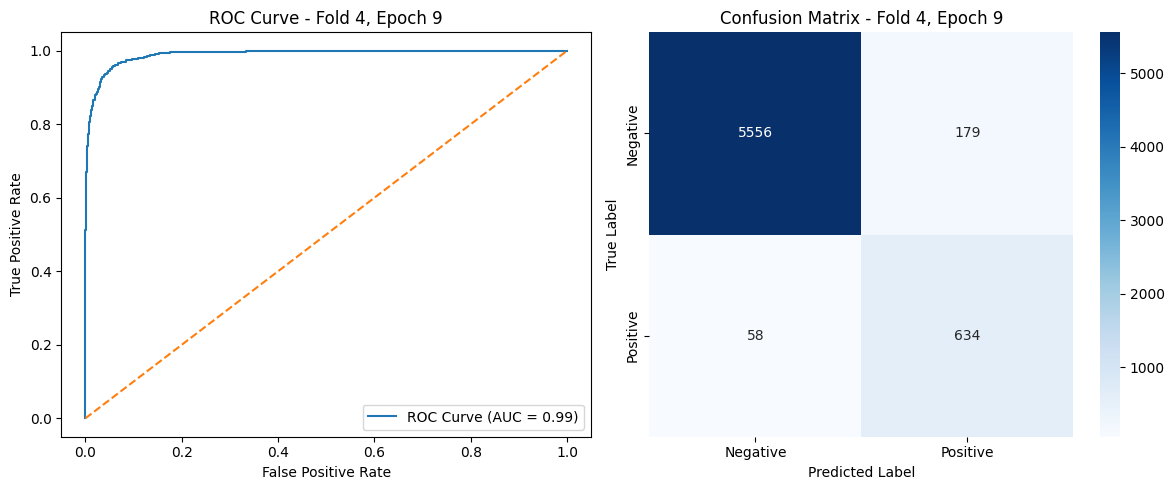

Best model for fold 4 saved with loss: 0.0915


100%|██████████| 402/402 [00:33<00:00, 11.94it/s]


Epoch 10/10 - Loss: 0.0813


100%|██████████| 101/101 [00:06<00:00, 14.87it/s]


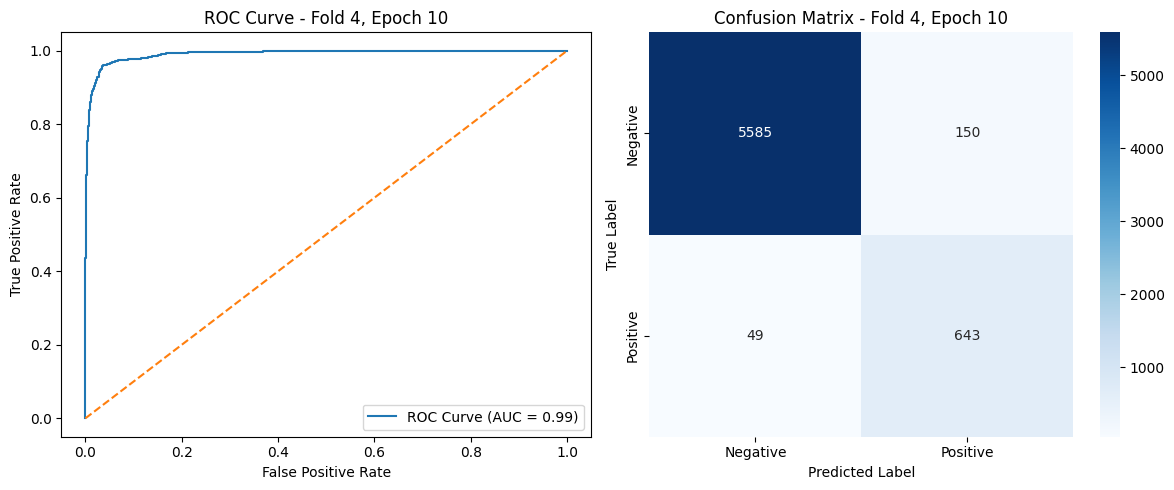

Best model for fold 4 saved with loss: 0.0866


100%|██████████| 101/101 [00:07<00:00, 14.41it/s]



===== Fold 5/5 =====


100%|██████████| 402/402 [00:35<00:00, 11.38it/s]


Epoch 1/10 - Loss: 0.2695


100%|██████████| 101/101 [00:07<00:00, 14.37it/s]


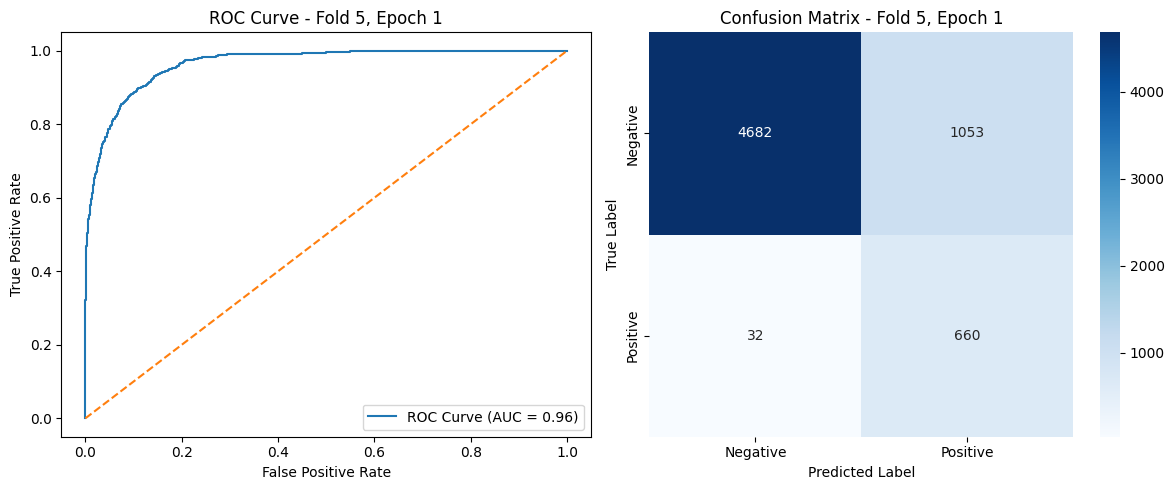

Best model for fold 5 saved with loss: 0.3480


100%|██████████| 402/402 [00:35<00:00, 11.43it/s]


Epoch 2/10 - Loss: 0.1951


100%|██████████| 101/101 [00:06<00:00, 15.54it/s]


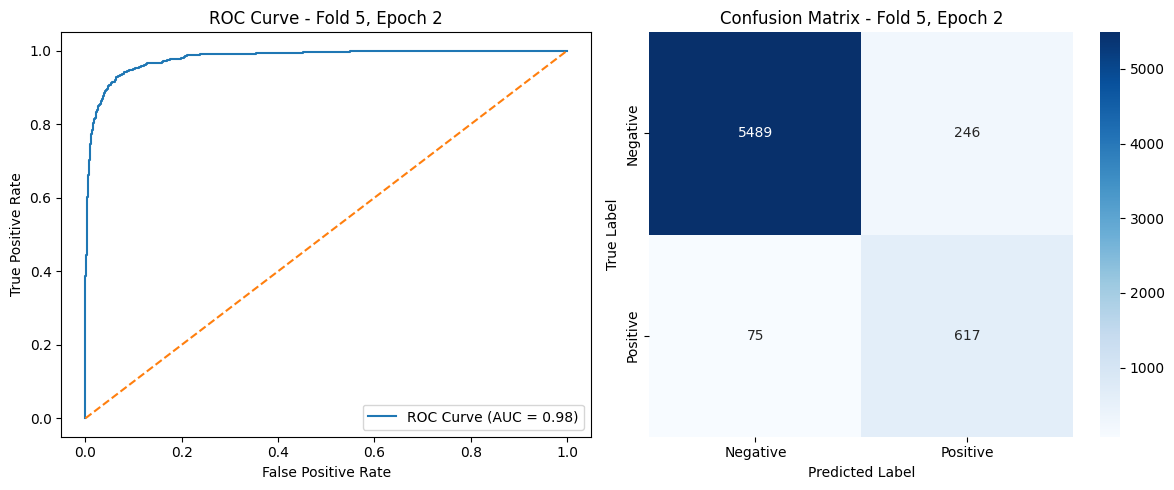

Best model for fold 5 saved with loss: 0.1261


100%|██████████| 402/402 [00:35<00:00, 11.41it/s]


Epoch 3/10 - Loss: 0.1578


100%|██████████| 101/101 [00:07<00:00, 13.22it/s]


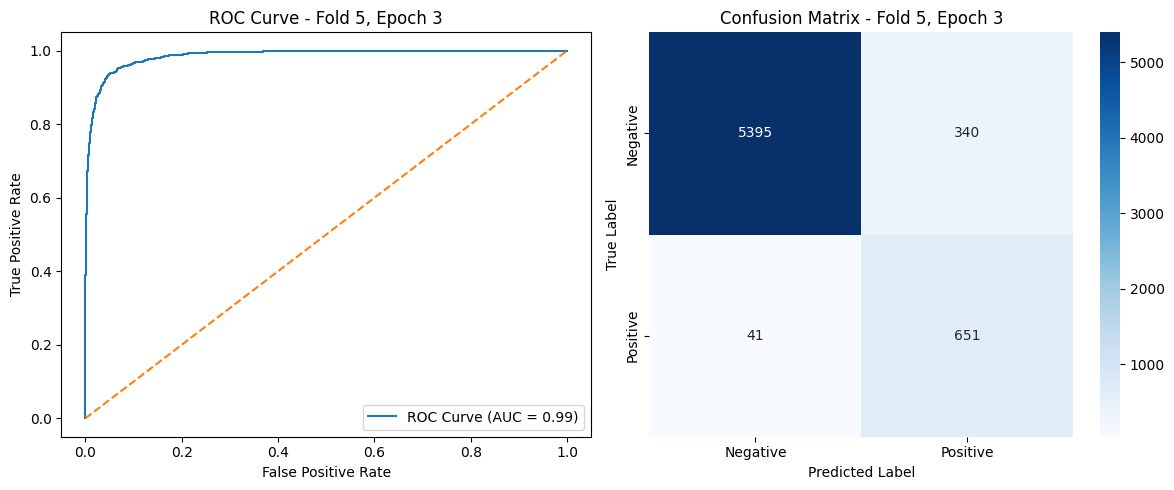

100%|██████████| 402/402 [00:35<00:00, 11.27it/s]


Epoch 4/10 - Loss: 0.1648


100%|██████████| 101/101 [00:06<00:00, 14.52it/s]


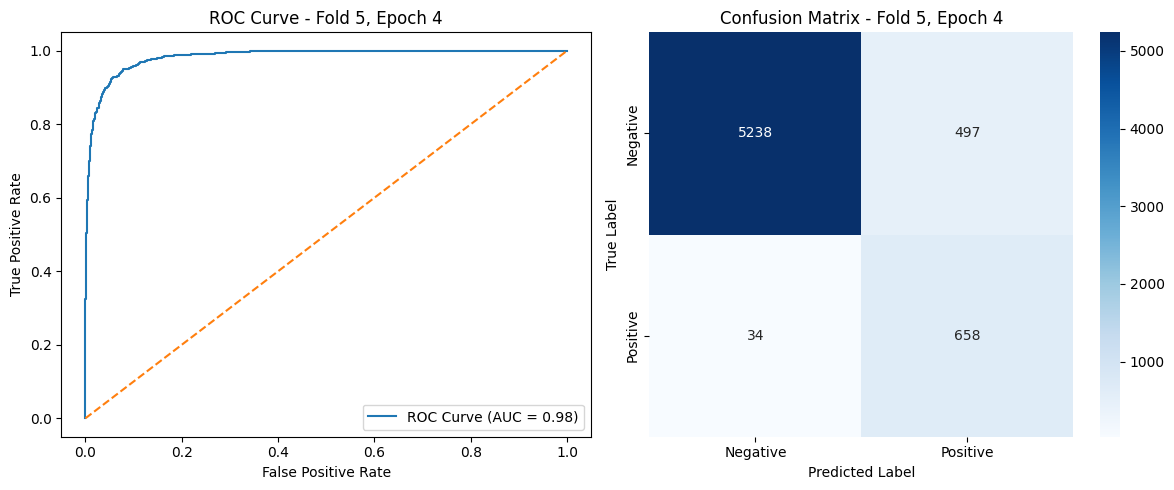

100%|██████████| 402/402 [00:36<00:00, 11.06it/s]


Epoch 5/10 - Loss: 0.1315


100%|██████████| 101/101 [00:07<00:00, 13.84it/s]


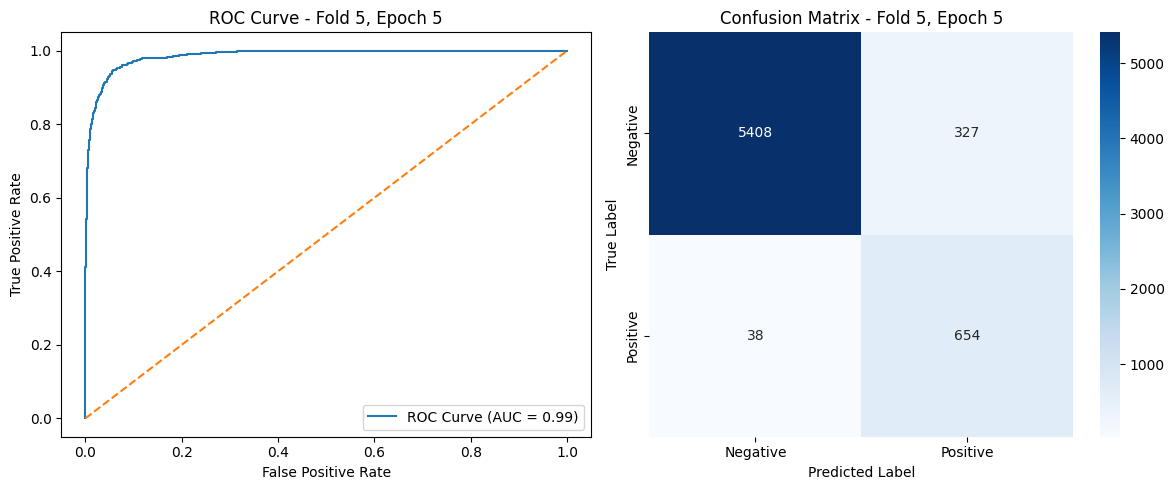

100%|██████████| 402/402 [00:34<00:00, 11.78it/s]


Epoch 6/10 - Loss: 0.0816


100%|██████████| 101/101 [00:06<00:00, 14.68it/s]


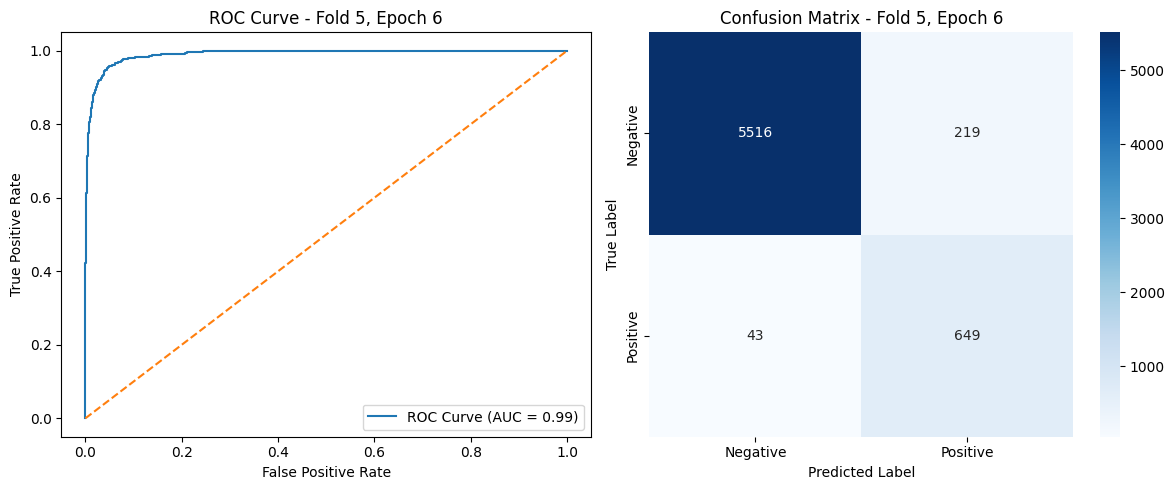

Best model for fold 5 saved with loss: 0.1049


100%|██████████| 402/402 [00:34<00:00, 11.63it/s]


Epoch 7/10 - Loss: 0.1135


100%|██████████| 101/101 [00:07<00:00, 13.94it/s]


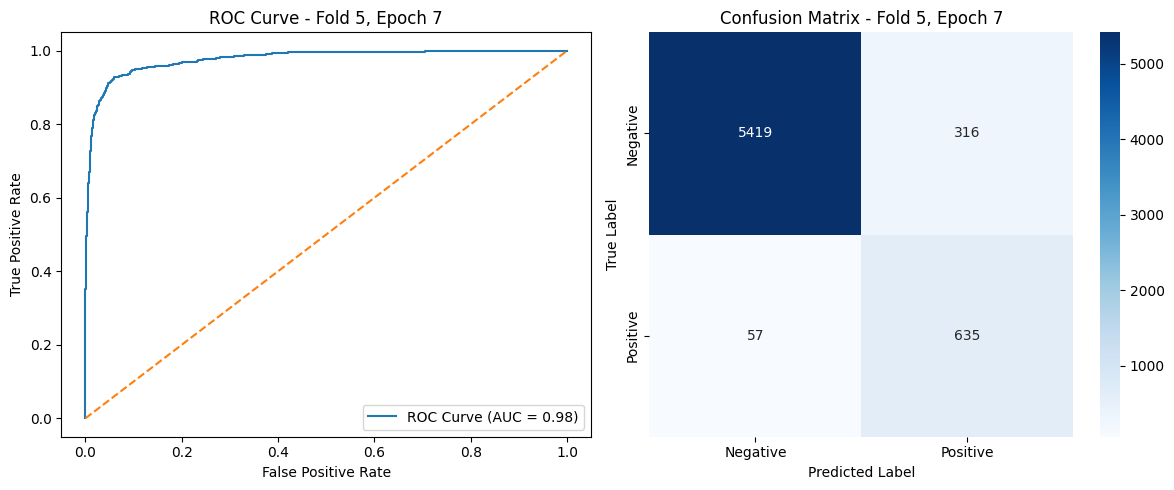

100%|██████████| 402/402 [00:40<00:00,  9.81it/s]


Epoch 8/10 - Loss: 0.1232


100%|██████████| 101/101 [00:06<00:00, 14.92it/s]


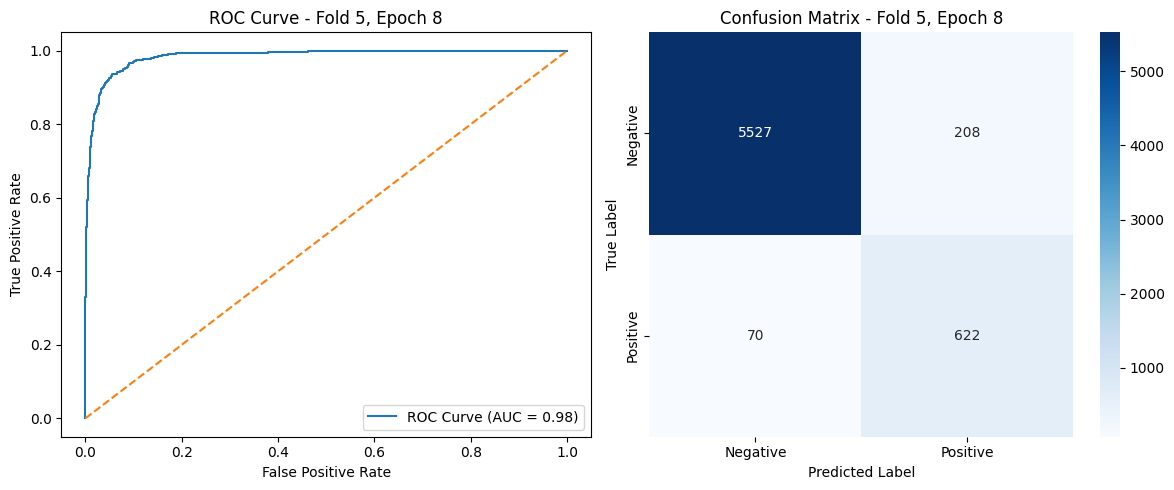

100%|██████████| 402/402 [00:35<00:00, 11.30it/s]


Epoch 9/10 - Loss: 0.0976


100%|██████████| 101/101 [00:06<00:00, 14.86it/s]


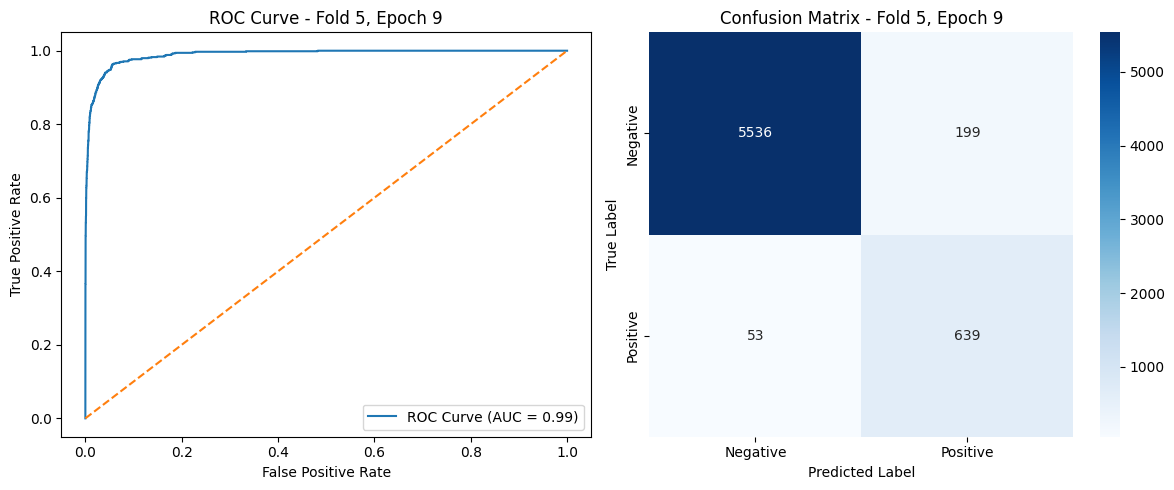

Best model for fold 5 saved with loss: 0.0968


100%|██████████| 402/402 [00:35<00:00, 11.17it/s]


Epoch 10/10 - Loss: 0.0753


100%|██████████| 101/101 [00:06<00:00, 14.50it/s]


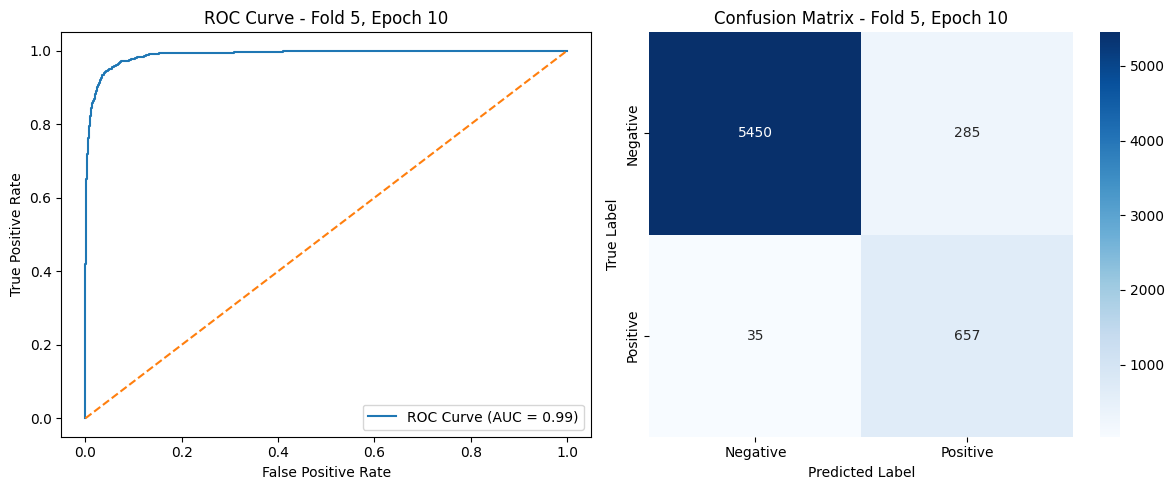

100%|██████████| 101/101 [00:07<00:00, 14.28it/s]



===== Final Model Performance =====
Ensemble F1 Score: 0.9123
Ensemble ROC AUC Score: 0.9888


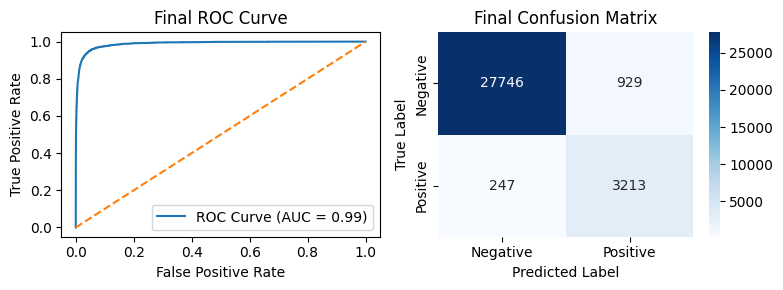

In [58]:
ensemble_predict_fn,saved_models=train_kfold(train_dataset2,"resnet18",10,5,64)

In [59]:
def ensemble_predict(test_loader, model_name, num_folds=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    all_probs = []
    true_labels = []  

    for fold in range(num_folds):
        print(f"Loading model for fold {fold+1}...")
        model = timm.create_model(model_name, pretrained=False, num_classes=2).to(device)
        checkpoint_path = f"best_model_fold_{fold+1}.pth"  
        
        checkpoint = torch.load(checkpoint_path, map_location=device)  
        model.load_state_dict(checkpoint["model_state_dict"])  
        
        model.eval()

        fold_probs = []
        
        with torch.no_grad():
            for x, y in tqdm(test_loader):
                x, y = x.to(device), y.to(device)
                batch = x.shape[0]
                x = x.view(batch, 3, 64, 64)
                
                out = model(x)
                prob = torch.softmax(out, dim=1)[:, 1]  
                
                fold_probs.extend(prob.cpu().numpy().tolist())
                if fold == 0:
                    true_labels.extend(y.cpu().numpy().tolist()) 

        all_probs.append(fold_probs)
    all_probs = np.array(all_probs)
    avg_probs = np.mean(all_probs, axis=0)
    final_preds = (avg_probs >= 0.5).astype(int)
    f1 = f1_score(true_labels, final_preds, average=None)
    f2 = f1_score(true_labels, final_preds, average="macro")
    
    print("The F1 score is:", f1, " ", f2)

    auc_score = roc_auc_score(true_labels, avg_probs)
    print("The ROC AUC score is:", auc_score)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(true_labels, final_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Ensemble)")

    # ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(true_labels, avg_probs)
    plt.plot(fpr, tpr, label=f'Ensemble ROC Curve (AUC = {auc_score:.3f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Ensemble)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return true_labels, avg_probs, auc_score

Loading model for fold 1...


<ipython-input-59-8ab58d0c8358>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
100%|██████████| 308/308 [00:

Loading model for fold 2...


100%|██████████| 308/308 [00:21<00:00, 14.59it/s]


Loading model for fold 3...


100%|██████████| 308/308 [00:20<00:00, 15.07it/s]


Loading model for fold 4...


100%|██████████| 308/308 [00:20<00:00, 14.87it/s]


Loading model for fold 5...


100%|██████████| 308/308 [00:20<00:00, 15.17it/s]


The F1 score is: [0.98698803 0.37139272]   0.6791903748085787
The ROC AUC score is: 0.976107651450751


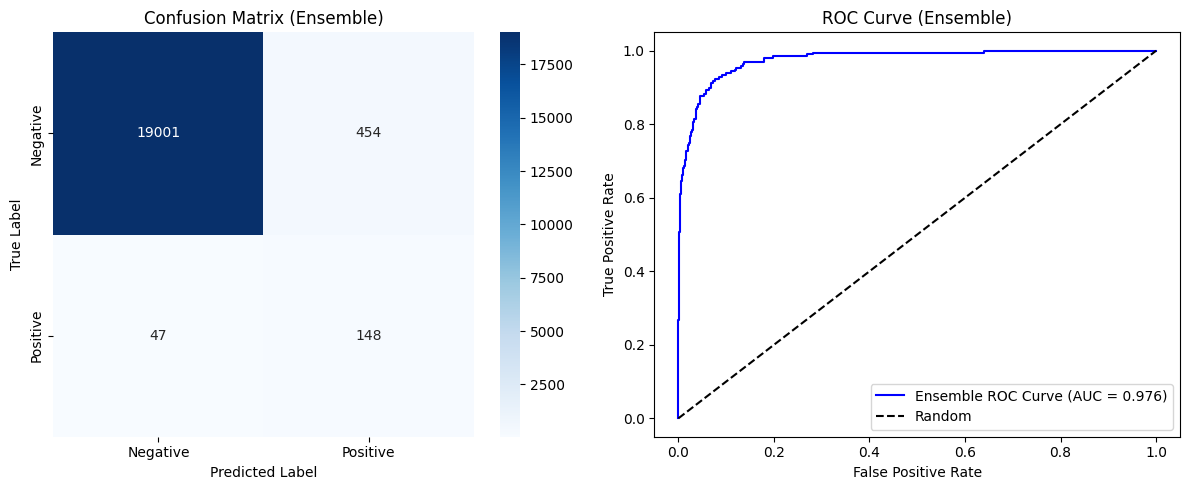

In [60]:
t8,p8,roc8=ensemble_predict(test_loader0,"resnet18")

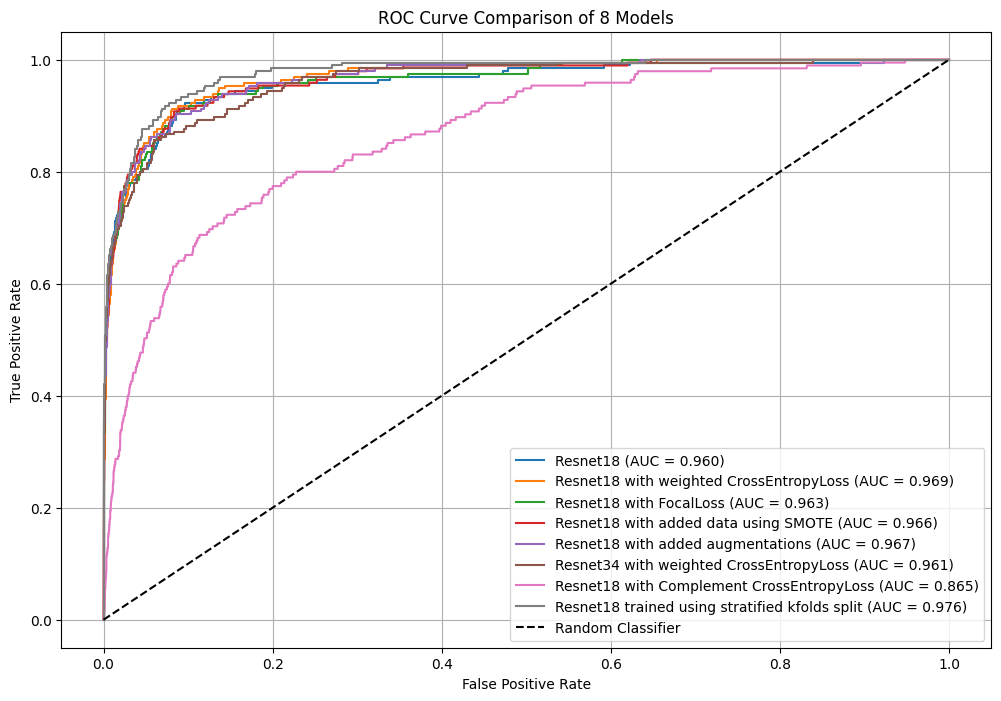

In [79]:
models = [
    ("Resnet18", t1, p1, roc1),
    ("Resnet18 with weighted CrossEntropyLoss", t2, p2, roc2),
    ("Resnet18 with FocalLoss", t3, p3, roc3),
    ("Resnet18 with added data using SMOTE", t4, p4, roc4),
    ("Resnet18 with added augmentations", t5, p5, roc5),
    ("Resnet34 with weighted CrossEntropyLoss", t6, p6, roc6),
    ("Resnet18 with Complement CrossEntropyLoss", t7, p7, roc7),
    ("Resnet18 trained using stratified kfolds split", t8, p8, roc8),
]

plt.figure(figsize=(12, 8))
for name, true_labels, prob_list, auc_score in models:
    fpr, tpr, _ = roc_curve(true_labels, prob_list)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of 8 Models")
plt.legend()
plt.grid(True)
plt.show()